In [1]:
import torch,os,pickle,math,evaluate,nltk
from nltk.translate.meteor_score import single_meteor_score
from nltk.translate.nist_score import sentence_nist
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge import Rouge
from collections import Counter
from evaluate import load,logging
import pandas as pd
from transformers import BitsAndBytesConfig,LlamaTokenizer,LlamaForCausalLM,GPT2Tokenizer, GPT2LMHeadModel
from bert_evaluation import Model,get_accuracy_by_bert
import numpy as np
from torch.nn import CrossEntropyLoss
from utils.performance_eval_gpt import result_per_setting
os.environ["CUDA_VISIBLE_DEVICES"]="1"
device = 'cuda'
import matplotlib.pyplot as plt

In [2]:
setting_name = 'result_df/{}__{}__{}'.format(0.01,100,3)
with open(setting_name,'rb') as fw:
        data = pickle.load(fw)
data


[0.364,
 0.364,
 0.499,
 0.261,
 0.347,
 70.7,
 7.95,
 44.94,
 84.23,
 90.69,
 0.34,
 0.34,
 9.16,
 0.55,
 4.59,
 5.4,
 5.6]

In [3]:
def df_create(stepsizess, perturb_layers,num_iterationsss):
    
    empty_df = pd.DataFrame(columns=['acc','recall','precision','f1','class_pr','Perplexity','METEOR','D-1','D-2','D-3','N-2',
                 'N-4','BLEU1','BLEU2','RougeL','Entropy2', 'Entropy4'])
    index_names = []
    for stepsize in stepsizess:
        for num_iterations in num_iterationsss:
            for perturb_layer in perturb_layers:
                setting_name = '{}__{}__{}'.format(stepsize,perturb_layer,num_iterations)
                with open('result_df/'+setting_name,'rb') as fw:
                      retab = pickle.load(fw)
                empty_df.loc[len(empty_df)] = retab
                index_names.append(setting_name)
    empty_df.index = index_names 
    display(empty_df)
    return empty_df

def avg_dfs(df_list):
    df_result = df_list[0]
    for i in df_list[1:]:
        df_result = df_result.reset_index(drop=True).add(i.reset_index(drop=True))
    display(df_result / len(df_list))  
    return df_result / len(df_list)

## num_iter 3
### table 1. 
- pre-trained 
- 0.01_100_3
- ...
- 0.5_100
### table 2~15
- 0.01_100_3
- 0.01_11_3
- 0.01_22_3
- 0.01_32_3

### table 2~15 평균

### num_iter 5


In [4]:
pre_trained = df_create([0],[0],[0])

acc  recall  precision     f1  class_pr  Perplexity  METEOR    D-1  \
0__0__0  0.386   0.386       0.46  0.347     0.301       63.83    9.79  48.58   

           D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  Entropy2  Entropy4  
0__0__0  86.63  92.25  0.39  0.39  12.06   1.21    6.29      5.33      5.48

In [5]:


stepsizess = [0.001,0.003,0.005,0.007,0.009,
              0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,
             0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.2,
              0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,
              0.3,0.35,0.4]
#stepsizess = np.round(np.arange(0.09,0.31,0.01),2)
df_100_3 = df_create(stepsizess,[100],[3])
df_100_5 = df_create(stepsizess,[100],[5])

df_100_35 = avg_dfs([df_100_3,df_100_5])

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.001__100__3  0.364   0.364      0.268  0.265     0.313       72.39    9.08   
0.003__100__3  0.318   0.318      0.314  0.246     0.310       58.15    7.18   
0.005__100__3  0.409   0.409      0.407  0.338     0.341       66.00    7.33   
0.007__100__3  0.295   0.295      0.302  0.247     0.299       75.29    6.90   
0.009__100__3  0.432   0.432      0.544  0.372     0.355       76.16    6.52   
0.01__100__3   0.364   0.364      0.499  0.261     0.347       70.70    7.95   
0.02__100__3   0.432   0.432      0.488  0.391     0.329       52.42    7.65   
0.03__100__3   0.341   0.341      0.232  0.234     0.277       62.10    7.67   
0.04__100__3   0.477   0.477      0.527  0.405     0.349       81.04    7.15   
0.05__100__3   0.455   0.455      0.669  0.394     0.353       82.74    6.86   
0.06__100__3   0.364   0.364      0.424  0.293     0.320       82.78    8.50   
0.07__100__3   0.455   0.455      0.422  0.403     0.354       64.74    7.66   
0.08__100__3   0.409   0.409      0.381  0.341     0.327       75.07   10.46   
0.09__100__3   0.409   0.409      0.294  0.288     0.331       78.74    7.13   
0.1__100__3    0.386   0.386      0.569  0.286     0.363       73.67    8.96   
0.11__100__3   0.477   0.477      0.677  0.395     0.358       79.22    8.14   
0.12__100__3   0.455   0.455      0.659  0.392     0.385       82.73    8.27   
0.13__100__3   0.477   0.477      0.604  0.446     0.399       70.24    9.10   
0.14__100__3   0.455   0.455      0.571  0.432     0.372       69.73    8.85   
0.15__100__3   0.455   0.455      0.669  0.394     0.354       67.36    8.16   
0.16__100__3   0.500   0.500      0.604  0.461     0.388       71.99    7.85   
0.17__100__3   0.432   0.432      0.424  0.383     0.346       62.66    7.19   
0.18__100__3   0.523   0.523      0.589  0.481     0.368       71.47    7.69   
0.19__100__3   0.455   0.455      0.486  0.424     0.354       73.91    8.01   
0.2__100__3    0.364   0.364      0.347  0.289     0.335       71.01    8.80   
0.21__100__3   0.500   0.500      0.715  0.454     0.397       78.56    8.01   
0.22__100__3   0.523   0.523      0.574  0.473     0.406       60.81   11.14   
0.23__100__3   0.455   0.455      0.354  0.367     0.345       63.79    7.40   
0.24__100__3   0.568   0.568      0.642  0.543     0.373       88.41    6.07   
0.25__100__3   0.500   0.500      0.689  0.451     0.411       78.13    9.41   
0.26__100__3   0.386   0.386      0.395  0.311     0.328       64.60    7.25   
0.27__100__3   0.432   0.432      0.461  0.409     0.381       67.94   10.30   
0.28__100__3   0.409   0.409      0.612  0.351     0.365       76.12    9.08   
0.29__100__3   0.386   0.386      0.420  0.301     0.360       65.73   11.21   
0.3__100__3    0.477   0.477      0.547  0.425     0.383       72.57    7.76   
0.35__100__3   0.477   0.477      0.596  0.425     0.388       82.23    9.25   
0.4__100__3    0.432   0.432      0.511  0.412     0.356       91.30   10.80   

                 D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  \
0.001__100__3  47.48  85.52  91.88  0.35  0.35  10.38   1.16    4.80   
0.003__100__3  47.43  86.67  92.50  0.38  0.38  10.92   0.61    5.94   
0.005__100__3  51.79  88.78  92.16  0.34  0.34  11.58   1.77    5.63   
0.007__100__3  47.12  85.63  91.98  0.41  0.41  11.54   1.57    4.81   
0.009__100__3  49.07  86.42  90.90  0.36  0.36  10.91   0.45    5.49   
0.01__100__3   44.94  84.23  90.69  0.34  0.34   9.16   0.55    4.59   
0.02__100__3   44.55  85.70  92.59  0.36  0.36  10.22   0.70    5.30   
0.03__100__3   46.90  85.48  92.15  0.37  0.37   9.70   0.57    5.62   
0.04__100__3   46.23  85.94  91.58  0.36  0.36   9.66   0.74    5.57   
0.05__100__3   46.65  85.03  91.61  0.32  0.32   9.72   0.28    4.52   
0.06__100__3   43.83  83.71  90.60  0.41  0.41  10.67   1.48    5.97   
0.07__100__3   46.80  86.43  92.02  0.37  0.37  11.54   0.93    5.86   
0.08__100__3   46.32  86.46  92.57  0.41

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.001__100__5  0.409   0.409      0.464  0.304     0.337       63.12    7.53   
0.003__100__5  0.432   0.432      0.556  0.386     0.349       69.41    7.88   
0.005__100__5  0.409   0.409      0.624  0.358     0.333       77.61    7.90   
0.007__100__5  0.409   0.409      0.584  0.331     0.376       63.79    8.24   
0.009__100__5  0.432   0.432      0.404  0.352     0.337       56.71    7.77   
0.01__100__5   0.364   0.364      0.326  0.275     0.316       75.58    7.53   
0.02__100__5   0.477   0.477      0.641  0.434     0.340       78.95    6.88   
0.03__100__5   0.318   0.318      0.269  0.188     0.312       65.10    5.55   
0.04__100__5   0.409   0.409      0.416  0.349     0.361       66.10    7.03   
0.05__100__5   0.455   0.455      0.583  0.399     0.375       68.74    7.71   
0.06__100__5   0.477   0.477      0.553  0.417     0.335       57.25    6.74   
0.07__100__5   0.386   0.386      0.581  0.336     0.336       65.96    8.12   
0.08__100__5   0.432   0.432      0.440  0.362     0.359       77.48    7.86   
0.09__100__5   0.386   0.386      0.546  0.326     0.319       66.75    6.72   
0.1__100__5    0.409   0.409      0.322  0.290     0.337       65.30    8.23   
0.11__100__5   0.523   0.523      0.622  0.481     0.394       74.95    9.91   
0.12__100__5   0.341   0.341      0.180  0.227     0.299       56.40    7.72   
0.13__100__5   0.386   0.386      0.605  0.315     0.353       82.51    9.43   
0.14__100__5   0.455   0.455      0.497  0.412     0.362       94.25    6.93   
0.15__100__5   0.432   0.432      0.466  0.375     0.349       60.53    9.38   
0.16__100__5   0.477   0.477      0.573  0.444     0.360       84.52    7.46   
0.17__100__5   0.432   0.432      0.493  0.346     0.343       58.14   10.13   
0.18__100__5   0.477   0.477      0.577  0.437     0.394       55.29   11.57   
0.19__100__5   0.409   0.409      0.392  0.363     0.358       67.31   10.15   
0.2__100__5    0.386   0.386      0.458  0.317     0.337       75.95    7.34   
0.21__100__5   0.432   0.432      0.468  0.378     0.381       78.15    7.60   
0.22__100__5   0.545   0.545      0.638  0.505     0.391       67.92    9.38   
0.23__100__5   0.477   0.477      0.568  0.452     0.363       74.28    7.68   
0.24__100__5   0.568   0.568      0.650  0.547     0.418       93.64    9.36   
0.25__100__5   0.477   0.477      0.539  0.420     0.350       88.67    8.66   
0.26__100__5   0.591   0.591      0.637  0.560     0.430       71.29    8.91   
0.27__100__5   0.500   0.500      0.692  0.447     0.417       74.13   10.50   
0.28__100__5   0.455   0.455      0.612  0.413     0.396       74.66   10.70   
0.29__100__5   0.432   0.432      0.498  0.375     0.333       70.44    8.98   
0.3__100__5    0.477   0.477      0.523  0.415     0.372       73.95   12.43   
0.35__100__5   0.523   0.523      0.673  0.477     0.441       84.75   11.73   
0.4__100__5    0.432   0.432      0.646  0.366     0.372       79.44   12.94   

                 D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  \
0.001__100__5  46.90  86.08  91.32  0.40  0.40  12.33   0.99    7.09   
0.003__100__5  44.52  83.58  90.60  0.44  0.44  12.03   1.06    5.65   
0.005__100__5  49.70  87.37  92.44  0.38  0.38   9.96   0.62    3.74   
0.007__100__5  44.56  85.31  92.13  0.42  0.42  12.86   0.85    8.39   
0.009__100__5  48.58  87.74  92.63  0.34  0.34  11.59   0.92    5.53   
0.01__100__5   47.98  85.78  91.14  0.36  0.36  10.47   0.89    6.11   
0.02__100__5   49.58  86.57  91.52  0.35  0.35  10.83   0.28    5.00   
0.03__100__5   47.79  86.20  92.02  0.35  0.35  10.34   0.14    4.40   
0.04__100__5   43.84  84.99  91.49  0.37  0.37   9.95   0.99    5.42   
0.05__100__5   48.28  86.27  91.85  0.39  0.39  11.11   0.45    5.65   
0.06__100__5   46.28  86.09  92.50  0.33  0.33   9.36   0.43    4.70   
0.07__100__5   45.71  86.43  91.99  0.33  0.33  10.34   0.57    4.91   
0.08__100__5   49.28  87.11  92.49  0.33

acc  recall  precision      f1  class_pr  Perplexity  METEOR     D-1  \
0   0.3865  0.3865     0.3660  0.2845    0.3250      67.755   8.305  47.190   
1   0.3750  0.3750     0.4350  0.3160    0.3295      63.780   7.530  45.975   
2   0.4090  0.4090     0.5155  0.3480    0.3370      71.805   7.615  50.745   
3   0.3520  0.3520     0.4430  0.2890    0.3375      69.540   7.570  45.840   
4   0.4320  0.4320     0.4740  0.3620    0.3460      66.435   7.145  48.825   
5   0.3640  0.3640     0.4125  0.2680    0.3315      73.140   7.740  46.460   
6   0.4545  0.4545     0.5645  0.4125    0.3345      65.685   7.265  47.065   
7   0.3295  0.3295     0.2505  0.2110    0.2945      63.600   6.610  47.345   
8   0.4430  0.4430     0.4715  0.3770    0.3550      73.570   7.090  45.035   
9   0.4550  0.4550     0.6260  0.3965    0.3640      75.740   7.285  47.465   
10  0.4205  0.4205     0.4885  0.3550    0.3275      70.015   7.620  45.055   
11  0.4205  0.4205     0.5015  0.3695    0.3450      65.350   7.890  46.255   
12  0.4205  0.4205     0.4105  0.3515    0.3430      76.275   9.160  47.800   
13  0.3975  0.3975     0.4200  0.3070    0.3250      72.745   6.925  48.070   
14  0.3975  0.3975     0.4455  0.2880    0.3500      69.485   8.595  47.420   
15  0.5000  0.5000     0.6495  0.4380    0.3760      77.085   9.025  45.410   
16  0.3980  0.3980     0.4195  0.3095    0.3420      69.565   7.995  46.035   
17  0.4315  0.4315     0.6045  0.3805    0.3760      76.375   9.265  46.355   
18  0.4550  0.4550     0.5340  0.4220    0.3670      81.990   7.890  43.805   
19  0.4435  0.4435     0.5675  0.3845    0.3515      63.945   8.770  46.285   
20  0.4885  0.4885     0.5885  0.4525    0.3740      78.255   7.655  45.975   
21  0.4320  0.4320     0.4585  0.3645    0.3445      60.400   8.660  43.575   
22  0.5000  0.5000     0.5830  0.4590    0.3810      63.380   9.630  45.380   
23  0.4320  0.4320     0.4390  0.3935    0.3560      70.610   9.080  45.880   
24  0.3750  0.3750     0.4025  0.3030    0.3360      73.480   8.070  44.515   
25  0.4660  0.4660     0.5915  0.4160    0.3890      78.355   7.805  46.430   
26  0.5340  0.5340     0.6060  0.4890    0.3985      64.365  10.260  42.800   
27  0.4660  0.4660     0.4610  0.4095    0.3540      69.035   7.540  44.565   
28  0.5680  0.5680     0.6460  0.5450    0.3955      91.025   7.715  46.830   
29  0.4885  0.4885     0.6140  0.4355    0.3805      83.400   9.035  45.800   
30  0.4885  0.4885     0.5160  0.4355    0.3790      67.945   8.080  44.735   
31  0.4660  0.4660     0.5765  0.4280    0.3990      71.035  10.400  44.480   
32  0.4320  0.4320     0.6120  0.3820    0.3805      75.390   9.890  44.870   
33  0.4090  0.4090     0.4590  0.3380    0.3465      68.085  10.095  41.560   
34  0.4770  0.4770     0.5350  0.4200    0.3775      73.260  10.095  43.860   
35  0.5000  0.5000     0.6345  0.4510    0.4145      83.490  10.490  43.195   
36  0.4320  0.4320     0.5785  0.3890    0.3640      85.370  11.870  43.570   

       D-2     D-3    N-2    N-4   BLEU1  BLEU2  RougeL  Entropy2  Entropy4  
0   85.800  91.600  0.375  0.375  11.355  1.075   5.945     5.400     5.555  
1   85.125  91.550  0.410  0.410  11.475  0.835   5.795     5.420     5.605  
2   88.075  92.300  0.360  0.360  10.770  1.195   4.685     5.295     5.405  
3   85.470  92.055  0.415  0.415  12.200  1.210   6.600     5.430     5.595  
4   87.080  91.765  0.350  0.350  11.250  0.685   5.510     5.350     5.470  
5   85.005  90.915  0.350  0.350   9.815  0.720   5.350     5.380     5.555  
6   86.135  92.055  0.355  0.355  10.525  0.490   5.150     5.420     5.585  
7   85.840  92.085  0.360  0.360  10.020  0.355   5.010     5.405     5.575  
8   85.465  91.535  0.365  0.365   9.805  0.865   5.495     5.425     5.585  
9   85.650  91.730  0.355  0.355  10.415  0.365   5.085     5.365     5.535  
10  84.900  91.550  0.370  0.370  10.015  0.955   5.335     5.445     5.625  
11  86.430  92.005  0.350  0.350  10.940  0.750   5.385     5.400   

/tmp/ipykernel_3290609/466302478.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(t1,[pre_trained[attribute][0]]*len(df[0]),label ='pre-trained')


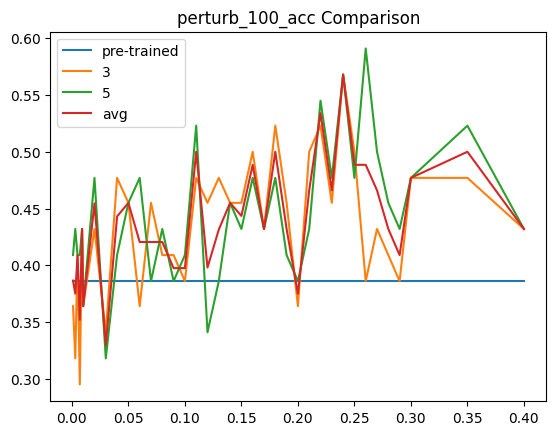

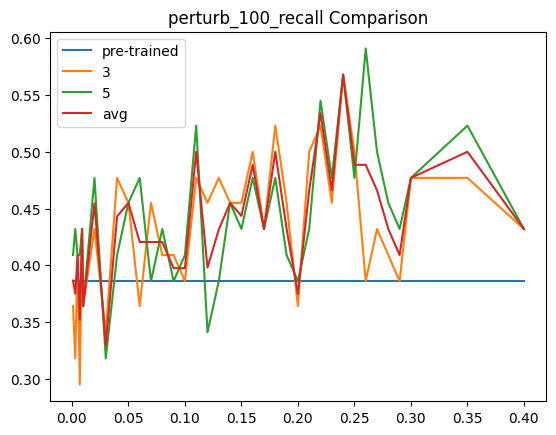

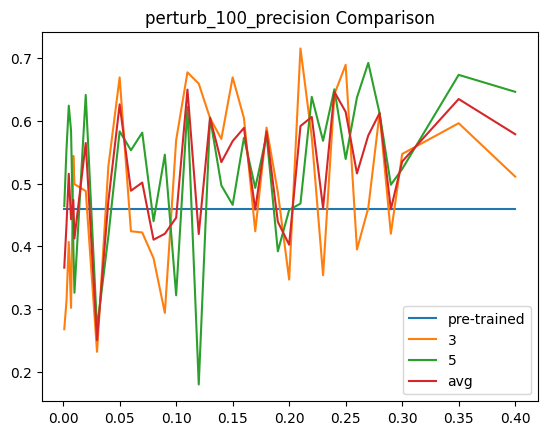

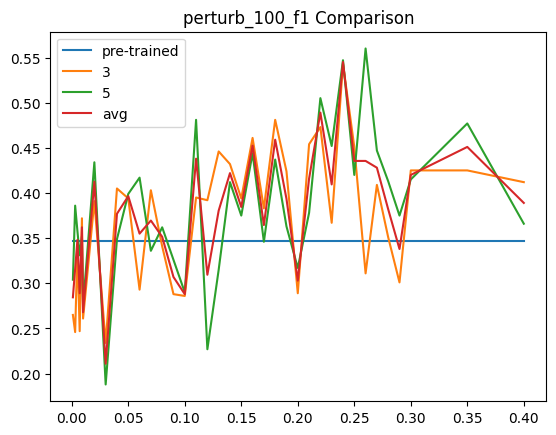

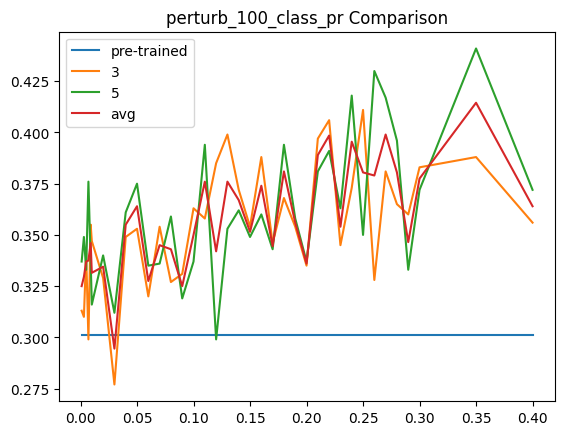

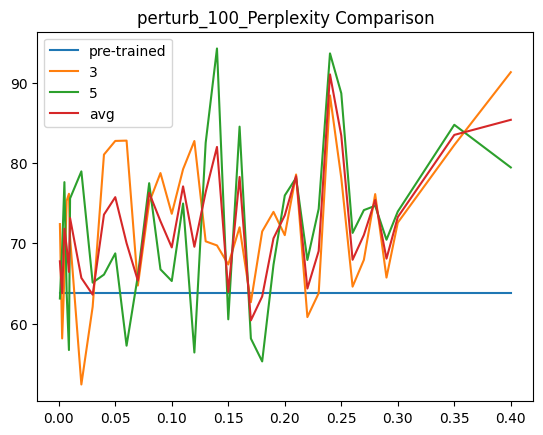

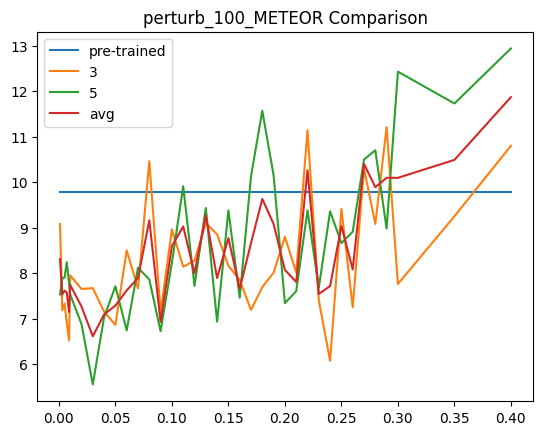

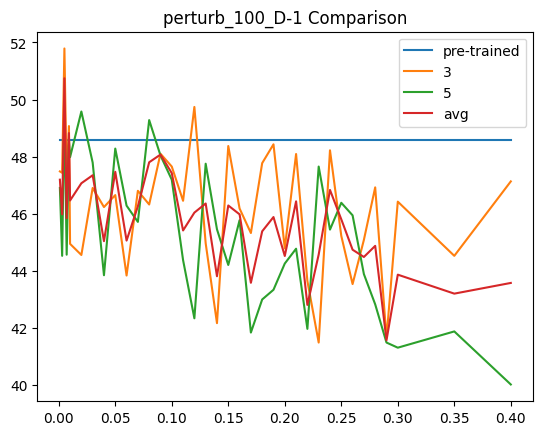

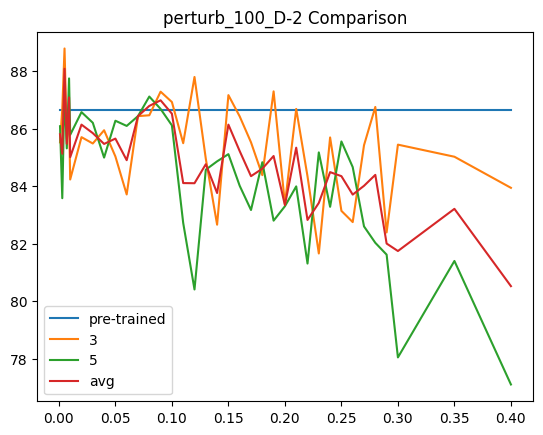

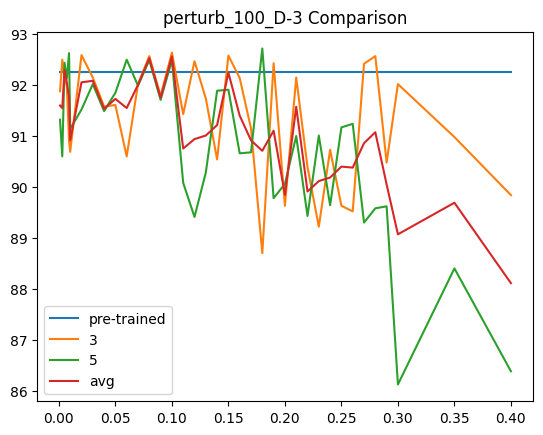

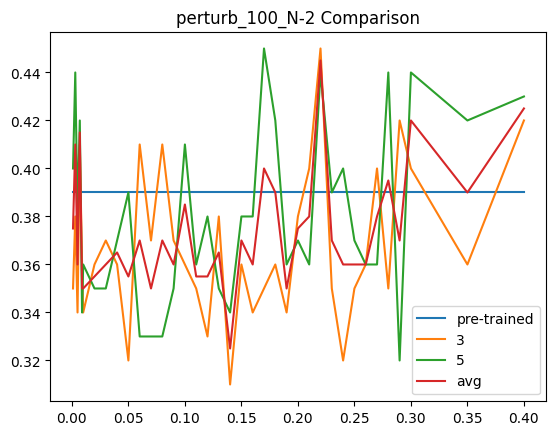

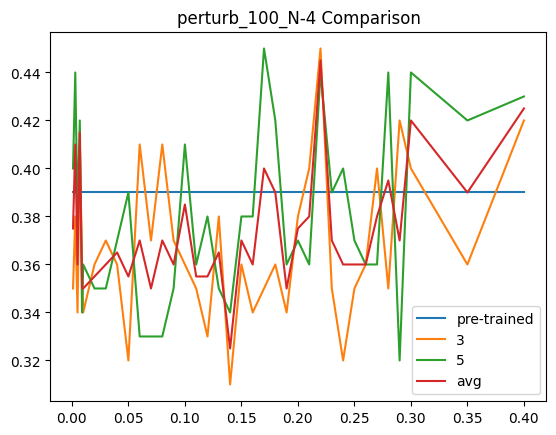

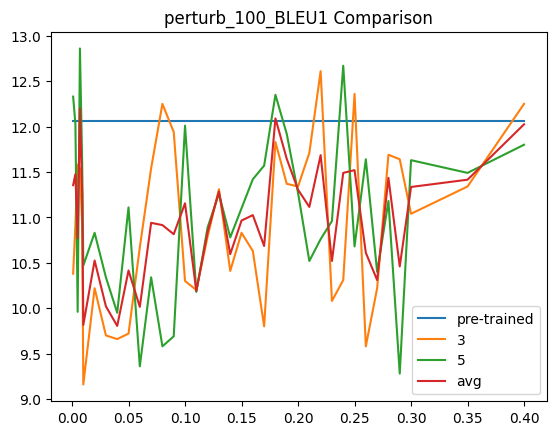

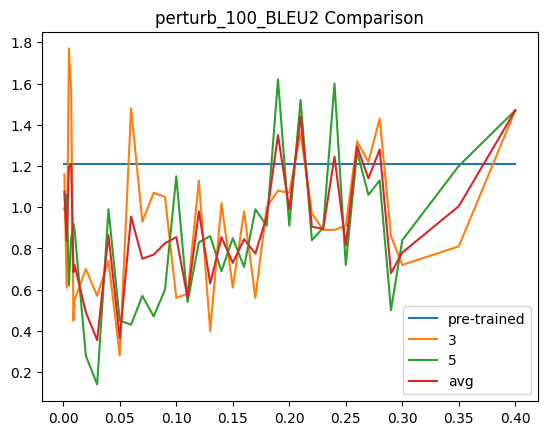

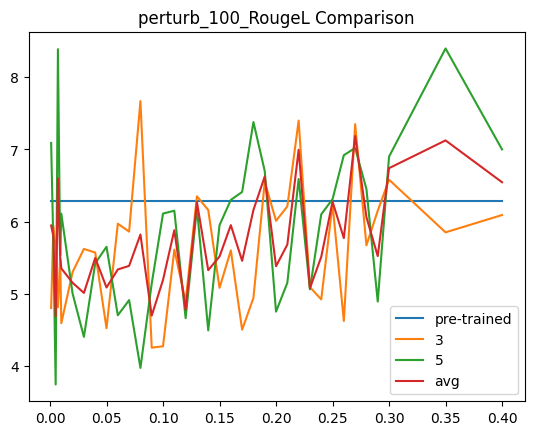

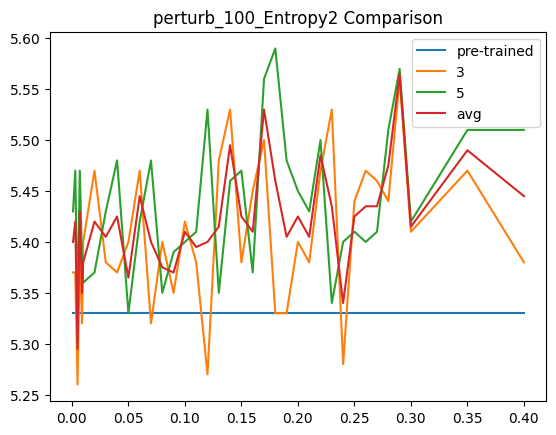

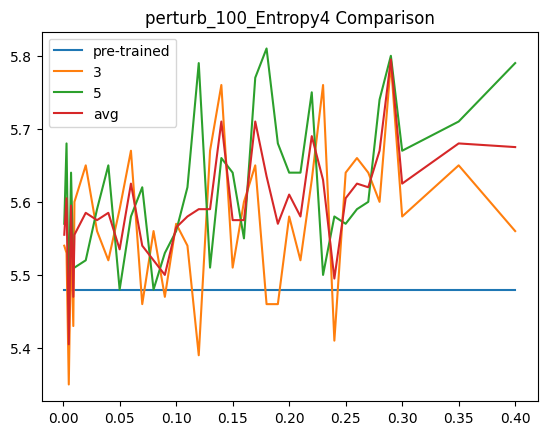

In [6]:
def plot_re(stepsizess,df,df_name,attribute):
    t1 = stepsizess #range(len(df[0]))
    
    plt.plot(t1,[pre_trained[attribute][0]]*len(df[0]),label ='pre-trained')
    for i,i_df in enumerate(df):
        plt.plot(t1,i_df[attribute],
                 label =df_name[i]
                )
    plt.legend()
    plt.title('perturb_100_{} Comparison'.format(attribute))
    plt.show()
columns=['acc','recall','precision','f1','class_pr','Perplexity','METEOR','D-1','D-2','D-3','N-2',
                 'N-4','BLEU1','BLEU2','RougeL','Entropy2', 'Entropy4'] 

for i in columns:
    plot_re(stepsizess,[df_100_3,df_100_5,df_100_35],[3,5,'avg'],i)

In [7]:
stepsizess[:-5]

[0.001,
 0.003,
 0.005,
 0.007,
 0.009,
 0.01,
 0.02,
 0.03,
 0.04,
 0.05,
 0.06,
 0.07,
 0.08,
 0.09,
 0.1,
 0.11,
 0.12,
 0.13,
 0.14,
 0.15,
 0.16,
 0.17,
 0.18,
 0.19,
 0.2,
 0.21,
 0.22,
 0.23,
 0.24,
 0.25,
 0.26,
 0.27]

In [9]:
aa = []
bb = []
for i in stepsizess[:]:
    xx = 0
    for j in [3,5]:
        a= df_create([i],[100,11,22,32],[j])
        xx =xx+a.reset_index(drop=True)
    xx = xx/2
    attri = 'acc'
    top = np.argmax(xx[attri])
    #if top == 0:
        #print(i)
    #    top = list(np.argsort(xx[attri]))[-2]
        #aa.append(i)
    aa.append(top)
    if top == 1:
        bb.append(i)
print(bb)
from collections import Counter
Counter(aa)        

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.001__100__3  0.364   0.364      0.268  0.265     0.313       72.39    9.08   
0.001__11__3   0.341   0.341      0.309  0.269     0.290       83.19    7.42   
0.001__22__3   0.341   0.341      0.244  0.246     0.278       75.91    8.90   
0.001__32__3   0.432   0.432      0.406  0.364     0.343       59.28    8.89   

                 D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  \
0.001__100__3  47.48  85.52  91.88  0.35  0.35  10.38   1.16    4.80   
0.001__11__3   48.00  86.36  91.97  0.30  0.30   8.87   0.87    4.31   
0.001__22__3   47.04  86.67  92.29  0.35  0.35  10.57   1.19    6.00   
0.001__32__3   47.24  84.56  90.13  0.34  0.34  10.38   1.72    4.94   

               Entropy2  Entropy4  
0.001__100__3      5.37      5.54  
0.001__11__3       5.39      5.54  
0.001__22__3       5.41      5.55  
0.001__32__3       5.33      5.50

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.001__100__5  0.409   0.409      0.464  0.304     0.337       63.12    7.53   
0.001__11__5   0.432   0.432      0.337  0.325     0.320       72.66    8.37   
0.001__22__5   0.409   0.409      0.495  0.317     0.347       69.07    7.83   
0.001__32__5   0.386   0.386      0.456  0.303     0.306       77.47    6.07   

                 D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  \
0.001__100__5  46.90  86.08  91.32  0.40  0.40  12.33   0.99    7.09   
0.001__11__5   46.74  86.27  91.43  0.41  0.41  11.66   1.00    7.10   
0.001__22__5   44.22  84.05  91.83  0.40  0.40  12.26   0.97    6.49   
0.001__32__5   50.61  88.00  92.01  0.40  0.40  11.18   0.50    4.62   

               Entropy2  Entropy4  
0.001__100__5      5.43      5.57  
0.001__11__5       5.41      5.55  
0.001__22__5       5.46      5.67  
0.001__32__5       5.22      5.33

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.003__100__3  0.318   0.318      0.314  0.246     0.310       58.15    7.18   
0.003__11__3   0.409   0.409      0.278  0.291     0.321       86.48    7.70   
0.003__22__3   0.386   0.386      0.346  0.313     0.321       56.62    8.47   
0.003__32__3   0.477   0.477      0.528  0.404     0.352       63.69    8.72   

                 D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  \
0.003__100__3  47.43  86.67  92.50  0.38  0.38  10.92   0.61    5.94   
0.003__11__3   50.86  88.03  92.43  0.40  0.40  10.67   0.82    5.00   
0.003__22__3   45.88  85.26  91.42  0.39  0.39  10.84   1.10    6.02   
0.003__32__3   47.84  85.47  91.03  0.40  0.40  11.99   0.89    7.03   

               Entropy2  Entropy4  
0.003__100__3      5.37      5.53  
0.003__11__3       5.29      5.40  
0.003__22__3       5.45      5.62  
0.003__32__3       5.34      5.50

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.003__100__5  0.432   0.432      0.556  0.386     0.349       69.41    7.88   
0.003__11__5   0.455   0.455      0.513  0.383     0.352       67.14    8.93   
0.003__22__5   0.386   0.386      0.388  0.333     0.344       64.44    9.81   
0.003__32__5   0.455   0.455      0.464  0.385     0.334       62.38    9.37   

                 D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  \
0.003__100__5  44.52  83.58  90.60  0.44  0.44  12.03   1.06    5.65   
0.003__11__5   46.26  86.49  92.43  0.38  0.38  11.40   0.73    5.01   
0.003__22__5   45.83  85.40  91.58  0.40  0.40  11.25   0.43    6.95   
0.003__32__5   49.58  87.38  91.83  0.42  0.42  12.03   0.74    6.64   

               Entropy2  Entropy4  
0.003__100__5      5.47      5.68  
0.003__11__5       5.45      5.60  
0.003__22__5       5.44      5.62  
0.003__32__5       5.35      5.46

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.005__100__3  0.409   0.409      0.407  0.338     0.341       66.00    7.33   
0.005__11__3   0.500   0.500      0.616  0.445     0.355       66.20   10.44   
0.005__22__3   0.477   0.477      0.523  0.414     0.312       78.78    6.33   
0.005__32__3   0.432   0.432      0.614  0.362     0.354       59.89    8.69   

                 D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  \
0.005__100__3  51.79  88.78  92.16  0.34  0.34  11.58   1.77    5.63   
0.005__11__3   43.70  83.57  90.92  0.42  0.42  12.02   1.04    7.07   
0.005__22__3   50.22  86.95  91.76  0.35  0.35  12.26   0.80    5.19   
0.005__32__3   48.51  86.41  91.31  0.40  0.40  11.81   1.17    4.57   

               Entropy2  Entropy4  
0.005__100__3      5.26      5.35  
0.005__11__3       5.50      5.70  
0.005__22__3       5.23      5.35  
0.005__32__3       5.37      5.50

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.005__100__5  0.409   0.409      0.624  0.358     0.333       77.61    7.90   
0.005__11__5   0.341   0.341      0.233  0.235     0.305       61.95    7.80   
0.005__22__5   0.318   0.318      0.387  0.258     0.328       63.76   12.05   
0.005__32__5   0.295   0.295      0.179  0.191     0.295       60.65    8.43   

                 D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  \
0.005__100__5  49.70  87.37  92.44  0.38  0.38   9.96   0.62    3.74   
0.005__11__5   46.81  86.83  92.88  0.33  0.33  10.11   0.57    5.31   
0.005__22__5   43.93  83.99  90.71  0.40  0.40  11.57   0.66    5.20   
0.005__32__5   49.67  87.24  92.30  0.35  0.35  10.79   1.25    5.97   

               Entropy2  Entropy4  
0.005__100__5      5.33      5.46  
0.005__11__5       5.45      5.60  
0.005__22__5       5.48      5.66  
0.005__32__5       5.29      5.41

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.007__100__3  0.295   0.295      0.302  0.247     0.299       75.29    6.90   
0.007__11__3   0.364   0.364      0.333  0.272     0.294       57.26    9.22   
0.007__22__3   0.386   0.386      0.332  0.294     0.305       71.33    5.77   
0.007__32__3   0.409   0.409      0.418  0.350     0.342       64.79    8.58   

                 D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  \
0.007__100__3  47.12  85.63  91.98  0.41  0.41  11.54   1.57    4.81   
0.007__11__3   43.56  84.28  91.76  0.37  0.37  11.30   0.89    6.90   
0.007__22__3   48.31  86.89  92.29  0.34  0.34   9.77   0.61    4.92   
0.007__32__3   47.64  85.81  91.96  0.36  0.36  11.55   1.01    5.02   

               Entropy2  Entropy4  
0.007__100__3      5.39      5.55  
0.007__11__3       5.53      5.73  
0.007__22__3       5.36      5.50  
0.007__32__3       5.38      5.54

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.007__100__5  0.409   0.409      0.584  0.331     0.376       63.79    8.24   
0.007__11__5   0.364   0.364      0.346  0.280     0.330       61.01    7.99   
0.007__22__5   0.477   0.477      0.688  0.410     0.343       68.52    8.66   
0.007__32__5   0.409   0.409      0.589  0.304     0.322       69.10    8.02   

                 D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  \
0.007__100__5  44.56  85.31  92.13  0.42  0.42  12.86   0.85    8.39   
0.007__11__5   48.14  87.20  91.87  0.37  0.37  11.37   1.54    4.21   
0.007__22__5   49.57  87.55  92.41  0.40  0.40  11.79   0.62    5.61   
0.007__32__5   47.64  86.83  91.68  0.36  0.36  10.85   0.98    5.56   

               Entropy2  Entropy4  
0.007__100__5      5.47      5.64  
0.007__11__5       5.37      5.50  
0.007__22__5       5.33      5.45  
0.007__32__5       5.42      5.55

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.009__100__3  0.432   0.432      0.544  0.372     0.355       76.16    6.52   
0.009__11__3   0.409   0.409      0.409  0.373     0.329       65.37    6.50   
0.009__22__3   0.318   0.318      0.338  0.262     0.302       65.15    8.83   
0.009__32__3   0.500   0.500      0.615  0.474     0.351       71.34    8.50   

                 D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  \
0.009__100__3  49.07  86.42  90.90  0.36  0.36  10.91   0.45    5.49   
0.009__11__3   48.47  87.86  92.68  0.37  0.37  10.42   0.74    4.39   
0.009__22__3   46.79  85.08  90.99  0.41  0.41  11.90   0.56    6.55   
0.009__32__3   50.02  87.30  92.40  0.33  0.33  11.30   0.65    5.62   

               Entropy2  Entropy4  
0.009__100__3      5.32      5.43  
0.009__11__3       5.37      5.50  
0.009__22__3       5.39      5.56  
0.009__32__3       5.30      5.43

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.009__100__5  0.432   0.432      0.404  0.352     0.337       56.71    7.77   
0.009__11__5   0.455   0.455      0.608  0.403     0.350       77.07    6.84   
0.009__22__5   0.432   0.432      0.447  0.339     0.333       51.38   10.42   
0.009__32__5   0.341   0.341      0.248  0.256     0.303       61.55    7.53   

                 D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  \
0.009__100__5  48.58  87.74  92.63  0.34  0.34  11.59   0.92    5.53   
0.009__11__5   47.55  85.43  91.17  0.33  0.33  10.50   0.44    3.86   
0.009__22__5   42.42  84.44  91.32  0.44  0.44  12.92   1.32    7.28   
0.009__32__5   48.35  88.20  92.79  0.40  0.40  12.37   0.93    6.21   

               Entropy2  Entropy4  
0.009__100__5      5.38      5.51  
0.009__11__5       5.36      5.52  
0.009__22__5       5.55      5.74  
0.009__32__5       5.35      5.46

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.01__100__3  0.364   0.364      0.499  0.261     0.347       70.70    7.95   
0.01__11__3   0.409   0.409      0.502  0.352     0.343       62.92    6.87   
0.01__22__3   0.455   0.455      0.549  0.392     0.335       58.85    7.24   
0.01__32__3   0.318   0.318      0.302  0.223     0.325       73.13    6.02   

                D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  Entropy2  \
0.01__100__3  44.94  84.23  90.69  0.34  0.34   9.16   0.55    4.59      5.40   
0.01__11__3   46.16  87.01  91.99  0.37  0.37  10.58   0.28    4.17      5.48   
0.01__22__3   48.12  86.82  92.03  0.41  0.41  11.00   0.92    5.98      5.36   
0.01__32__3   51.31  89.27  93.22  0.32  0.32   9.30   0.50    3.55      5.27   

              Entropy4  
0.01__100__3      5.60  
0.01__11__3       5.61  
0.01__22__3       5.51  
0.01__32__3       5.35

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.01__100__5  0.364   0.364      0.326  0.275     0.316       75.58    7.53   
0.01__11__5   0.409   0.409      0.502  0.348     0.365       82.14    7.61   
0.01__22__5   0.364   0.364      0.566  0.270     0.305       69.29    7.99   
0.01__32__5   0.432   0.432      0.389  0.327     0.315       67.09    7.12   

                D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  Entropy2  \
0.01__100__5  47.98  85.78  91.14  0.36  0.36  10.47   0.89    6.11      5.36   
0.01__11__5   48.55  86.48  91.59  0.38  0.38  11.52   1.01    4.49      5.36   
0.01__22__5   45.86  86.38  92.98  0.35  0.35  11.26   0.79    4.96      5.50   
0.01__32__5   49.88  87.74  92.24  0.35  0.35  10.79   0.78    4.95      5.30   

              Entropy4  
0.01__100__5      5.51  
0.01__11__5       5.50  
0.01__22__5       5.67  
0.01__32__5       5.41

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.02__100__3  0.432   0.432      0.488  0.391     0.329       52.42    7.65   
0.02__11__3   0.318   0.318      0.223  0.221     0.325       60.77    8.52   
0.02__22__3   0.386   0.386      0.296  0.295     0.305       71.66    7.15   
0.02__32__3   0.341   0.341      0.270  0.261     0.313       70.69    8.01   

                D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  Entropy2  \
0.02__100__3  44.55  85.70  92.59  0.36  0.36  10.22   0.70    5.30      5.47   
0.02__11__3   46.13  84.91  91.24  0.40  0.40  11.17   1.05    5.49      5.44   
0.02__22__3   47.54  86.52  91.90  0.39  0.39  10.81   0.76    6.38      5.38   
0.02__32__3   48.75  87.06  92.34  0.36  0.36  10.81   1.06    5.12      5.37   

              Entropy4  
0.02__100__3      5.65  
0.02__11__3       5.63  
0.02__22__3       5.52  
0.02__32__3       5.51

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.02__100__5  0.477   0.477      0.641  0.434     0.340       78.95    6.88   
0.02__11__5   0.386   0.386      0.336  0.289     0.344       63.06    7.97   
0.02__22__5   0.386   0.386      0.420  0.308     0.334       77.15    8.17   
0.02__32__5   0.477   0.477      0.558  0.428     0.362       71.75    7.88   

                D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  Entropy2  \
0.02__100__5  49.58  86.57  91.52  0.35  0.35  10.83   0.28    5.00      5.37   
0.02__11__5   48.06  87.18  92.53  0.31  0.31  10.79   0.73    5.83      5.41   
0.02__22__5   48.48  87.35  92.74  0.37  0.37  10.33   0.62    4.98      5.35   
0.02__32__5   47.01  86.35  91.81  0.37  0.37  10.26   0.29    4.68      5.40   

              Entropy4  
0.02__100__5      5.52  
0.02__11__5       5.55  
0.02__22__5       5.49  
0.02__32__5       5.55

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.03__100__3  0.341   0.341      0.232  0.234     0.277       62.10    7.67   
0.03__11__3   0.341   0.341      0.539  0.291     0.311       51.70    7.02   
0.03__22__3   0.455   0.455      0.523  0.394     0.350       77.37    7.80   
0.03__32__3   0.432   0.432      0.514  0.398     0.314       60.85    7.47   

                D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  Entropy2  \
0.03__100__3  46.90  85.48  92.15  0.37  0.37   9.70   0.57    5.62      5.38   
0.03__11__3   47.15  86.27  92.70  0.38  0.38  11.32   1.15    4.93      5.40   
0.03__22__3   47.73  87.12  92.41  0.35  0.35  11.91   1.03    6.78      5.42   
0.03__32__3   46.82  85.99  91.44  0.37  0.37  10.29   0.73    4.96      5.43   

              Entropy4  
0.03__100__3      5.56  
0.03__11__3       5.56  
0.03__22__3       5.55  
0.03__32__3       5.58

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.03__100__5  0.318   0.318      0.269  0.188     0.312       65.10    5.55   
0.03__11__5   0.409   0.409      0.516  0.342     0.360       72.12    5.19   
0.03__22__5   0.364   0.364      0.264  0.262     0.311       57.81    6.53   
0.03__32__5   0.318   0.318      0.264  0.251     0.276       74.98    5.91   

                D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  Entropy2  \
0.03__100__5  47.79  86.20  92.02  0.35  0.35  10.34   0.14    4.40      5.43   
0.03__11__5   48.41  86.28  91.41  0.37  0.37   9.20   0.61    3.89      5.29   
0.03__22__5   45.41  87.06  93.11  0.38  0.38  10.81   0.97    4.98      5.50   
0.03__32__5   48.70  86.16  91.47  0.35  0.35  10.65   1.74    5.37      5.28   

              Entropy4  
0.03__100__5      5.59  
0.03__11__5       5.43  
0.03__22__5       5.66  
0.03__32__5       5.41

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.04__100__3  0.477   0.477      0.527  0.405     0.349       81.04    7.15   
0.04__11__3   0.455   0.455      0.467  0.364     0.339       79.30    6.20   
0.04__22__3   0.455   0.455      0.539  0.416     0.364       67.46    6.50   
0.04__32__3   0.432   0.432      0.606  0.334     0.323       71.93    8.68   

                D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  Entropy2  \
0.04__100__3  46.23  85.94  91.58  0.36  0.36   9.66   0.74    5.57      5.37   
0.04__11__3   47.59  86.87  91.84  0.39  0.39  10.81   1.17    4.36      5.39   
0.04__22__3   46.78  85.70  91.60  0.33  0.33   9.91   0.14    4.29      5.38   
0.04__32__3   46.12  86.60  92.43  0.36  0.36  11.86   1.76    7.62      5.40   

              Entropy4  
0.04__100__3      5.52  
0.04__11__3       5.52  
0.04__22__3       5.54  
0.04__32__3       5.55

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.04__100__5  0.409   0.409      0.416  0.349     0.361       66.10    7.03   
0.04__11__5   0.364   0.364      0.350  0.305     0.338       70.38    7.55   
0.04__22__5   0.364   0.364      0.374  0.338     0.315       60.14    7.23   
0.04__32__5   0.318   0.318      0.526  0.260     0.320       79.22    8.70   

                D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  Entropy2  \
0.04__100__5  43.84  84.99  91.49  0.37  0.37   9.95   0.99    5.42      5.48   
0.04__11__5   47.40  86.78  92.70  0.33  0.33   8.05   0.30    4.65      5.38   
0.04__22__5   47.34  85.78  92.27  0.33  0.33   9.45   0.45    5.84      5.37   
0.04__32__5   46.09  84.77  91.46  0.39  0.39  10.49   1.16    5.90      5.39   

              Entropy4  
0.04__100__5      5.65  
0.04__11__5       5.53  
0.04__22__5       5.53  
0.04__32__5       5.57

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.05__100__3  0.455   0.455      0.669  0.394     0.353       82.74    6.86   
0.05__11__3   0.364   0.364      0.513  0.288     0.321       97.62    7.62   
0.05__22__3   0.432   0.432      0.369  0.330     0.316       67.40    6.30   
0.05__32__3   0.386   0.386      0.388  0.295     0.298       62.49    6.23   

                D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  Entropy2  \
0.05__100__3  46.65  85.03  91.61  0.32  0.32   9.72   0.28    4.52      5.40   
0.05__11__3   47.19  85.72  91.30  0.34  0.34  10.97   1.04    5.02      5.34   
0.05__22__3   47.90  85.67  91.59  0.33  0.33   8.55   0.29    3.38      5.37   
0.05__32__3   46.59  84.94  91.72  0.40  0.40  11.21   1.28    4.46      5.41   

              Entropy4  
0.05__100__3      5.59  
0.05__11__3       5.49  
0.05__22__3       5.52  
0.05__32__3       5.60

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.05__100__5  0.455   0.455      0.583  0.399     0.375       68.74    7.71   
0.05__11__5   0.409   0.409      0.311  0.313     0.292       71.75    8.12   
0.05__22__5   0.409   0.409      0.409  0.324     0.330       62.44   13.13   
0.05__32__5   0.409   0.409      0.517  0.305     0.334       63.36    7.95   

                D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  Entropy2  \
0.05__100__5  48.28  86.27  91.85  0.39  0.39  11.11   0.45    5.65      5.33   
0.05__11__5   48.77  86.25  91.83  0.33  0.33   9.91   0.87    5.36      5.35   
0.05__22__5   45.15  85.52  91.33  0.47  0.47  12.65   1.64    7.44      5.50   
0.05__32__5   48.03  86.15  91.29  0.36  0.36  12.17   1.55    4.72      5.34   

              Entropy4  
0.05__100__5      5.48  
0.05__11__5       5.50  
0.05__22__5       5.67  
0.05__32__5       5.48

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.06__100__3  0.364   0.364      0.424  0.293     0.320       82.78    8.50   
0.06__11__3   0.364   0.364      0.393  0.291     0.289       68.22    8.44   
0.06__22__3   0.409   0.409      0.481  0.358     0.390       68.67    8.54   
0.06__32__3   0.341   0.341      0.415  0.280     0.328       58.76    9.02   

                D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  Entropy2  \
0.06__100__3  43.83  83.71  90.60  0.41  0.41  10.67   1.48    5.97      5.47   
0.06__11__3   50.39  87.24  91.42  0.43  0.43  12.21   1.54    7.30      5.26   
0.06__22__3   46.45  86.74  92.42  0.40  0.40  13.12   1.77    7.88      5.40   
0.06__32__3   46.38  85.31  90.79  0.37  0.37  10.56   0.85    5.11      5.40   

              Entropy4  
0.06__100__3      5.67  
0.06__11__3       5.37  
0.06__22__3       5.56  
0.06__32__3       5.55

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.06__100__5  0.477   0.477      0.553  0.417     0.335       57.25    6.74   
0.06__11__5   0.386   0.386      0.407  0.315     0.313       68.65    7.29   
0.06__22__5   0.364   0.364      0.392  0.288     0.321       87.65    6.24   
0.06__32__5   0.386   0.386      0.290  0.302     0.291       67.40    8.55   

                D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  Entropy2  \
0.06__100__5  46.28  86.09  92.50  0.33  0.33   9.36   0.43    4.70      5.42   
0.06__11__5   49.20  86.84  92.38  0.31  0.31  10.57   0.79    4.03      5.34   
0.06__22__5   51.17  87.04  90.60  0.32  0.32  10.66   0.84    3.78      5.19   
0.06__32__5   46.25  87.12  92.54  0.35  0.35  10.64   0.90    4.52      5.44   

              Entropy4  
0.06__100__5      5.58  
0.06__11__5       5.48  
0.06__22__5       5.29  
0.06__32__5       5.58

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.07__100__3  0.455   0.455      0.422  0.403     0.354       64.74    7.66   
0.07__11__3   0.409   0.409      0.443  0.322     0.340       70.14    8.79   
0.07__22__3   0.409   0.409      0.516  0.342     0.337       71.07    7.14   
0.07__32__3   0.455   0.455      0.580  0.399     0.362       66.58    7.60   

                D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  Entropy2  \
0.07__100__3  46.80  86.43  92.02  0.37  0.37  11.54   0.93    5.86      5.32   
0.07__11__3   47.83  85.75  92.05  0.39  0.39  11.48   0.85    6.06      5.38   
0.07__22__3   49.83  87.24  92.54  0.39  0.39  10.88   0.79    4.69      5.31   
0.07__32__3   43.04  85.16  92.24  0.36  0.36  11.24   1.07    6.25      5.54   

              Entropy4  
0.07__100__3      5.46  
0.07__11__3       5.55  
0.07__22__3       5.46  
0.07__32__3       5.74

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.07__100__5  0.386   0.386      0.581  0.336     0.336       65.96    8.12   
0.07__11__5   0.409   0.409      0.369  0.326     0.343       74.80    5.37   
0.07__22__5   0.409   0.409      0.462  0.330     0.364       84.72    9.52   
0.07__32__5   0.409   0.409      0.311  0.305     0.330       75.50    7.68   

                D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  Entropy2  \
0.07__100__5  45.71  86.43  91.99  0.33  0.33  10.34   0.57    4.91      5.48   
0.07__11__5   49.78  87.80  92.16  0.33  0.33  10.98   0.48    5.44      5.31   
0.07__22__5   46.95  85.58  91.29  0.35  0.35  12.13   1.15    6.55      5.36   
0.07__32__5   45.40  83.12  89.59  0.35  0.35  11.32   1.21    5.80      5.41   

              Entropy4  
0.07__100__5      5.62  
0.07__11__5       5.43  
0.07__22__5       5.51  
0.07__32__5       5.60

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.08__100__3  0.409   0.409      0.381  0.341     0.327       75.07   10.46   
0.08__11__3   0.432   0.432      0.500  0.366     0.358       56.60    7.36   
0.08__22__3   0.409   0.409      0.407  0.305     0.341       76.21    8.25   
0.08__32__3   0.500   0.500      0.604  0.469     0.392       81.37    7.23   

                D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  Entropy2  \
0.08__100__3  46.32  86.46  92.57  0.41  0.41  12.25   1.07    7.67      5.40   
0.08__11__3   46.10  86.25  92.53  0.33  0.33   9.58   0.90    4.40      5.44   
0.08__22__3   49.58  87.53  91.83  0.35  0.35  11.65   0.76    5.42      5.34   
0.08__32__3   46.79  84.17  89.71  0.34  0.34  10.29   1.14    4.11      5.34   

              Entropy4  
0.08__100__3      5.56  
0.08__11__3       5.60  
0.08__22__3       5.46  
0.08__32__3       5.50

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.08__100__5  0.432   0.432      0.440  0.362     0.359       77.48    7.86   
0.08__11__5   0.364   0.364      0.248  0.270     0.309       56.54    6.46   
0.08__22__5   0.364   0.364      0.240  0.262     0.306       71.30    6.46   
0.08__32__5   0.455   0.455      0.516  0.398     0.354       56.22    9.85   

                D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  Entropy2  \
0.08__100__5  49.28  87.11  92.49  0.33  0.33   9.58   0.47    3.97      5.35   
0.08__11__5   45.38  84.86  91.45  0.35  0.35   9.84   1.13    4.75      5.41   
0.08__22__5   45.07  84.40  91.32  0.30  0.30   8.96   0.40    4.65      5.46   
0.08__32__5   46.19  83.97  89.72  0.39  0.39  12.08   1.07    6.23      5.40   

              Entropy4  
0.08__100__5      5.48  
0.08__11__5       5.59  
0.08__22__5       5.65  
0.08__32__5       5.57

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.09__100__3  0.409   0.409      0.294  0.288     0.331       78.74    7.13   
0.09__11__3   0.364   0.364      0.354  0.284     0.366       62.71    7.82   
0.09__22__3   0.432   0.432      0.365  0.327     0.326       71.78    7.93   
0.09__32__3   0.409   0.409      0.311  0.314     0.294       82.76    7.82   

                D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  Entropy2  \
0.09__100__3  48.10  87.28  91.79  0.37  0.37  11.94   1.05    4.25      5.35   
0.09__11__3   44.13  85.19  91.45  0.35  0.35  11.15   0.69    6.17      5.48   
0.09__22__3   47.31  86.92  92.32  0.39  0.39  12.01   1.51    6.20      5.38   
0.09__32__3   48.65  84.65  90.68  0.40  0.40  11.08   1.17    6.00      5.30   

              Entropy4  
0.09__100__3      5.47  
0.09__11__3       5.66  
0.09__22__3       5.52  
0.09__32__3       5.48

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.09__100__5  0.386   0.386      0.546  0.326     0.319       66.75    6.72   
0.09__11__5   0.500   0.500      0.569  0.470     0.381       60.32   10.27   
0.09__22__5   0.432   0.432      0.489  0.382     0.353       57.55    8.99   
0.09__32__5   0.386   0.386      0.436  0.295     0.322       52.84    9.78   

                D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  Entropy2  \
0.09__100__5  48.04  86.68  91.71  0.35  0.35   9.69   0.60    5.14      5.39   
0.09__11__5   47.37  86.62  92.18  0.38  0.38  11.95   0.90    6.29      5.40   
0.09__22__5   44.21  84.16  90.44  0.38  0.38  11.51   1.10    5.72      5.46   
0.09__32__5   45.17  84.58  91.47  0.39  0.39  10.20   0.95    5.92      5.47   

              Entropy4  
0.09__100__5      5.53  
0.09__11__5       5.55  
0.09__22__5       5.64  
0.09__32__5       5.65

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.1__100__3  0.386   0.386      0.569  0.286     0.363       73.67    8.96   
0.1__11__3   0.386   0.386      0.642  0.319     0.319       57.43    8.25   
0.1__22__3   0.477   0.477      0.489  0.426     0.381       59.21    9.76   
0.1__32__3   0.432   0.432      0.498  0.382     0.343       57.38    7.63   

               D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  Entropy2  \
0.1__100__3  47.65  86.92  92.64  0.36  0.36  10.30   0.56    4.27      5.42   
0.1__11__3   44.80  85.80  92.10  0.37  0.37  11.37   1.23    5.48      5.48   
0.1__22__3   46.01  84.29  89.99  0.40  0.40  11.65   0.82    5.55      5.43   
0.1__32__3   47.18  85.53  91.34  0.31  0.31  10.60   0.70    3.62      5.39   

             Entropy4  
0.1__100__3      5.57  
0.1__11__3       5.64  
0.1__22__3       5.60  
0.1__32__3       5.54

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.1__100__5  0.409   0.409      0.322  0.290     0.337       65.30    8.23   
0.1__11__5   0.477   0.477      0.546  0.411     0.335       61.71   10.30   
0.1__22__5   0.409   0.409      0.382  0.346     0.331       75.71    7.49   
0.1__32__5   0.409   0.409      0.441  0.368     0.390       68.55    7.36   

               D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  Entropy2  \
0.1__100__5  47.19  86.11  92.49  0.41  0.41  12.01   1.15    6.11      5.40   
0.1__11__5   44.06  83.17  90.55  0.36  0.36  11.30   1.40    5.85      5.41   
0.1__22__5   46.42  86.17  92.48  0.32  0.32  10.72   0.43    5.48      5.44   
0.1__32__5   50.13  87.60  91.70  0.35  0.35  10.80   1.09    5.32      5.29   

             Entropy4  
0.1__100__5      5.56  
0.1__11__5       5.62  
0.1__22__5       5.61  
0.1__32__5       5.39

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.11__100__3  0.477   0.477      0.677  0.395     0.358       79.22    8.14   
0.11__11__3   0.364   0.364      0.254  0.240     0.289       65.86    7.47   
0.11__22__3   0.409   0.409      0.423  0.354     0.333       65.89    8.48   
0.11__32__3   0.386   0.386      0.419  0.334     0.329       73.68    9.10   

                D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  Entropy2  \
0.11__100__3  46.45  85.49  91.43  0.35  0.35  10.20   0.58    5.61      5.38   
0.11__11__3   47.35  86.34  91.77  0.38  0.38  10.53   1.62    6.44      5.41   
0.11__22__3   43.67  85.05  91.94  0.36  0.36  11.64   1.19    5.94      5.56   
0.11__32__3   50.05  86.45  91.50  0.37  0.37  11.08   1.08    5.33      5.29   

              Entropy4  
0.11__100__3      5.54  
0.11__11__3       5.56  
0.11__22__3       5.75  
0.11__32__3       5.42

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.11__100__5  0.523   0.523      0.622  0.481     0.394       74.95    9.91   
0.11__11__5   0.432   0.432      0.416  0.363     0.342       72.78    9.61   
0.11__22__5   0.455   0.455      0.490  0.396     0.379       57.33   10.22   
0.11__32__5   0.455   0.455      0.585  0.408     0.332       55.68    7.94   

                D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  Entropy2  \
0.11__100__5  44.37  82.72  90.08  0.36  0.36  10.18   0.54    6.15      5.41   
0.11__11__5   48.86  87.33  92.49  0.43  0.43  12.32   1.06    7.29      5.35   
0.11__22__5   43.49  84.11  90.54  0.43  0.43  12.68   1.83    7.81      5.52   
0.11__32__5   45.29  86.25  92.99  0.39  0.39   9.74   0.69    5.18      5.52   

              Entropy4  
0.11__100__5      5.62  
0.11__11__5       5.47  
0.11__22__5       5.69  
0.11__32__5       5.69

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.12__100__3  0.455   0.455      0.659  0.392     0.385       82.73    8.27   
0.12__11__3   0.386   0.386      0.402  0.304     0.339       72.74    8.34   
0.12__22__3   0.386   0.386      0.279  0.280     0.329       62.81    6.56   
0.12__32__3   0.364   0.364      0.424  0.293     0.337       76.45   10.96   

                D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  Entropy2  \
0.12__100__3  49.74  87.79  92.47  0.33  0.33  10.79   1.13    4.89      5.27   
0.12__11__3   49.34  87.19  91.61  0.38  0.38  12.30   1.57    5.73      5.30   
0.12__22__3   47.08  85.10  91.13  0.30  0.30   9.03   0.29    5.66      5.36   
0.12__32__3   46.96  86.70  92.34  0.38  0.38  11.89   1.07    6.23      5.37   

              Entropy4  
0.12__100__3      5.39  
0.12__11__3       5.42  
0.12__22__3       5.53  
0.12__32__3       5.52

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.12__100__5  0.341   0.341      0.180  0.227     0.299       56.40    7.72   
0.12__11__5   0.364   0.364      0.211  0.225     0.314       68.99   10.37   
0.12__22__5   0.409   0.409      0.425  0.348     0.365       73.37    8.49   
0.12__32__5   0.386   0.386      0.620  0.311     0.323       62.36    9.11   

                D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  Entropy2  \
0.12__100__5  42.33  80.41  89.41  0.38  0.38  10.89   0.83    4.66      5.53   
0.12__11__5   48.07  86.45  92.06  0.44  0.44  14.02   1.00    8.66      5.38   
0.12__22__5   48.56  87.80  92.66  0.41  0.41  11.81   1.50    5.16      5.38   
0.12__32__5   46.01  84.44  90.79  0.33  0.33  11.05   0.70    4.41      5.40   

              Entropy4  
0.12__100__5      5.79  
0.12__11__5       5.53  
0.12__22__5       5.51  
0.12__32__5       5.57

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.13__100__3  0.477   0.477      0.604  0.446     0.399       70.24    9.10   
0.13__11__3   0.432   0.432      0.340  0.330     0.323       70.07    9.57   
0.13__22__3   0.477   0.477      0.695  0.408     0.351       78.02    8.11   
0.13__32__3   0.432   0.432      0.666  0.336     0.324       66.20    6.99   

                D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  Entropy2  \
0.13__100__3  44.96  84.95  91.74  0.38  0.38  11.31   0.40    6.35      5.48   
0.13__11__3   48.28  87.17  92.34  0.40  0.40  11.93   1.14    6.56      5.42   
0.13__22__3   47.28  85.01  89.73  0.35  0.35  10.73   1.45    5.61      5.31   
0.13__32__3   44.52  83.17  90.12  0.36  0.36  10.28   0.55    4.16      5.44   

              Entropy4  
0.13__100__3      5.67  
0.13__11__3       5.57  
0.13__22__3       5.44  
0.13__32__3       5.65

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.13__100__5  0.386   0.386      0.605  0.315     0.353       82.51    9.43   
0.13__11__5   0.409   0.409      0.397  0.371     0.333       71.38    8.25   
0.13__22__5   0.523   0.523      0.699  0.452     0.385       58.90    9.08   
0.13__32__5   0.386   0.386      0.451  0.293     0.335       55.27    9.60   

                D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  Entropy2  \
0.13__100__5  47.75  84.57  90.28  0.35  0.35  11.26   0.86    6.19      5.35   
0.13__11__5   46.54  84.13  90.96  0.39  0.39  12.07   1.67    5.55      5.38   
0.13__22__5   42.95  82.92  90.22  0.41  0.41  12.36   1.54    6.83      5.53   
0.13__32__5   47.15  85.30  90.20  0.42  0.42  12.15   1.81    6.34      5.34   

              Entropy4  
0.13__100__5      5.51  
0.13__11__5       5.57  
0.13__22__5       5.74  
0.13__32__5       5.48

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.14__100__3  0.455   0.455      0.571  0.432     0.372       69.73    8.85   
0.14__11__3   0.455   0.455      0.451  0.370     0.354       76.81    5.50   
0.14__22__3   0.409   0.409      0.293  0.320     0.323       57.15    9.18   
0.14__32__3   0.477   0.477      0.645  0.434     0.374       74.35    7.15   

                D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  Entropy2  \
0.14__100__3  42.16  82.66  90.54  0.31  0.31  10.41   1.02    6.16      5.53   
0.14__11__3   48.51  88.48  93.40  0.34  0.34  10.32   0.78    3.97      5.40   
0.14__22__3   42.72  83.32  90.77  0.36  0.36   9.96   0.90    5.99      5.55   
0.14__32__3   47.00  85.87  91.44  0.37  0.37  10.48   0.72    4.72      5.40   

              Entropy4  
0.14__100__3      5.76  
0.14__11__3       5.52  
0.14__22__3       5.76  
0.14__32__3       5.55

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.14__100__5  0.455   0.455      0.497  0.412     0.362       94.25    6.93   
0.14__11__5   0.386   0.386      0.589  0.311     0.354       64.39    8.01   
0.14__22__5   0.455   0.455      0.493  0.426     0.354       67.86    8.81   
0.14__32__5   0.295   0.295      0.187  0.208     0.306       58.67    8.23   

                D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  Entropy2  \
0.14__100__5  45.45  84.86  91.89  0.34  0.34  10.78   0.69    4.49      5.46   
0.14__11__5   46.28  85.79  92.03  0.37  0.37  11.36   1.25    4.87      5.43   
0.14__22__5   45.40  84.40  91.10  0.38  0.38  11.77   1.27    5.60      5.43   
0.14__32__5   42.53  82.97  91.03  0.36  0.36  10.45   0.63    5.70      5.54   

              Entropy4  
0.14__100__5      5.66  
0.14__11__5       5.60  
0.14__22__5       5.61  
0.14__32__5       5.77

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.15__100__3  0.455   0.455      0.669  0.394     0.354       67.36    8.16   
0.15__11__3   0.386   0.386      0.273  0.275     0.297       63.73    6.09   
0.15__22__3   0.295   0.295      0.188  0.215     0.296       54.01    8.06   
0.15__32__3   0.364   0.364      0.321  0.270     0.301       70.97    6.60   

                D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  Entropy2  \
0.15__100__3  48.37  87.16  92.58  0.36  0.36  10.83   0.61    5.08      5.38   
0.15__11__3   50.67  88.72  91.91  0.33  0.33  10.84   0.67    4.59      5.27   
0.15__22__3   47.50  86.25  92.05  0.35  0.35  10.71   0.42    5.10      5.40   
0.15__32__3   47.70  86.35  91.12  0.36  0.36   9.30   0.31    5.00      5.35   

              Entropy4  
0.15__100__3      5.51  
0.15__11__3       5.35  
0.15__22__3       5.55  
0.15__32__3       5.48

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.15__100__5  0.432   0.432      0.466  0.375     0.349       60.53    9.38   
0.15__11__5   0.409   0.409      0.460  0.348     0.336       67.29    6.86   
0.15__22__5   0.386   0.386      0.266  0.268     0.322       67.71    9.43   
0.15__32__5   0.409   0.409      0.327  0.311     0.337       60.33    9.64   

                D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  Entropy2  \
0.15__100__5  44.20  85.11  91.91  0.38  0.38  11.10   0.85    5.95      5.47   
0.15__11__5   43.82  83.03  89.95  0.37  0.37  10.72   0.82    5.72      5.45   
0.15__22__5   48.01  87.15  92.46  0.44  0.44  12.18   0.44    6.49      5.40   
0.15__32__5   42.51  84.41  91.96  0.40  0.40  11.19   1.19    6.71      5.55   

              Entropy4  
0.15__100__5      5.64  
0.15__11__5       5.65  
0.15__22__5       5.54  
0.15__32__5       5.75

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.16__100__3  0.500   0.500      0.604  0.461     0.388       71.99    7.85   
0.16__11__3   0.523   0.523      0.630  0.476     0.377       71.29    8.79   
0.16__22__3   0.432   0.432      0.684  0.344     0.372       67.10    7.70   
0.16__32__3   0.386   0.386      0.423  0.337     0.326       62.90    8.37   

                D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  Entropy2  \
0.16__100__3  46.18  86.42  92.14  0.34  0.34  10.63   0.98    5.60      5.45   
0.16__11__3   45.35  83.92  90.41  0.39  0.39  10.60   0.14    4.71      5.43   
0.16__22__3   49.52  87.82  92.43  0.37  0.37  10.55   1.08    4.00      5.34   
0.16__32__3   50.71  87.68  91.94  0.38  0.38  10.64   0.16    4.91      5.28   

              Entropy4  
0.16__100__3      5.60  
0.16__11__3       5.61  
0.16__22__3       5.46  
0.16__32__3       5.39

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.16__100__5  0.477   0.477      0.573  0.444     0.360       84.52    7.46   
0.16__11__5   0.455   0.455      0.540  0.411     0.364      105.23    8.05   
0.16__22__5   0.455   0.455      0.495  0.372     0.361       69.86    7.80   
0.16__32__5   0.409   0.409      0.494  0.394     0.354       55.69    7.83   

                D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  Entropy2  \
0.16__100__5  45.77  84.01  90.66  0.38  0.38  11.42   0.71    6.30      5.37   
0.16__11__5   43.09  83.42  90.95  0.33  0.33  11.27   0.91    6.89      5.52   
0.16__22__5   46.96  85.53  91.55  0.31  0.31   9.50   0.43    4.80      5.41   
0.16__32__5   44.64  82.06  88.68  0.32  0.32  10.74   1.02    4.99      5.42   

              Entropy4  
0.16__100__5      5.55  
0.16__11__5       5.73  
0.16__22__5       5.57  
0.16__32__5       5.62

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.17__100__3  0.432   0.432      0.424  0.383     0.346       62.66    7.19   
0.17__11__3   0.364   0.364      0.238  0.272     0.300       58.62    5.43   
0.17__22__3   0.409   0.409      0.547  0.343     0.354       69.85    8.49   
0.17__32__3   0.455   0.455      0.559  0.416     0.381       77.91    6.94   

                D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  Entropy2  \
0.17__100__3  45.32  85.52  91.15  0.35  0.35   9.80   0.56    4.50      5.50   
0.17__11__3   48.62  86.27  91.41  0.35  0.35   9.70   0.30    4.00      5.32   
0.17__22__3   46.12  84.82  91.08  0.39  0.39  12.19   1.52    7.48      5.42   
0.17__32__3   50.83  88.13  91.74  0.30  0.30  10.78   0.63    4.35      5.26   

              Entropy4  
0.17__100__3      5.65  
0.17__11__3       5.46  
0.17__22__3       5.59  
0.17__32__3       5.36

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.17__100__5  0.432   0.432      0.493  0.346     0.343       58.14   10.13   
0.17__11__5   0.409   0.409      0.430  0.363     0.338       56.77   11.45   
0.17__22__5   0.500   0.500      0.678  0.449     0.398       71.77    9.87   
0.17__32__5   0.364   0.364      0.231  0.255     0.331       85.61    7.79   

                D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  Entropy2  \
0.17__100__5  41.83  83.17  90.68  0.45  0.45  11.57   0.99    6.41      5.56   
0.17__11__5   44.01  84.69  91.74  0.41  0.41  11.43   1.33    7.90      5.49   
0.17__22__5   48.43  87.60  92.45  0.41  0.41  10.60   0.30    6.38      5.40   
0.17__32__5   45.33  83.54  90.11  0.32  0.32   9.53   0.66    4.77      5.44   

              Entropy4  
0.17__100__5      5.77  
0.17__11__5       5.67  
0.17__22__5       5.53  
0.17__32__5       5.62

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.18__100__3  0.523   0.523      0.589  0.481     0.368       71.47    7.69   
0.18__11__3   0.386   0.386      0.400  0.319     0.326       68.01    6.85   
0.18__22__3   0.432   0.432      0.481  0.367     0.347       76.77   10.42   
0.18__32__3   0.523   0.523      0.655  0.485     0.389       80.71    8.30   

                D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  Entropy2  \
0.18__100__3  47.77  84.38  88.70  0.36  0.36  11.83   1.00    4.94      5.33   
0.18__11__3   45.70  84.72  91.09  0.31  0.31  10.36   0.28    5.65      5.38   
0.18__22__3   42.91  83.65  91.00  0.44  0.44  12.42   1.69    6.81      5.50   
0.18__32__3   48.29  87.83  91.98  0.37  0.37  12.70   1.27    6.15      5.34   

              Entropy4  
0.18__100__3      5.46  
0.18__11__3       5.56  
0.18__22__3       5.71  
0.18__32__3       5.44

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.18__100__5  0.477   0.477      0.577  0.437     0.394       55.29   11.57   
0.18__11__5   0.432   0.432      0.619  0.381     0.345       90.40    7.21   
0.18__22__5   0.409   0.409      0.430  0.348     0.337       60.59    8.21   
0.18__32__5   0.523   0.523      0.643  0.484     0.374       88.32    8.93   

                D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  Entropy2  \
0.18__100__5  42.99  84.83  92.72  0.42  0.42  12.35   0.91    7.38      5.59   
0.18__11__5   46.22  86.00  92.51  0.29  0.29   9.95   0.42    4.12      5.45   
0.18__22__5   46.07  84.67  91.64  0.36  0.36  10.93   0.80    5.55      5.43   
0.18__32__5   48.80  87.07  91.95  0.41  0.41  13.05   0.91    5.86      5.32   

              Entropy4  
0.18__100__5      5.81  
0.18__11__5       5.62  
0.18__22__5       5.63  
0.18__32__5       5.46

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.19__100__3  0.455   0.455      0.486  0.424     0.354       73.91    8.01   
0.19__11__3   0.318   0.318      0.220  0.234     0.285       55.42    6.83   
0.19__22__3   0.386   0.386      0.277  0.305     0.317       81.89    8.03   
0.19__32__3   0.409   0.409      0.387  0.297     0.323       91.72    8.68   

                D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  Entropy2  \
0.19__100__3  48.43  87.29  92.43  0.34  0.34  11.37   1.08    6.55      5.33   
0.19__11__3   49.43  87.28  92.09  0.39  0.39  11.71   1.83    5.39      5.34   
0.19__22__3   48.53  84.87  90.47  0.35  0.35  11.84   0.43    5.09      5.34   
0.19__32__3   45.20  85.91  91.94  0.33  0.33  11.72   1.08    6.17      5.46   

              Entropy4  
0.19__100__3      5.46  
0.19__11__3       5.47  
0.19__22__3       5.51  
0.19__32__3       5.63

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.19__100__5  0.409   0.409      0.392  0.363     0.358       67.31   10.15   
0.19__11__5   0.364   0.364      0.316  0.264     0.315       83.50    9.49   
0.19__22__5   0.477   0.477      0.532  0.446     0.405       61.60   10.55   
0.19__32__5   0.386   0.386      0.339  0.329     0.312       62.69    9.29   

                D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  Entropy2  \
0.19__100__5  43.33  82.80  89.78  0.36  0.36  11.92   1.62    6.70      5.48   
0.19__11__5   50.34  87.15  91.51  0.35  0.35  11.26   1.27    5.26      5.24   
0.19__22__5   46.45  85.70  91.67  0.36  0.36  12.38   1.17    5.85      5.40   
0.19__32__5   45.88  84.64  90.11  0.37  0.37  10.34   1.39    7.19      5.40   

              Entropy4  
0.19__100__5      5.68  
0.19__11__5       5.36  
0.19__22__5       5.56  
0.19__32__5       5.55

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.2__100__3  0.364   0.364      0.347  0.289     0.335       71.01    8.80   
0.2__11__3   0.500   0.500      0.635  0.456     0.376       61.83    8.11   
0.2__22__3   0.409   0.409      0.488  0.350     0.309       63.90    7.57   
0.2__32__3   0.409   0.409      0.580  0.331     0.342       65.89    9.54   

               D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  Entropy2  \
0.2__100__3  44.78  83.38  89.63  0.38  0.38  11.34   1.07    6.01      5.40   
0.2__11__3   45.75  85.18  91.60  0.37  0.37  10.86   1.14    6.98      5.43   
0.2__22__3   45.58  86.03  91.91  0.37  0.37  12.04   0.95    6.14      5.48   
0.2__32__3   44.12  84.81  91.23  0.32  0.32  11.04   1.45    5.98      5.50   

             Entropy4  
0.2__100__3      5.58  
0.2__11__3       5.60  
0.2__22__3       5.64  
0.2__32__3       5.68

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.2__100__5  0.386   0.386      0.458  0.317     0.337       75.95    7.34   
0.2__11__5   0.409   0.409      0.636  0.371     0.354       75.66    7.61   
0.2__22__5   0.409   0.409      0.463  0.320     0.357       69.43    9.14   
0.2__32__5   0.477   0.477      0.551  0.420     0.366       77.28    7.59   

               D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  Entropy2  \
0.2__100__5  44.25  83.30  90.06  0.37  0.37  11.27   0.91    4.75      5.45   
0.2__11__5   47.61  87.11  92.27  0.35  0.35  10.91   0.45    6.13      5.39   
0.2__22__5   44.30  83.98  91.38  0.36  0.36  11.19   1.15    7.23      5.48   
0.2__32__5   42.48  84.29  91.80  0.38  0.38  11.50   0.90    5.86      5.57   

             Entropy4  
0.2__100__5      5.64  
0.2__11__5       5.52  
0.2__22__5       5.69  
0.2__32__5       5.78

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.21__100__3  0.500   0.500      0.715  0.454     0.397       78.56    8.01   
0.21__11__3   0.455   0.455      0.725  0.372     0.345       63.37    5.93   
0.21__22__3   0.568   0.568      0.787  0.519     0.397       74.87    6.15   
0.21__32__3   0.409   0.409      0.549  0.333     0.371       77.12    7.54   

                D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  Entropy2  \
0.21__100__3  48.09  86.68  92.15  0.40  0.40  11.71   1.36    6.21      5.38   
0.21__11__3   48.14  86.58  92.12  0.29  0.29   8.23   0.30    2.84      5.38   
0.21__22__3   46.97  85.63  91.13  0.28  0.28   9.12   0.46    3.74      5.37   
0.21__32__3   49.63  87.79  92.83  0.36  0.36  11.42   1.34    4.40      5.38   

              Entropy4  
0.21__100__3      5.52  
0.21__11__3       5.52  
0.21__22__3       5.52  
0.21__32__3       5.51

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.21__100__5  0.432   0.432      0.468  0.378     0.381       78.15    7.60   
0.21__11__5   0.409   0.409      0.394  0.331     0.357       75.83    8.62   
0.21__22__5   0.341   0.341      0.315  0.260     0.294       66.91   10.32   
0.21__32__5   0.500   0.500      0.540  0.463     0.351       52.23    9.09   

                D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  Entropy2  \
0.21__100__5  44.77  83.99  91.00  0.36  0.36  10.52   1.52    5.15      5.43   
0.21__11__5   49.30  86.27  91.30  0.36  0.36  11.37   1.08    6.08      5.29   
0.21__22__5   42.96  84.37  92.03  0.40  0.40  10.98   1.66    6.04      5.55   
0.21__32__5   42.03  81.71  89.48  0.39  0.39  10.40   0.99    6.27      5.53   

              Entropy4  
0.21__100__5      5.64  
0.21__11__5       5.44  
0.21__22__5       5.77  
0.21__32__5       5.76

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.22__100__3  0.523   0.523      0.574  0.473     0.406       60.81   11.14   
0.22__11__3   0.409   0.409      0.413  0.342     0.365       73.78    8.96   
0.22__22__3   0.364   0.364      0.396  0.280     0.329       71.72    9.22   
0.22__32__3   0.455   0.455      0.479  0.405     0.346       57.48    7.59   

                D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  Entropy2  \
0.22__100__3  43.64  84.34  90.39  0.45  0.45  12.61   0.97    7.40      5.47   
0.22__11__3   49.26  87.67  92.34  0.39  0.39  11.11   1.43    4.99      5.31   
0.22__22__3   42.70  82.26  89.64  0.34  0.34  10.44   0.73    4.44      5.49   
0.22__32__3   47.94  85.77  91.37  0.36  0.36  11.61   0.58    5.02      5.38   

              Entropy4  
0.22__100__3      5.63  
0.22__11__3       5.43  
0.22__22__3       5.70  
0.22__32__3       5.53

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.22__100__5  0.545   0.545      0.638  0.505     0.391       67.92    9.38   
0.22__11__5   0.432   0.432      0.623  0.344     0.377       61.90    8.67   
0.22__22__5   0.545   0.545      0.685  0.494     0.360       61.81    8.51   
0.22__32__5   0.455   0.455      0.479  0.391     0.342       62.11    6.40   

                D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  Entropy2  \
0.22__100__5  41.96  81.31  89.43  0.44  0.44  10.76   0.84    6.59      5.50   
0.22__11__5   48.85  86.35  92.01  0.38  0.38  12.20   1.05    6.56      5.36   
0.22__22__5   45.48  83.63  89.38  0.34  0.34   9.55   1.11    5.86      5.36   
0.22__32__5   45.56  85.41  91.18  0.35  0.35   9.29   0.43    3.88      5.42   

              Entropy4  
0.22__100__5      5.75  
0.22__11__5       5.51  
0.22__22__5       5.52  
0.22__32__5       5.58

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.23__100__3  0.455   0.455      0.354  0.367     0.345       63.79    7.40   
0.23__11__3   0.386   0.386      0.278  0.301     0.299       61.24    8.31   
0.23__22__3   0.409   0.409      0.422  0.346     0.331       74.45    8.31   
0.23__32__3   0.500   0.500      0.671  0.457     0.395       64.37   10.10   

                D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  Entropy2  \
0.23__100__3  41.48  81.66  89.22  0.35  0.35  10.08   0.89    5.09      5.53   
0.23__11__3   43.66  83.39  91.26  0.39  0.39   9.35   0.75    5.20      5.54   
0.23__22__3   47.83  86.31  91.45  0.32  0.32  10.68   1.29    4.70      5.37   
0.23__32__3   43.41  83.26  90.41  0.41  0.41  11.81   1.29    7.33      5.49   

              Entropy4  
0.23__100__3      5.76  
0.23__11__3       5.76  
0.23__22__3       5.52  
0.23__32__3       5.69

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.23__100__5  0.477   0.477      0.568  0.452     0.363       74.28    7.68   
0.23__11__5   0.455   0.455      0.605  0.394     0.381       63.73    7.60   
0.23__22__5   0.477   0.477      0.578  0.429     0.384       86.99    7.21   
0.23__32__5   0.386   0.386      0.426  0.315     0.324       74.31    7.57   

                D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  Entropy2  \
0.23__100__5  47.65  85.17  91.01  0.39  0.39  10.96   0.90    5.06      5.34   
0.23__11__5   44.05  84.01  91.16  0.35  0.35  10.42   0.28    5.03      5.45   
0.23__22__5   49.47  87.80  92.12  0.39  0.39  13.53   1.85    6.35      5.31   
0.23__32__5   49.16  85.92  90.30  0.31  0.31  10.43   0.93    4.01      5.25   

              Entropy4  
0.23__100__5      5.50  
0.23__11__5       5.65  
0.23__22__5       5.42  
0.23__32__5       5.37

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.24__100__3  0.568   0.568      0.642  0.543     0.373       88.41    6.07   
0.24__11__3   0.409   0.409      0.465  0.316     0.311       56.00   10.91   
0.24__22__3   0.477   0.477      0.542  0.422     0.390       65.88    9.19   
0.24__32__3   0.409   0.409      0.590  0.378     0.383       72.74    8.85   

                D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  Entropy2  \
0.24__100__3  48.22  85.69  90.73  0.32  0.32  10.31   0.89    4.92      5.28   
0.24__11__3   43.89  81.74  88.99  0.37  0.37   9.66   0.64    5.61      5.45   
0.24__22__3   47.69  85.32  89.57  0.44  0.44  12.50   0.84    5.29      5.33   
0.24__32__3   44.42  84.02  91.17  0.37  0.37  12.03   0.80    6.85      5.49   

              Entropy4  
0.24__100__3      5.41  
0.24__11__3       5.68  
0.24__22__3       5.47  
0.24__32__3       5.68

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.24__100__5  0.568   0.568      0.650  0.547     0.418       93.64    9.36   
0.24__11__5   0.455   0.455      0.507  0.411     0.356       70.51    9.40   
0.24__22__5   0.477   0.477      0.625  0.442     0.365       81.30   12.16   
0.24__32__5   0.409   0.409      0.437  0.326     0.340       60.80    9.43   

                D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  Entropy2  \
0.24__100__5  45.44  83.28  89.64  0.40  0.40  12.67   1.60    6.10      5.40   
0.24__11__5   48.16  86.63  91.36  0.42  0.42  13.19   0.76    7.22      5.32   
0.24__22__5   46.95  86.31  91.89  0.32  0.32  12.28   0.99    7.35      5.42   
0.24__32__5   42.68  82.35  89.74  0.37  0.37  11.62   1.39    5.69      5.51   

              Entropy4  
0.24__100__5      5.58  
0.24__11__5       5.44  
0.24__22__5       5.57  
0.24__32__5       5.72

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.25__100__3  0.500   0.500      0.689  0.451     0.411       78.13    9.41   
0.25__11__3   0.386   0.386      0.434  0.330     0.323       60.92    9.32   
0.25__22__3   0.477   0.477      0.542  0.422     0.360       74.53    7.34   
0.25__32__3   0.432   0.432      0.714  0.359     0.361       80.41    8.95   

                D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  Entropy2  \
0.25__100__3  45.22  83.14  89.63  0.35  0.35  12.36   0.91    6.24      5.44   
0.25__11__3   46.92  85.62  91.43  0.35  0.35   9.84   0.86    4.70      5.41   
0.25__22__3   45.17  84.82  92.21  0.34  0.34   9.80   0.42    5.28      5.44   
0.25__32__3   47.69  88.01  93.29  0.37  0.37  11.28   0.60    5.10      5.41   

              Entropy4  
0.25__100__3      5.64  
0.25__11__3       5.57  
0.25__22__3       5.64  
0.25__32__3       5.54

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.25__100__5  0.477   0.477      0.539  0.420     0.350       88.67    8.66   
0.25__11__5   0.409   0.409      0.626  0.343     0.335       81.63    7.41   
0.25__22__5   0.432   0.432      0.513  0.376     0.376       58.28    7.85   
0.25__32__5   0.477   0.477      0.584  0.440     0.390       73.10    9.95   

                D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  Entropy2  \
0.25__100__5  46.38  85.55  91.17  0.37  0.37  10.68   0.72    6.31      5.41   
0.25__11__5   46.72  87.19  92.38  0.40  0.40  10.53   0.75    4.87      5.47   
0.25__22__5   47.88  86.22  91.41  0.31  0.31   9.83   0.30    3.94      5.33   
0.25__32__5   44.81  83.49  89.95  0.41  0.41  11.86   1.37    5.65      5.41   

              Entropy4  
0.25__100__5      5.57  
0.25__11__5       5.60  
0.25__22__5       5.48  
0.25__32__5       5.60

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.26__100__3  0.386   0.386      0.395  0.311     0.328       64.60    7.25   
0.26__11__3   0.409   0.409      0.495  0.317     0.323       86.19    7.42   
0.26__22__3   0.432   0.432      0.472  0.336     0.366       66.77    8.50   
0.26__32__3   0.318   0.318      0.294  0.251     0.317       90.71    8.56   

                D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  Entropy2  \
0.26__100__3  43.53  82.75  89.52  0.36  0.36   9.58   1.32    4.62      5.47   
0.26__11__3   48.10  87.68  93.00  0.38  0.38  11.35   0.87    5.38      5.42   
0.26__22__3   46.47  84.42  90.92  0.37  0.37  11.93   0.80    6.05      5.41   
0.26__32__3   48.22  86.38  91.59  0.36  0.36  12.43   1.47    7.11      5.38   

              Entropy4  
0.26__100__3      5.66  
0.26__11__3       5.54  
0.26__22__3       5.59  
0.26__32__3       5.52

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.26__100__5  0.591   0.591      0.637  0.560     0.430       71.29    8.91   
0.26__11__5   0.455   0.455      0.513  0.383     0.341       70.53    9.70   
0.26__22__5   0.409   0.409      0.509  0.350     0.354       76.38    7.54   
0.26__32__5   0.409   0.409      0.497  0.361     0.334       65.30    9.72   

                D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  Entropy2  \
0.26__100__5  45.94  84.66  91.24  0.36  0.36  11.64   1.27    6.92      5.40   
0.26__11__5   45.67  84.58  90.89  0.44  0.44  12.66   1.49    8.13      5.42   
0.26__22__5   47.61  84.48  90.28  0.39  0.39  12.43   1.04    6.83      5.30   
0.26__32__5   42.04  83.36  91.11  0.38  0.38  10.92   0.89    6.30      5.55   

              Entropy4  
0.26__100__5      5.59  
0.26__11__5       5.60  
0.26__22__5       5.46  
0.26__32__5       5.77

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.27__100__3  0.432   0.432      0.461  0.409     0.381       67.94   10.30   
0.27__11__3   0.455   0.455      0.545  0.424     0.357       74.76    8.92   
0.27__22__3   0.455   0.455      0.560  0.377     0.349       67.01    9.46   
0.27__32__3   0.432   0.432      0.442  0.363     0.344       72.86    8.44   

                D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  Entropy2  \
0.27__100__3  45.08  85.42  92.42  0.40  0.40  10.22   1.22    7.35      5.46   
0.27__11__3   47.03  86.59  91.65  0.33  0.33   9.97   0.46    4.87      5.38   
0.27__22__3   47.17  84.42  90.11  0.37  0.37  11.67   0.85    5.10      5.37   
0.27__32__3   47.71  86.14  92.03  0.35  0.35  11.60   1.28    4.63      5.39   

              Entropy4  
0.27__100__3      5.64  
0.27__11__3       5.52  
0.27__22__3       5.53  
0.27__32__3       5.55

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.27__100__5  0.500   0.500      0.692  0.447     0.417       74.13   10.50   
0.27__11__5   0.477   0.477      0.539  0.420     0.357       80.54    8.70   
0.27__22__5   0.545   0.545      0.768  0.519     0.379       62.99   10.39   
0.27__32__5   0.386   0.386      0.426  0.315     0.345       68.56    6.84   

                D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  Entropy2  \
0.27__100__5  43.88  82.60  89.30  0.36  0.36  10.40   1.06    7.02      5.41   
0.27__11__5   45.86  83.93  91.00  0.35  0.35  10.55   1.12    7.53      5.40   
0.27__22__5   42.68  85.43  92.19  0.43  0.43  12.66   0.67    7.19      5.58   
0.27__32__5   46.34  84.73  91.41  0.33  0.33   9.24   0.57    6.04      5.40   

              Entropy4  
0.27__100__5      5.60  
0.27__11__5       5.60  
0.27__22__5       5.76  
0.27__32__5       5.58

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.28__100__3  0.409   0.409      0.612  0.351     0.365       76.12    9.08   
0.28__11__3   0.364   0.364      0.346  0.280     0.350       64.96   10.12   
0.28__22__3   0.477   0.477      0.489  0.411     0.352       60.52   10.04   
0.28__32__3   0.523   0.523      0.571  0.456     0.350       55.95   10.88   

                D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  Entropy2  \
0.28__100__3  46.92  86.75  92.57  0.35  0.35  11.69   1.43    5.67      5.44   
0.28__11__3   47.41  85.75  91.20  0.38  0.38  10.44   0.85    6.22      5.36   
0.28__22__3   45.13  84.99  90.83  0.39  0.39  12.58   1.14    7.14      5.44   
0.28__32__3   42.84  82.91  90.64  0.39  0.39  12.89   1.39    7.54      5.50   

              Entropy4  
0.28__100__3      5.60  
0.28__11__3       5.52  
0.28__22__3       5.60  
0.28__32__3       5.73

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.28__100__5  0.455   0.455      0.612  0.413     0.396       74.66   10.70   
0.28__11__5   0.568   0.568      0.702  0.533     0.384       72.43    7.10   
0.28__22__5   0.386   0.386      0.536  0.336     0.364       75.56    8.23   
0.28__32__5   0.386   0.386      0.383  0.311     0.345       67.57    8.53   

                D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  Entropy2  \
0.28__100__5  42.82  82.03  89.58  0.44  0.44  11.18   1.13    6.45      5.51   
0.28__11__5   47.34  86.18  92.25  0.34  0.34  11.14   0.57    5.60      5.40   
0.28__22__5   44.37  83.09  90.53  0.35  0.35  11.19   1.15    4.70      5.49   
0.28__32__5   45.11  84.95  90.49  0.34  0.34  10.65   0.82    4.82      5.44   

              Entropy4  
0.28__100__5      5.74  
0.28__11__5       5.56  
0.28__22__5       5.70  
0.28__32__5       5.60

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.29__100__3  0.386   0.386      0.420  0.301     0.360       65.73   11.21   
0.29__11__3   0.386   0.386      0.462  0.361     0.324       62.46    9.11   
0.29__22__3   0.432   0.432      0.550  0.358     0.355       89.94    6.40   
0.29__32__3   0.432   0.432      0.532  0.364     0.363       65.51   10.61   

                D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  Entropy2  \
0.29__100__3  41.64  82.39  90.48  0.42  0.42  11.64   0.86    6.15      5.56   
0.29__11__3   46.03  85.08  91.75  0.36  0.36  11.18   0.83    6.34      5.45   
0.29__22__3   50.82  88.19  92.38  0.34  0.34  11.30   0.67    4.90      5.24   
0.29__32__3   45.01  84.77  91.21  0.35  0.35  11.11   1.10    5.94      5.47   

              Entropy4  
0.29__100__3      5.79  
0.29__11__3       5.64  
0.29__22__3       5.34  
0.29__32__3       5.64

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.29__100__5  0.432   0.432      0.498  0.375     0.333       70.44    8.98   
0.29__11__5   0.455   0.455      0.507  0.377     0.344       78.52    7.82   
0.29__22__5   0.455   0.455      0.627  0.390     0.386       77.95    8.78   
0.29__32__5   0.386   0.386      0.464  0.334     0.349       72.61    7.66   

                D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  Entropy2  \
0.29__100__5  41.48  81.62  89.62  0.32  0.32   9.28   0.50    4.89      5.57   
0.29__11__5   50.97  88.07  91.97  0.40  0.40  12.02   0.66    6.23      5.25   
0.29__22__5   46.75  84.60  90.43  0.34  0.34  10.84   0.57    5.65      5.36   
0.29__32__5   49.50  85.93  89.80  0.38  0.38  10.04   0.62    4.63      5.22   

              Entropy4  
0.29__100__5      5.80  
0.29__11__5       5.35  
0.29__22__5       5.53  
0.29__32__5       5.32

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.3__100__3  0.477   0.477      0.547  0.425     0.383       72.57    7.76   
0.3__11__3   0.409   0.409      0.331  0.315     0.303       66.39    9.30   
0.3__22__3   0.477   0.477      0.712  0.417     0.358       66.14    8.08   
0.3__32__3   0.409   0.409      0.513  0.348     0.318       65.31    6.59   

               D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  Entropy2  \
0.3__100__3  46.42  85.44  92.02  0.40  0.40  11.04   0.72    6.58      5.41   
0.3__11__3   48.93  88.05  93.05  0.36  0.36  10.96   1.27    7.06      5.34   
0.3__22__3   45.42  84.80  91.78  0.40  0.40  11.67   1.10    5.80      5.45   
0.3__32__3   47.94  87.44  92.48  0.33  0.33  10.53   0.59    4.74      5.40   

             Entropy4  
0.3__100__3      5.58  
0.3__11__3       5.46  
0.3__22__3       5.62  
0.3__32__3       5.53

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.3__100__5  0.477   0.477      0.523  0.415     0.372       73.95   12.43   
0.3__11__5   0.477   0.477      0.575  0.414     0.397       70.61    6.83   
0.3__22__5   0.386   0.386      0.570  0.318     0.355       70.67    8.80   
0.3__32__5   0.432   0.432      0.539  0.378     0.347       67.41   11.16   

               D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  Entropy2  \
0.3__100__5  41.30  78.05  86.12  0.44  0.44  11.63   0.84    6.90      5.42   
0.3__11__5   46.67  86.15  91.95  0.31  0.31   9.63   0.15    3.66      5.38   
0.3__22__5   45.11  83.24  89.94  0.37  0.37  11.71   0.93    6.17      5.46   
0.3__32__5   43.94  84.47  91.85  0.37  0.37  10.49   0.68    6.64      5.49   

             Entropy4  
0.3__100__5      5.67  
0.3__11__5       5.53  
0.3__22__5       5.66  
0.3__32__5       5.69

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.35__100__3  0.477   0.477      0.596  0.425     0.388       82.23    9.25   
0.35__11__3   0.386   0.386      0.605  0.315     0.327       58.84    8.42   
0.35__22__3   0.455   0.455      0.576  0.394     0.354       62.10    8.85   
0.35__32__3   0.432   0.432      0.395  0.351     0.338       59.36    8.55   

                D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  Entropy2  \
0.35__100__3  44.52  85.02  90.98  0.36  0.36  11.34   0.81    5.85      5.47   
0.35__11__3   41.64  82.54  89.93  0.38  0.38  10.53   1.21    6.16      5.58   
0.35__22__3   42.44  83.64  90.50  0.38  0.38  11.08   0.77    5.92      5.52   
0.35__32__3   46.92  85.27  91.13  0.41  0.41  12.85   1.19    5.86      5.36   

              Entropy4  
0.35__100__3      5.65  
0.35__11__3       5.79  
0.35__22__3       5.72  
0.35__32__3       5.52

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.35__100__5  0.523   0.523      0.673  0.477     0.441       84.75   11.73   
0.35__11__5   0.409   0.409      0.401  0.343     0.347       63.59    8.90   
0.35__22__5   0.386   0.386      0.364  0.308     0.310       59.88    8.42   
0.35__32__5   0.341   0.341      0.322  0.285     0.308       71.56    9.03   

                D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  Entropy2  \
0.35__100__5  41.87  81.40  88.40  0.42  0.42  11.49   1.20    8.40      5.51   
0.35__11__5   45.59  85.52  91.10  0.37  0.37  10.24   1.49    6.34      5.45   
0.35__22__5   44.69  83.91  91.11  0.34  0.34  10.93   0.65    5.68      5.51   
0.35__32__5   44.07  83.59  90.40  0.42  0.42  11.88   0.68    5.97      5.46   

              Entropy4  
0.35__100__5      5.71  
0.35__11__5       5.60  
0.35__22__5       5.71  
0.35__32__5       5.65

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.4__100__3  0.432   0.432      0.511  0.412     0.356       91.30   10.80   
0.4__11__3   0.341   0.341      0.337  0.278     0.349       67.86    9.99   
0.4__22__3   0.523   0.523      0.655  0.485     0.411       56.37    9.96   
0.4__32__3   0.432   0.432      0.621  0.409     0.384       69.88    9.11   

               D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  Entropy2  \
0.4__100__3  47.13  83.94  89.84  0.42  0.42  12.25   1.47    6.09      5.38   
0.4__11__3   46.76  85.74  91.82  0.37  0.37  11.05   1.52    4.69      5.42   
0.4__22__3   43.94  84.75  91.82  0.35  0.35  10.57   0.51    5.77      5.54   
0.4__32__3   47.96  86.23  91.00  0.38  0.38  11.89   0.74    5.26      5.37   

             Entropy4  
0.4__100__3      5.56  
0.4__11__3       5.58  
0.4__22__3       5.73  
0.4__32__3       5.49

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.4__100__5  0.432   0.432      0.646  0.366     0.372       79.44   12.94   
0.4__11__5   0.500   0.500      0.523  0.443     0.367       71.90    7.34   
0.4__22__5   0.455   0.455      0.572  0.414     0.377       79.77    9.34   
0.4__32__5   0.477   0.477      0.749  0.421     0.353       66.72    8.19   

               D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  Entropy2  \
0.4__100__5  40.01  77.11  86.38  0.43  0.43  11.80   1.47    7.00      5.51   
0.4__11__5   49.76  87.04  91.77  0.34  0.34  11.29   1.26    5.25      5.28   
0.4__22__5   47.49  84.88  91.05  0.39  0.39  11.65   1.14    6.01      5.37   
0.4__32__5   42.79  82.67  90.52  0.36  0.36  11.11   1.33    6.37      5.55   

             Entropy4  
0.4__100__5      5.79  
0.4__11__5       5.40  
0.4__22__5       5.54  
0.4__32__5       5.78

[0.005, 0.09, 0.16, 0.2, 0.28]


Counter({0: 18, 2: 9, 3: 5, 1: 5})

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.001__32__5  0.386   0.386      0.456  0.303     0.306       77.47    6.07   
0.003__32__5  0.455   0.455      0.464  0.385     0.334       62.38    9.37   
0.005__32__5  0.295   0.295      0.179  0.191     0.295       60.65    8.43   
0.007__32__5  0.409   0.409      0.589  0.304     0.322       69.10    8.02   
0.009__32__5  0.341   0.341      0.248  0.256     0.303       61.55    7.53   
0.01__32__5   0.432   0.432      0.389  0.327     0.315       67.09    7.12   
0.02__32__5   0.477   0.477      0.558  0.428     0.362       71.75    7.88   
0.03__32__5   0.318   0.318      0.264  0.251     0.276       74.98    5.91   
0.04__32__5   0.318   0.318      0.526  0.260     0.320       79.22    8.70   
0.05__32__5   0.409   0.409      0.517  0.305     0.334       63.36    7.95   
0.06__32__5   0.386   0.386      0.290  0.302     0.291       67.40    8.55   
0.07__32__5   0.409   0.409      0.311  0.305     0.330       75.50    7.68   
0.08__32__5   0.455   0.455      0.516  0.398     0.354       56.22    9.85   
0.09__32__5   0.386   0.386      0.436  0.295     0.322       52.84    9.78   
0.1__32__5    0.409   0.409      0.441  0.368     0.390       68.55    7.36   
0.11__32__5   0.455   0.455      0.585  0.408     0.332       55.68    7.94   
0.12__32__5   0.386   0.386      0.620  0.311     0.323       62.36    9.11   
0.13__32__5   0.386   0.386      0.451  0.293     0.335       55.27    9.60   
0.14__32__5   0.295   0.295      0.187  0.208     0.306       58.67    8.23   
0.15__32__5   0.409   0.409      0.327  0.311     0.337       60.33    9.64   
0.16__32__5   0.409   0.409      0.494  0.394     0.354       55.69    7.83   
0.17__32__5   0.364   0.364      0.231  0.255     0.331       85.61    7.79   
0.18__32__5   0.523   0.523      0.643  0.484     0.374       88.32    8.93   
0.19__32__5   0.386   0.386      0.339  0.329     0.312       62.69    9.29   
0.2__32__5    0.477   0.477      0.551  0.420     0.366       77.28    7.59   
0.21__32__5   0.500   0.500      0.540  0.463     0.351       52.23    9.09   
0.22__32__5   0.455   0.455      0.479  0.391     0.342       62.11    6.40   
0.23__32__5   0.386   0.386      0.426  0.315     0.324       74.31    7.57   
0.24__32__5   0.409   0.409      0.437  0.326     0.340       60.80    9.43   
0.25__32__5   0.477   0.477      0.584  0.440     0.390       73.10    9.95   
0.26__32__5   0.409   0.409      0.497  0.361     0.334       65.30    9.72   
0.27__32__5   0.386   0.386      0.426  0.315     0.345       68.56    6.84   
0.28__32__5   0.386   0.386      0.383  0.311     0.345       67.57    8.53   
0.29__32__5   0.386   0.386      0.464  0.334     0.349       72.61    7.66   
0.3__32__5    0.432   0.432      0.539  0.378     0.347       67.41   11.16   
0.35__32__5   0.341   0.341      0.322  0.285     0.308       71.56    9.03   
0.4__32__5    0.477   0.477      0.749  0.421     0.353       66.72    8.19   

                D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  Entropy2  \
0.001__32__5  50.61  88.00  92.01  0.40  0.40  11.18   0.50    4.62      5.22   
0.003__32__5  49.58  87.38  91.83  0.42  0.42  12.03   0.74    6.64      5.35   
0.005__32__5  49.67  87.24  92.30  0.35  0.35  10.79   1.25    5.97      5.29   
0.007__32__5  47.64  86.83  91.68  0.36  0.36  10.85   0.98    5.56      5.42   
0.009__32__5  48.35  88.20  92.79  0.40  0.40  12.37   0.93    6.21      5.35   
0.01__32__5   49.88  87.74  92.24  0.35  0.35  10.79   0.78    4.95      5.30   
0.02__32__5   47.01  86.35  91.81  0.37  0.37  10.26   0.29    4.68      5.40   
0.03__32__5   48.70  86.16  91.47  0.35  0.35  10.65   1.74    5.37      5.28   
0.04__32__5   46.09  84.77  91.46  0.39  0.39  10.49   1.16    5.90      5.39   
0.05__32__5   48.03  86.15  91.29  0.36  0.36  12.17   1.55    4.72      5.34   
0.06__32__5   46.25  87.12  92.54  0.35  0.35  10.64   0.90    4.52      5.44   
0.07__32__5   45.40  83.12  89.59  0.35  

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.001__11__5  0.432   0.432      0.337  0.325     0.320       72.66    8.37   
0.003__11__5  0.455   0.455      0.513  0.383     0.352       67.14    8.93   
0.005__11__5  0.341   0.341      0.233  0.235     0.305       61.95    7.80   
0.007__11__5  0.364   0.364      0.346  0.280     0.330       61.01    7.99   
0.009__11__5  0.455   0.455      0.608  0.403     0.350       77.07    6.84   
0.01__11__5   0.409   0.409      0.502  0.348     0.365       82.14    7.61   
0.02__11__5   0.386   0.386      0.336  0.289     0.344       63.06    7.97   
0.03__11__5   0.409   0.409      0.516  0.342     0.360       72.12    5.19   
0.04__11__5   0.364   0.364      0.350  0.305     0.338       70.38    7.55   
0.05__11__5   0.409   0.409      0.311  0.313     0.292       71.75    8.12   
0.06__11__5   0.386   0.386      0.407  0.315     0.313       68.65    7.29   
0.07__11__5   0.409   0.409      0.369  0.326     0.343       74.80    5.37   
0.08__11__5   0.364   0.364      0.248  0.270     0.309       56.54    6.46   
0.09__11__5   0.500   0.500      0.569  0.470     0.381       60.32   10.27   
0.1__11__5    0.477   0.477      0.546  0.411     0.335       61.71   10.30   
0.11__11__5   0.432   0.432      0.416  0.363     0.342       72.78    9.61   
0.12__11__5   0.364   0.364      0.211  0.225     0.314       68.99   10.37   
0.13__11__5   0.409   0.409      0.397  0.371     0.333       71.38    8.25   
0.14__11__5   0.386   0.386      0.589  0.311     0.354       64.39    8.01   
0.15__11__5   0.409   0.409      0.460  0.348     0.336       67.29    6.86   
0.16__11__5   0.455   0.455      0.540  0.411     0.364      105.23    8.05   
0.17__11__5   0.409   0.409      0.430  0.363     0.338       56.77   11.45   
0.18__11__5   0.432   0.432      0.619  0.381     0.345       90.40    7.21   
0.19__11__5   0.364   0.364      0.316  0.264     0.315       83.50    9.49   
0.2__11__5    0.409   0.409      0.636  0.371     0.354       75.66    7.61   
0.21__11__5   0.409   0.409      0.394  0.331     0.357       75.83    8.62   
0.22__11__5   0.432   0.432      0.623  0.344     0.377       61.90    8.67   
0.23__11__5   0.455   0.455      0.605  0.394     0.381       63.73    7.60   
0.24__11__5   0.455   0.455      0.507  0.411     0.356       70.51    9.40   
0.25__11__5   0.409   0.409      0.626  0.343     0.335       81.63    7.41   
0.26__11__5   0.455   0.455      0.513  0.383     0.341       70.53    9.70   
0.27__11__5   0.477   0.477      0.539  0.420     0.357       80.54    8.70   
0.28__11__5   0.568   0.568      0.702  0.533     0.384       72.43    7.10   
0.29__11__5   0.455   0.455      0.507  0.377     0.344       78.52    7.82   
0.3__11__5    0.477   0.477      0.575  0.414     0.397       70.61    6.83   
0.35__11__5   0.409   0.409      0.401  0.343     0.347       63.59    8.90   
0.4__11__5    0.500   0.500      0.523  0.443     0.367       71.90    7.34   

                D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  Entropy2  \
0.001__11__5  46.74  86.27  91.43  0.41  0.41  11.66   1.00    7.10      5.41   
0.003__11__5  46.26  86.49  92.43  0.38  0.38  11.40   0.73    5.01      5.45   
0.005__11__5  46.81  86.83  92.88  0.33  0.33  10.11   0.57    5.31      5.45   
0.007__11__5  48.14  87.20  91.87  0.37  0.37  11.37   1.54    4.21      5.37   
0.009__11__5  47.55  85.43  91.17  0.33  0.33  10.50   0.44    3.86      5.36   
0.01__11__5   48.55  86.48  91.59  0.38  0.38  11.52   1.01    4.49      5.36   
0.02__11__5   48.06  87.18  92.53  0.31  0.31  10.79   0.73    5.83      5.41   
0.03__11__5   48.41  86.28  91.41  0.37  0.37   9.20   0.61    3.89      5.29   
0.04__11__5   47.40  86.78  92.70  0.33  0.33   8.05   0.30    4.65      5.38   
0.05__11__5   48.77  86.25  91.83  0.33  0.33   9.91   0.87    5.36      5.35   
0.06__11__5   49.20  86.84  92.38  0.31  0.31  10.57   0.79    4.03      5.34   
0.07__11__5   49.78  87.80  92.16  0.33  

/tmp/ipykernel_3290609/466302478.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(t1,[pre_trained[attribute][0]]*len(df[0]),label ='pre-trained')


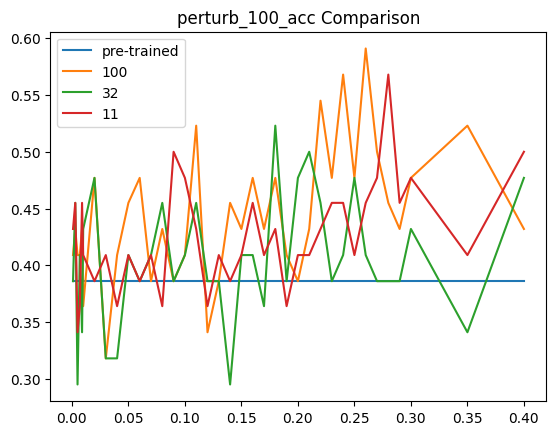

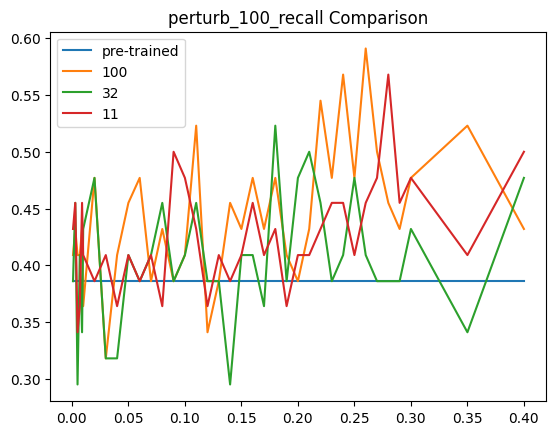

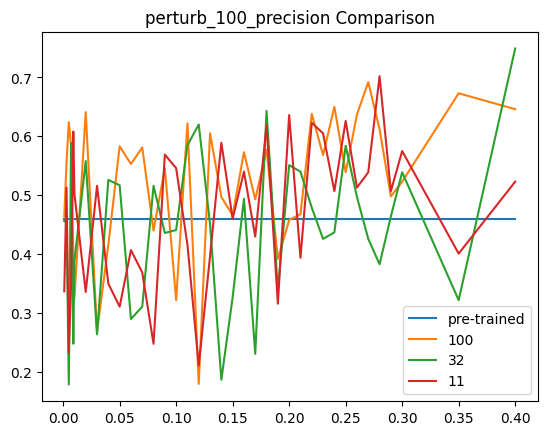

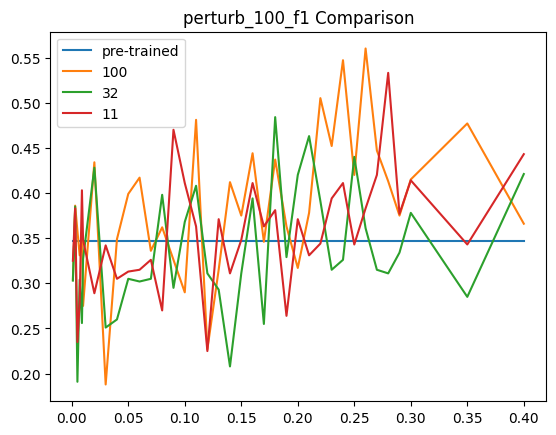

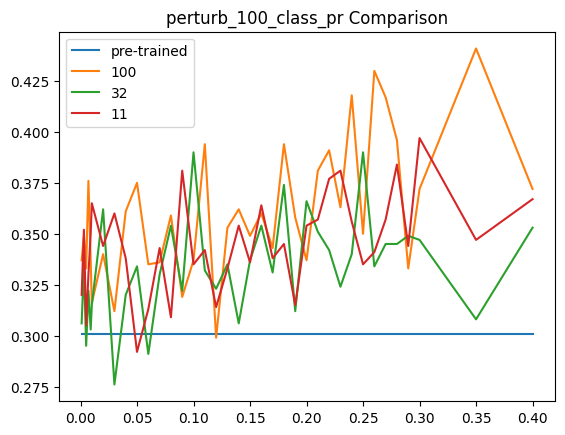

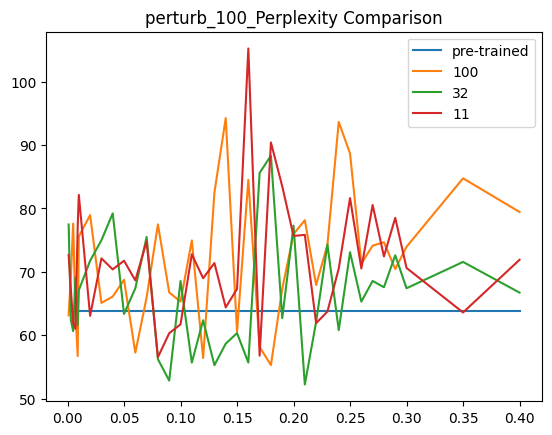

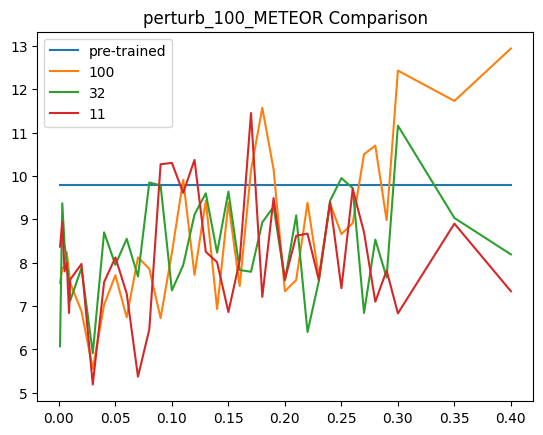

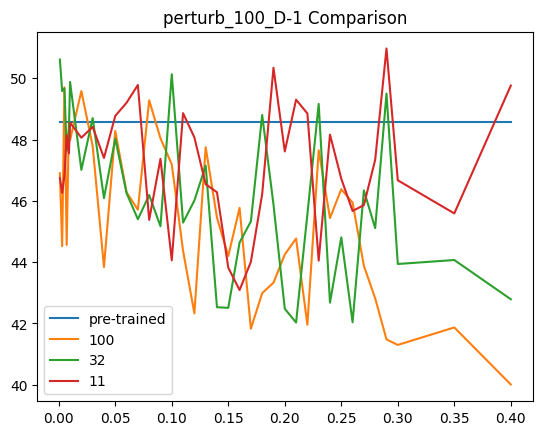

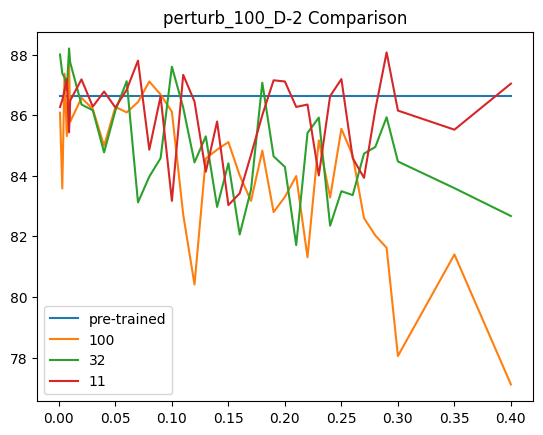

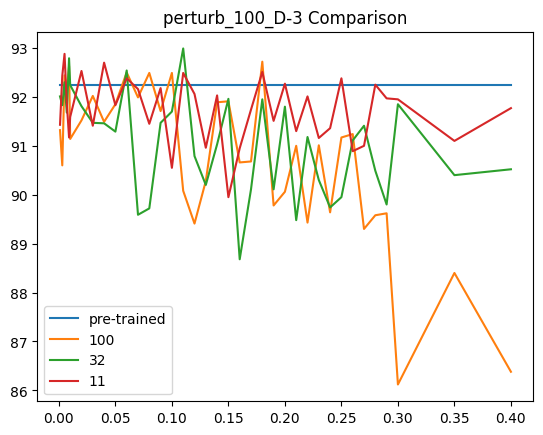

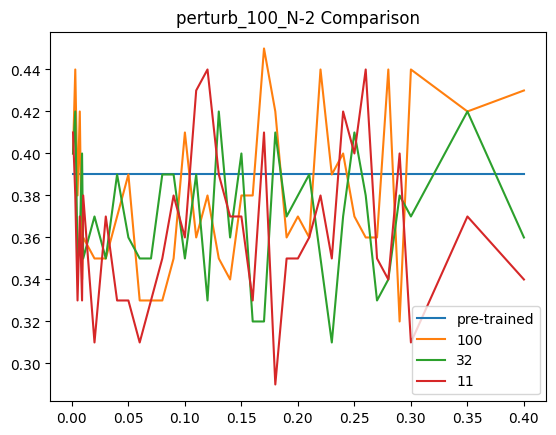

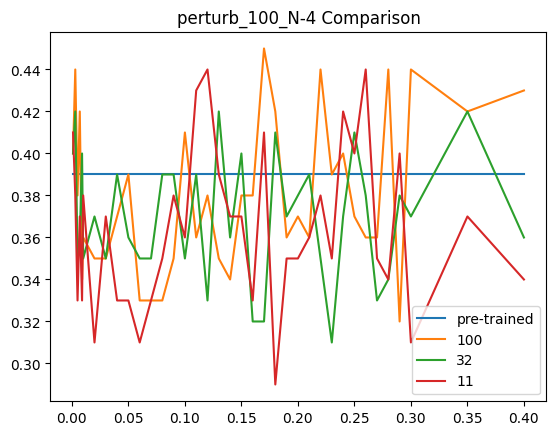

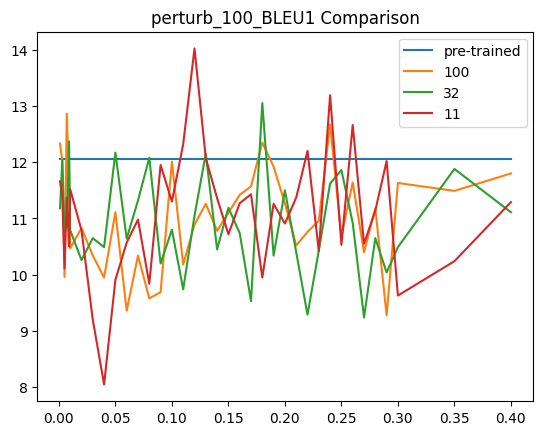

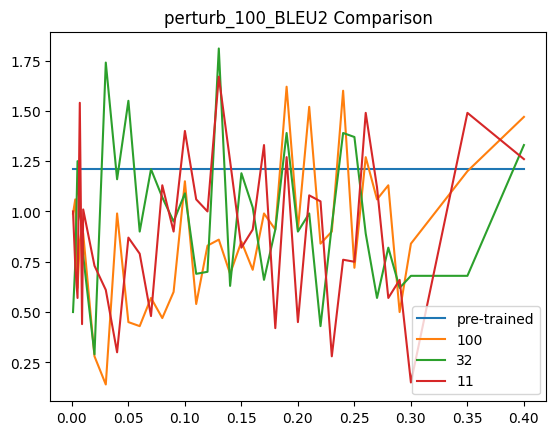

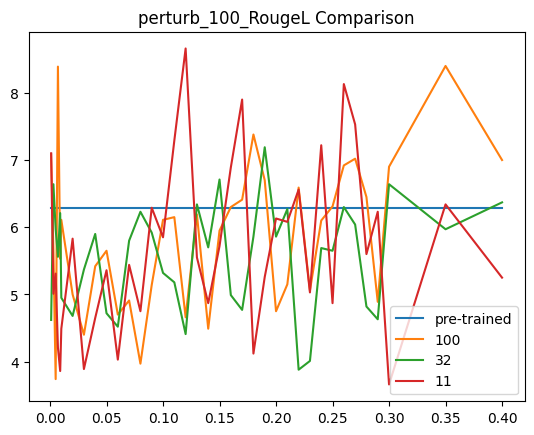

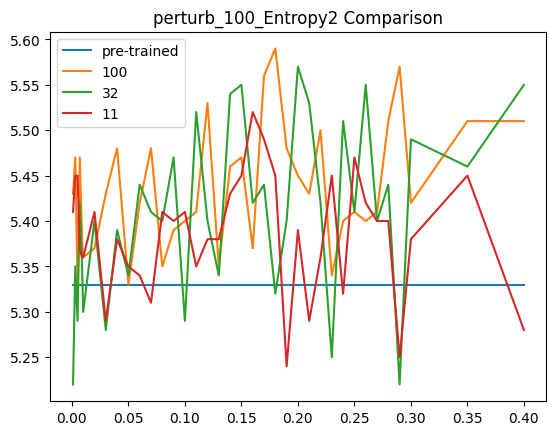

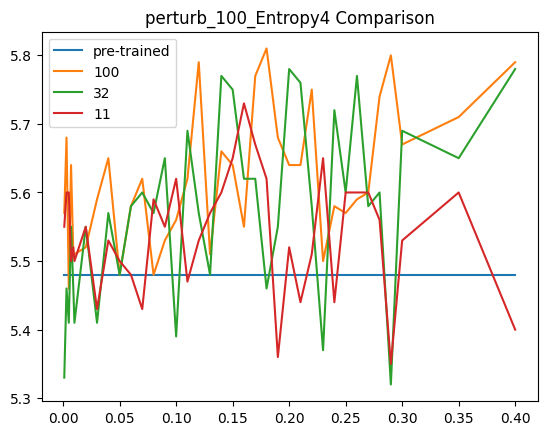

In [12]:
df_32_5 = df_create(stepsizess,[32],[5])
df_11_5 = df_create(stepsizess,[11],[5])
for i in columns:
    plot_re(stepsizess,[df_100_5,df_32_5,df_11_5],[100,32,11],i)

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.001__11__3  0.341   0.341      0.309  0.269     0.290       83.19    7.42   
0.003__11__3  0.409   0.409      0.278  0.291     0.321       86.48    7.70   
0.005__11__3  0.500   0.500      0.616  0.445     0.355       66.20   10.44   
0.007__11__3  0.364   0.364      0.333  0.272     0.294       57.26    9.22   
0.009__11__3  0.409   0.409      0.409  0.373     0.329       65.37    6.50   
0.01__11__3   0.409   0.409      0.502  0.352     0.343       62.92    6.87   
0.02__11__3   0.318   0.318      0.223  0.221     0.325       60.77    8.52   
0.03__11__3   0.341   0.341      0.539  0.291     0.311       51.70    7.02   
0.04__11__3   0.455   0.455      0.467  0.364     0.339       79.30    6.20   
0.05__11__3   0.364   0.364      0.513  0.288     0.321       97.62    7.62   
0.06__11__3   0.364   0.364      0.393  0.291     0.289       68.22    8.44   
0.07__11__3   0.409   0.409      0.443  0.322     0.340       70.14    8.79   
0.08__11__3   0.432   0.432      0.500  0.366     0.358       56.60    7.36   
0.09__11__3   0.364   0.364      0.354  0.284     0.366       62.71    7.82   
0.1__11__3    0.386   0.386      0.642  0.319     0.319       57.43    8.25   
0.11__11__3   0.364   0.364      0.254  0.240     0.289       65.86    7.47   
0.12__11__3   0.386   0.386      0.402  0.304     0.339       72.74    8.34   
0.13__11__3   0.432   0.432      0.340  0.330     0.323       70.07    9.57   
0.14__11__3   0.455   0.455      0.451  0.370     0.354       76.81    5.50   
0.15__11__3   0.386   0.386      0.273  0.275     0.297       63.73    6.09   
0.16__11__3   0.523   0.523      0.630  0.476     0.377       71.29    8.79   
0.17__11__3   0.364   0.364      0.238  0.272     0.300       58.62    5.43   
0.18__11__3   0.386   0.386      0.400  0.319     0.326       68.01    6.85   
0.19__11__3   0.318   0.318      0.220  0.234     0.285       55.42    6.83   
0.2__11__3    0.500   0.500      0.635  0.456     0.376       61.83    8.11   
0.21__11__3   0.455   0.455      0.725  0.372     0.345       63.37    5.93   
0.22__11__3   0.409   0.409      0.413  0.342     0.365       73.78    8.96   
0.23__11__3   0.386   0.386      0.278  0.301     0.299       61.24    8.31   
0.24__11__3   0.409   0.409      0.465  0.316     0.311       56.00   10.91   
0.25__11__3   0.386   0.386      0.434  0.330     0.323       60.92    9.32   
0.26__11__3   0.409   0.409      0.495  0.317     0.323       86.19    7.42   
0.27__11__3   0.455   0.455      0.545  0.424     0.357       74.76    8.92   
0.28__11__3   0.364   0.364      0.346  0.280     0.350       64.96   10.12   
0.29__11__3   0.386   0.386      0.462  0.361     0.324       62.46    9.11   
0.3__11__3    0.409   0.409      0.331  0.315     0.303       66.39    9.30   
0.35__11__3   0.386   0.386      0.605  0.315     0.327       58.84    8.42   
0.4__11__3    0.341   0.341      0.337  0.278     0.349       67.86    9.99   

                D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  Entropy2  \
0.001__11__3  48.00  86.36  91.97  0.30  0.30   8.87   0.87    4.31      5.39   
0.003__11__3  50.86  88.03  92.43  0.40  0.40  10.67   0.82    5.00      5.29   
0.005__11__3  43.70  83.57  90.92  0.42  0.42  12.02   1.04    7.07      5.50   
0.007__11__3  43.56  84.28  91.76  0.37  0.37  11.30   0.89    6.90      5.53   
0.009__11__3  48.47  87.86  92.68  0.37  0.37  10.42   0.74    4.39      5.37   
0.01__11__3   46.16  87.01  91.99  0.37  0.37  10.58   0.28    4.17      5.48   
0.02__11__3   46.13  84.91  91.24  0.40  0.40  11.17   1.05    5.49      5.44   
0.03__11__3   47.15  86.27  92.70  0.38  0.38  11.32   1.15    4.93      5.40   
0.04__11__3   47.59  86.87  91.84  0.39  0.39  10.81   1.17    4.36      5.39   
0.05__11__3   47.19  85.72  91.30  0.34  0.34  10.97   1.04    5.02      5.34   
0.06__11__3   50.39  87.24  91.42  0.43  0.43  12.21   1.54    7.30      5.26   
0.07__11__3   47.83  85.75  92.05  0.39  

acc  recall  precision     f1  class_pr  Perplexity  METEOR  \
0.001__11__5  0.432   0.432      0.337  0.325     0.320       72.66    8.37   
0.003__11__5  0.455   0.455      0.513  0.383     0.352       67.14    8.93   
0.005__11__5  0.341   0.341      0.233  0.235     0.305       61.95    7.80   
0.007__11__5  0.364   0.364      0.346  0.280     0.330       61.01    7.99   
0.009__11__5  0.455   0.455      0.608  0.403     0.350       77.07    6.84   
0.01__11__5   0.409   0.409      0.502  0.348     0.365       82.14    7.61   
0.02__11__5   0.386   0.386      0.336  0.289     0.344       63.06    7.97   
0.03__11__5   0.409   0.409      0.516  0.342     0.360       72.12    5.19   
0.04__11__5   0.364   0.364      0.350  0.305     0.338       70.38    7.55   
0.05__11__5   0.409   0.409      0.311  0.313     0.292       71.75    8.12   
0.06__11__5   0.386   0.386      0.407  0.315     0.313       68.65    7.29   
0.07__11__5   0.409   0.409      0.369  0.326     0.343       74.80    5.37   
0.08__11__5   0.364   0.364      0.248  0.270     0.309       56.54    6.46   
0.09__11__5   0.500   0.500      0.569  0.470     0.381       60.32   10.27   
0.1__11__5    0.477   0.477      0.546  0.411     0.335       61.71   10.30   
0.11__11__5   0.432   0.432      0.416  0.363     0.342       72.78    9.61   
0.12__11__5   0.364   0.364      0.211  0.225     0.314       68.99   10.37   
0.13__11__5   0.409   0.409      0.397  0.371     0.333       71.38    8.25   
0.14__11__5   0.386   0.386      0.589  0.311     0.354       64.39    8.01   
0.15__11__5   0.409   0.409      0.460  0.348     0.336       67.29    6.86   
0.16__11__5   0.455   0.455      0.540  0.411     0.364      105.23    8.05   
0.17__11__5   0.409   0.409      0.430  0.363     0.338       56.77   11.45   
0.18__11__5   0.432   0.432      0.619  0.381     0.345       90.40    7.21   
0.19__11__5   0.364   0.364      0.316  0.264     0.315       83.50    9.49   
0.2__11__5    0.409   0.409      0.636  0.371     0.354       75.66    7.61   
0.21__11__5   0.409   0.409      0.394  0.331     0.357       75.83    8.62   
0.22__11__5   0.432   0.432      0.623  0.344     0.377       61.90    8.67   
0.23__11__5   0.455   0.455      0.605  0.394     0.381       63.73    7.60   
0.24__11__5   0.455   0.455      0.507  0.411     0.356       70.51    9.40   
0.25__11__5   0.409   0.409      0.626  0.343     0.335       81.63    7.41   
0.26__11__5   0.455   0.455      0.513  0.383     0.341       70.53    9.70   
0.27__11__5   0.477   0.477      0.539  0.420     0.357       80.54    8.70   
0.28__11__5   0.568   0.568      0.702  0.533     0.384       72.43    7.10   
0.29__11__5   0.455   0.455      0.507  0.377     0.344       78.52    7.82   
0.3__11__5    0.477   0.477      0.575  0.414     0.397       70.61    6.83   
0.35__11__5   0.409   0.409      0.401  0.343     0.347       63.59    8.90   
0.4__11__5    0.500   0.500      0.523  0.443     0.367       71.90    7.34   

                D-1    D-2    D-3   N-2   N-4  BLEU1  BLEU2  RougeL  Entropy2  \
0.001__11__5  46.74  86.27  91.43  0.41  0.41  11.66   1.00    7.10      5.41   
0.003__11__5  46.26  86.49  92.43  0.38  0.38  11.40   0.73    5.01      5.45   
0.005__11__5  46.81  86.83  92.88  0.33  0.33  10.11   0.57    5.31      5.45   
0.007__11__5  48.14  87.20  91.87  0.37  0.37  11.37   1.54    4.21      5.37   
0.009__11__5  47.55  85.43  91.17  0.33  0.33  10.50   0.44    3.86      5.36   
0.01__11__5   48.55  86.48  91.59  0.38  0.38  11.52   1.01    4.49      5.36   
0.02__11__5   48.06  87.18  92.53  0.31  0.31  10.79   0.73    5.83      5.41   
0.03__11__5   48.41  86.28  91.41  0.37  0.37   9.20   0.61    3.89      5.29   
0.04__11__5   47.40  86.78  92.70  0.33  0.33   8.05   0.30    4.65      5.38   
0.05__11__5   48.77  86.25  91.83  0.33  0.33   9.91   0.87    5.36      5.35   
0.06__11__5   49.20  86.84  92.38  0.31  0.31  10.57   0.79    4.03      5.34   
0.07__11__5   49.78  87.80  92.16  0.33  

acc  recall  precision      f1  class_pr  Perplexity  METEOR     D-1  \
0   0.3865  0.3865     0.3230  0.2970    0.3050      77.925   7.895  47.370   
1   0.4320  0.4320     0.3955  0.3370    0.3365      76.810   8.315  48.560   
2   0.4205  0.4205     0.4245  0.3400    0.3300      64.075   9.120  45.255   
3   0.3640  0.3640     0.3395  0.2760    0.3120      59.135   8.605  45.850   
4   0.4320  0.4320     0.5085  0.3880    0.3395      71.220   6.670  48.010   
5   0.4090  0.4090     0.5020  0.3500    0.3540      72.530   7.240  47.355   
6   0.3520  0.3520     0.2795  0.2550    0.3345      61.915   8.245  47.095   
7   0.3750  0.3750     0.5275  0.3165    0.3355      61.910   6.105  47.780   
8   0.4095  0.4095     0.4085  0.3345    0.3385      74.840   6.875  47.495   
9   0.3865  0.3865     0.4120  0.3005    0.3065      84.685   7.870  47.980   
10  0.3750  0.3750     0.4000  0.3030    0.3010      68.435   7.865  49.795   
11  0.4090  0.4090     0.4060  0.3240    0.3415      72.470   7.080  48.805   
12  0.3980  0.3980     0.3740  0.3180    0.3335      56.570   6.910  45.740   
13  0.4320  0.4320     0.4615  0.3770    0.3735      61.515   9.045  45.750   
14  0.4315  0.4315     0.5940  0.3650    0.3270      59.570   9.275  44.430   
15  0.3980  0.3980     0.3350  0.3015    0.3155      69.320   8.540  48.105   
16  0.3750  0.3750     0.3065  0.2645    0.3265      70.865   9.355  48.705   
17  0.4205  0.4205     0.3685  0.3505    0.3280      70.725   8.910  47.410   
18  0.4205  0.4205     0.5200  0.3405    0.3540      70.600   6.755  47.395   
19  0.3975  0.3975     0.3665  0.3115    0.3165      65.510   6.475  47.245   
20  0.4890  0.4890     0.5850  0.4435    0.3705      88.260   8.420  44.220   
21  0.3865  0.3865     0.3340  0.3175    0.3190      57.695   8.440  46.315   
22  0.4090  0.4090     0.5095  0.3500    0.3355      79.205   7.030  45.960   
23  0.3410  0.3410     0.2680  0.2490    0.3000      69.460   8.160  49.885   
24  0.4545  0.4545     0.6355  0.4135    0.3650      68.745   7.860  46.680   
25  0.4320  0.4320     0.5595  0.3515    0.3510      69.600   7.275  48.720   
26  0.4205  0.4205     0.5180  0.3430    0.3710      67.840   8.815  49.055   
27  0.4205  0.4205     0.4415  0.3475    0.3400      62.485   7.955  43.855   
28  0.4320  0.4320     0.4860  0.3635    0.3335      63.255  10.155  46.025   
29  0.3975  0.3975     0.5300  0.3365    0.3290      71.275   8.365  46.820   
30  0.4320  0.4320     0.5040  0.3500    0.3320      78.360   8.560  46.885   
31  0.4660  0.4660     0.5420  0.4220    0.3570      77.650   8.810  46.445   
32  0.4660  0.4660     0.5240  0.4065    0.3670      68.695   8.610  47.375   
33  0.4205  0.4205     0.4845  0.3690    0.3340      70.490   8.465  48.500   
34  0.4430  0.4430     0.4530  0.3645    0.3500      68.500   8.065  47.800   
35  0.3975  0.3975     0.5030  0.3290    0.3370      61.215   8.660  43.615   
36  0.4205  0.4205     0.4300  0.3605    0.3580      69.880   8.665  48.260   

       D-2     D-3    N-2    N-4   BLEU1  BLEU2  RougeL  Entropy2  Entropy4  
0   86.315  91.700  0.355  0.355  10.265  0.935   5.705     5.400     5.545  
1   87.260  92.430  0.390  0.390  11.035  0.775   5.005     5.370     5.500  
2   85.200  91.900  0.375  0.375  11.065  0.805   6.190     5.475     5.650  
3   85.740  91.815  0.370  0.370  11.335  1.215   5.555     5.450     5.615  
4   86.645  91.925  0.350  0.350  10.460  0.590   4.125     5.365     5.510  
5   86.745  91.790  0.375  0.375  11.050  0.645   4.330     5.420     5.555  
6   86.045  91.885  0.355  0.355  10.980  0.890   5.660     5.425     5.590  
7   86.275  92.055  0.375  0.375  10.260  0.880   4.410     5.345     5.495  
8   86.825  92.270  0.360  0.360   9.430  0.735   4.505     5.385     5.525  
9   85.985  91.565  0.335  0.335  10.440  0.955   5.190     5.345     5.495  
10  87.040  91.900  0.370  0.370  11.390  1.165   5.665     5.300     5.425  
11  86.775  92.105  0.360  0.360  11.230  0.665   5.750     5.345   

/tmp/ipykernel_3247622/2086627696.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(stepsizess,[pre_trained[att][0]]*len(stepsizess),label ='pre-trained')


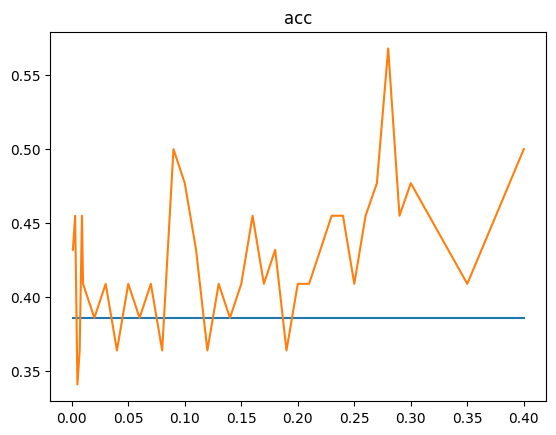

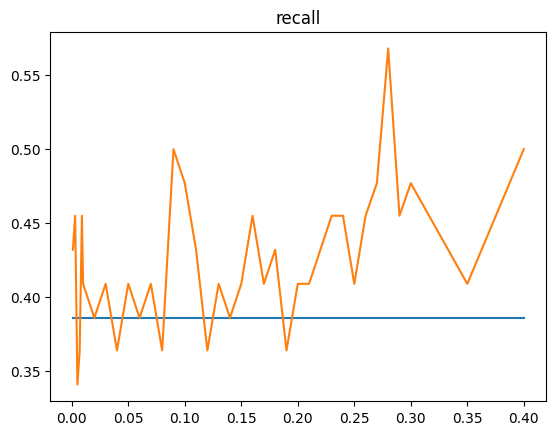

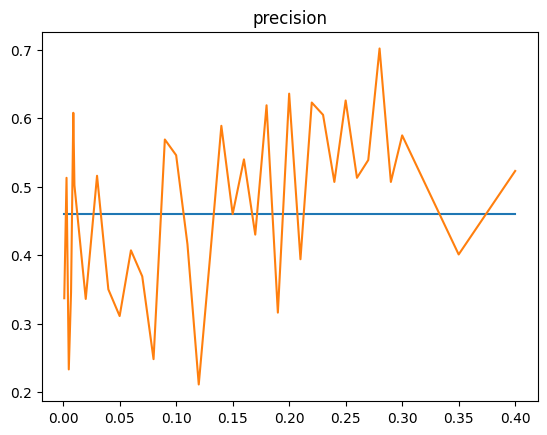

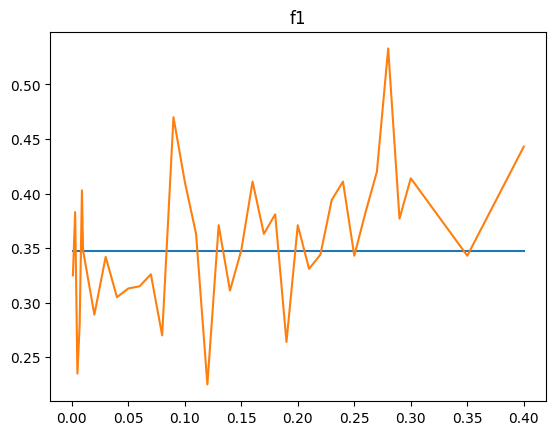

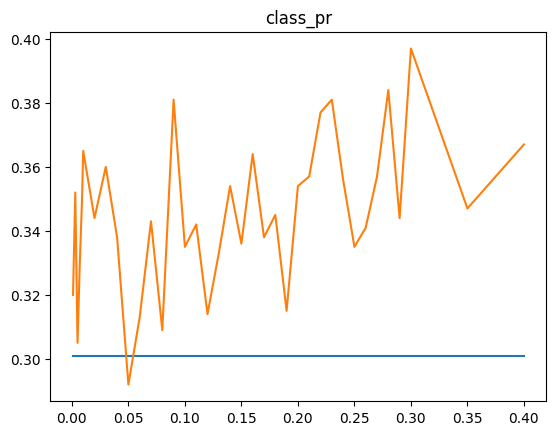

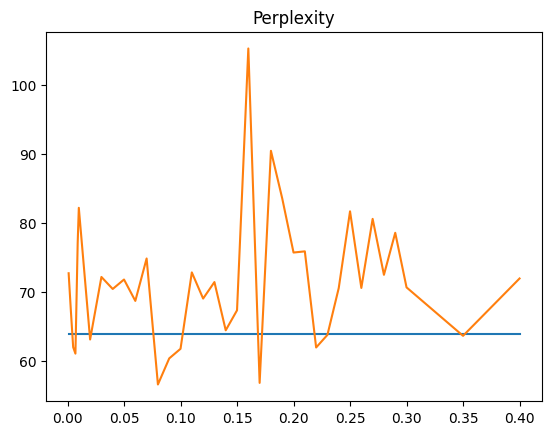

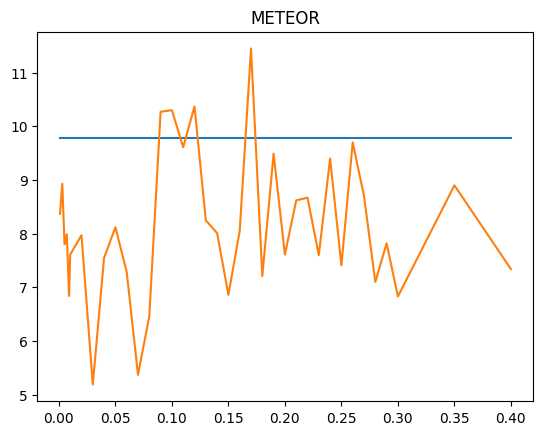

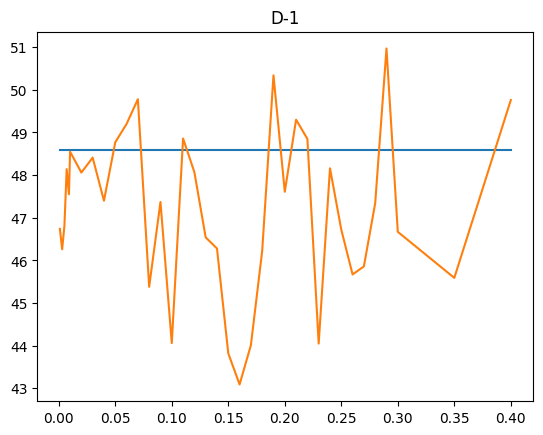

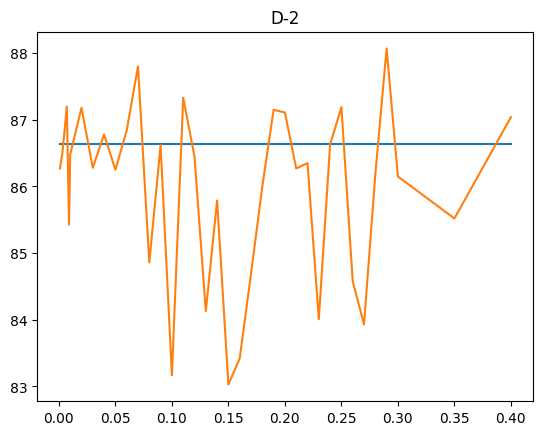

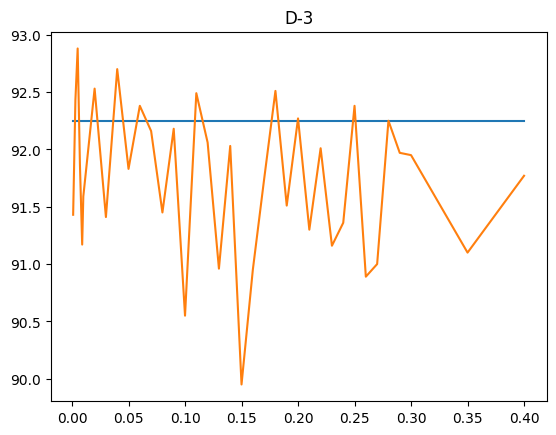

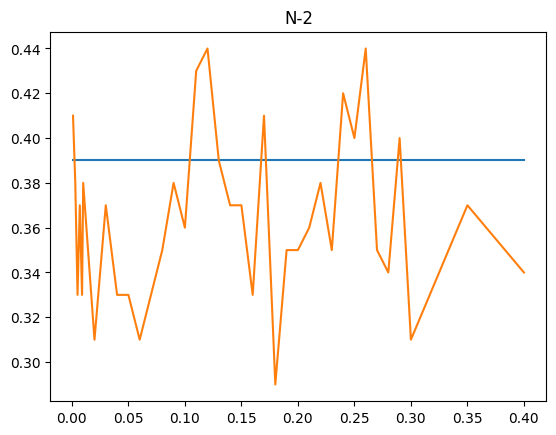

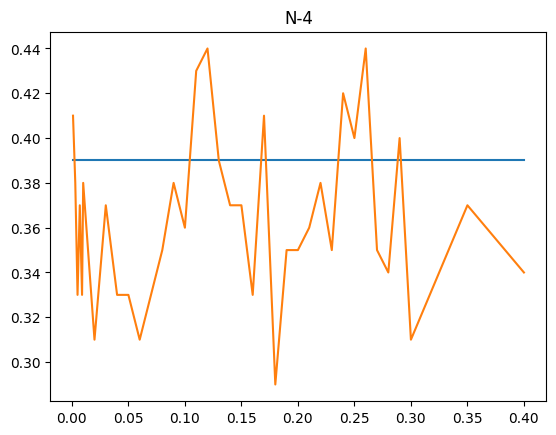

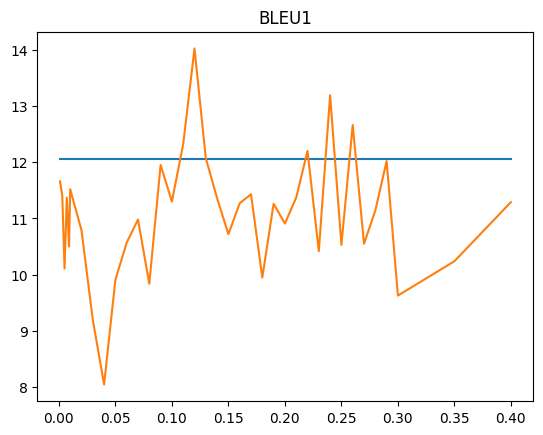

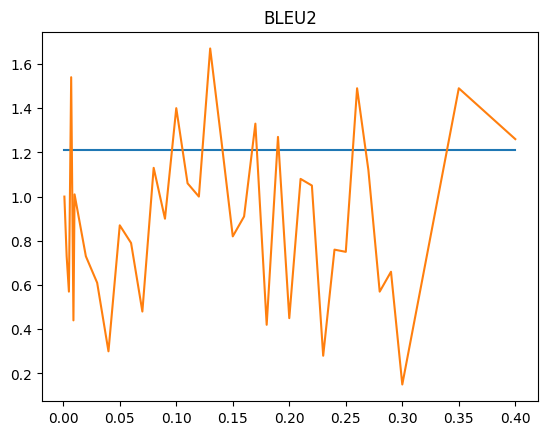

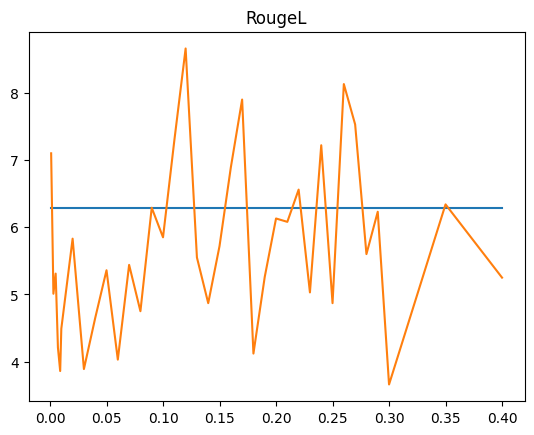

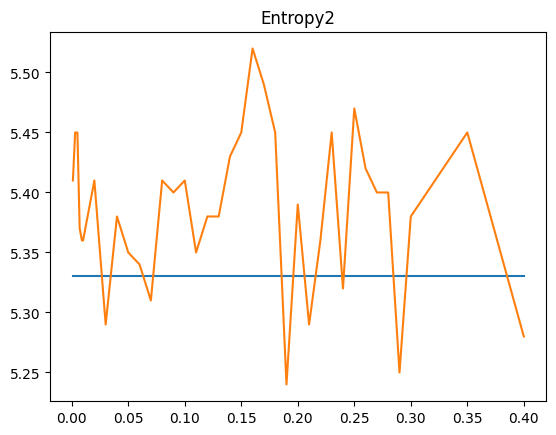

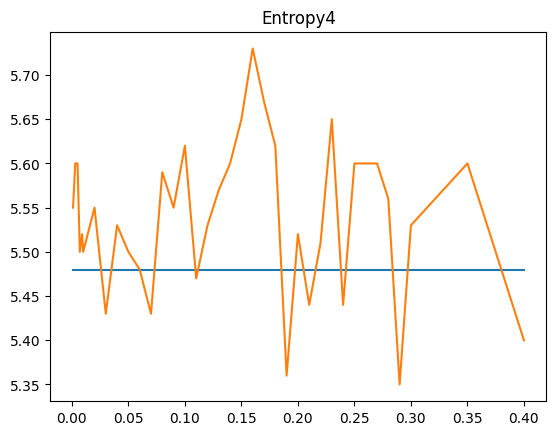

In [9]:

df_11_3 = df_create(stepsizess,[11],[3])
df_11_5 = df_create(stepsizess,[11],[5])

df_11_35 = avg_dfs([df_11_3,df_11_5])
atts = df_11_5.columns

for att in atts:
    plt.plot(stepsizess,[pre_trained[att][0]]*len(stepsizess),label ='pre-trained')
    plt.plot(stepsizess,df_11_5[att])
    plt.title('{}'.format(att))
    plt.show()


In [7]:
df_01_per_step_3 = df_create([0.01],[100,11,22,32],[3])
df_02_per_step_3 = df_create([0.02],[100,11,22,32],[3])
df_03_per_step_3 = df_create([0.03],[100,11,22,32],[3])
df_04_per_step_3 = df_create([0.04],[100,11,22,32],[3])
df_05_per_step_3 = df_create([0.05],[100,11,22,32],[3])
df_06_per_step_3 = df_create([0.06],[100,11,22,32],[3])
df_07_per_step_3 = df_create([0.07],[100,11,22,32],[3])
df_08_per_step_3 = df_create([0.08],[100,11,22,32],[3])
df_09_per_step_3 = df_create([0.09],[100,11,22,32],[3])
df_10_per_step_3 = df_create([0.1],[100,11,22,32],[3])
df_01_per_step_5 = df_create([0.01],[100,11,22,32],[5])
df_02_per_step_5 = df_create([0.02],[100,11,22,32],[5])
df_03_per_step_5 = df_create([0.03],[100,11,22,32],[5])
df_04_per_step_5 = df_create([0.04],[100,11,22,32],[5])
df_05_per_step_5 = df_create([0.05],[100,11,22,32],[5])
df_06_per_step_5 = df_create([0.06],[100,11,22,32],[5])
df_07_per_step_5 = df_create([0.07],[100,11,22,32],[5])
df_08_per_step_5 = df_create([0.08],[100,11,22,32],[5])
df_09_per_step_5 = df_create([0.09],[100,11,22,32],[5])
df_10_per_step_5 = df_create([0.1],[100,11,22,32],[5])

valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 22.81it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 21.84it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 23.60it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 23.65it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 21.08it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 23.62it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 23.41it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 21.98it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 23.48it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 24.19it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 20.49it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 23.24it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 23.57it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 21.38it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 23.87it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 23.69it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 20.85it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 23.51it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 23.71it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 21.76it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 21.14it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 23.33it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 21.07it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 23.28it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 22.72it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 20.82it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 23.33it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 24.42it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 18.97it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 23.38it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 23.80it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 20.78it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 22.51it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 23.76it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 20.03it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 21.08it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 23.63it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 22.02it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 24.14it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 23.07it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 21.80it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 23.52it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 24.46it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 22.55it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 23.99it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 24.13it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 21.56it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 21.06it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 23.89it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 21.34it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 24.13it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 23.23it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 20.69it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 23.78it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 23.45it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 21.21it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 23.91it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 23.86it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 21.84it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 22.82it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 23.47it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 21.42it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 23.91it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 23.42it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 21.99it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 23.15it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 24.81it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 21.66it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 22.44it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 22.79it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 20.50it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 23.97it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 23.75it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 21.63it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 22.94it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 23.51it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 22.01it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 22.26it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 25.24it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 21.00it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [8]:
df_01_35 = df_01_per_step_3.reset_index(drop=True).add(df_01_per_step_5.reset_index(drop=True)) /2
df_02_35 = df_02_per_step_3.reset_index(drop=True).add(df_02_per_step_5.reset_index(drop=True)) /2
df_03_35 = df_03_per_step_3.reset_index(drop=True).add(df_03_per_step_5.reset_index(drop=True)) /2
df_04_35 = df_04_per_step_3.reset_index(drop=True).add(df_04_per_step_5.reset_index(drop=True)) /2
df_05_35 = df_05_per_step_3.reset_index(drop=True).add(df_05_per_step_5.reset_index(drop=True)) /2
df_06_35 = df_06_per_step_3.reset_index(drop=True).add(df_06_per_step_5.reset_index(drop=True)) /2
df_07_35 = df_07_per_step_3.reset_index(drop=True).add(df_07_per_step_5.reset_index(drop=True)) /2
df_08_35 = df_08_per_step_3.reset_index(drop=True).add(df_08_per_step_5.reset_index(drop=True)) /2
df_09_35 = df_09_per_step_3.reset_index(drop=True).add(df_09_per_step_5.reset_index(drop=True)) /2
df_10_35 = df_10_per_step_3.reset_index(drop=True).add(df_10_per_step_5.reset_index(drop=True)) /2

In [9]:
display(df_01_per_step_3)
display(df_02_per_step_3)
display(df_03_per_step_3)
display(df_04_per_step_3)
display(df_05_per_step_3)
display(df_06_per_step_3)
display(df_07_per_step_3)
display(df_08_per_step_3)
display(df_09_per_step_3)
display(df_10_per_step_3)

acc recall precision     f1 class_pr Perplexity METEOR    D-1  \
0.01__100__3  0.545  0.545     0.543  0.525    0.336      11.46   18.2  19.57   
0.01__11__3   0.614  0.614     0.628  0.595    0.381       9.08   18.3  19.72   
0.01__22__3   0.659  0.659     0.657  0.633    0.414       8.92  19.58  20.21   
0.01__32__3   0.614  0.614     0.682    0.6    0.437      12.48  18.15  21.35   

                D-2    D-3   N-2   N-4  BLEU1 BLEU2 RougeL Entropy2 Entropy4  
0.01__100__3  64.07  85.95  0.48  0.48  10.63  1.64  10.31     6.57     7.32  
0.01__11__3    64.4  86.43  0.45  0.45   9.85   1.4   9.37     6.59     7.32  
0.01__22__3   65.21  86.06  0.42  0.42  10.31  1.63   8.99     6.57     7.27  
0.01__32__3   65.86  86.72  0.44  0.44   9.99  1.03   8.27     6.48     7.16

acc recall precision     f1 class_pr Perplexity METEOR    D-1  \
0.02__100__3  0.636  0.636     0.663  0.612    0.356       9.02  17.13  19.32   
0.02__11__3   0.636  0.636     0.702   0.62    0.417       9.53  17.76  19.62   
0.02__22__3   0.614  0.614      0.62  0.595    0.436       8.68  17.42  19.57   
0.02__32__3   0.591  0.591     0.584  0.557    0.401      11.02  18.05  20.24   

                D-2    D-3   N-2   N-4 BLEU1 BLEU2 RougeL Entropy2 Entropy4  
0.02__100__3  64.49  86.24  0.42  0.42  9.63  1.46   8.95     6.61     7.33  
0.02__11__3   63.92  85.03  0.43  0.43  9.81   1.1   8.94     6.57     7.29  
0.02__22__3   64.41  86.19  0.44  0.44  9.37  1.05   8.72     6.59     7.32  
0.02__32__3    65.2  86.81  0.43  0.43  9.66  1.34   8.83     6.54     7.24

acc recall precision     f1 class_pr Perplexity METEOR    D-1  \
0.03__100__3  0.659  0.659     0.705  0.649    0.425      11.62  18.88  21.26   
0.03__11__3   0.614  0.614     0.661  0.597      0.4      11.85  18.14  19.04   
0.03__22__3   0.682  0.682     0.717  0.682    0.418       9.05   20.4  19.26   
0.03__32__3   0.636  0.636     0.678   0.62    0.412      11.41  20.31  19.25   

                D-2    D-3   N-2   N-4  BLEU1 BLEU2 RougeL Entropy2 Entropy4  
0.03__100__3  66.05  86.53  0.49  0.49  10.28  1.87  10.29     6.53     7.22  
0.03__11__3   63.72  86.29  0.42  0.42   9.64  1.47   8.77     6.64      7.4  
0.03__22__3    64.3  86.34  0.47  0.47  10.33  1.97  10.59     6.61     7.34  
0.03__32__3   64.43  86.41  0.42  0.42  10.32  1.49   8.97     6.62     7.36

acc recall precision     f1 class_pr Perplexity METEOR    D-1  \
0.04__100__3  0.659  0.659     0.672  0.636     0.38       9.54  17.76  19.77   
0.04__11__3   0.636  0.636      0.66  0.621    0.391       12.3  17.07  19.83   
0.04__22__3   0.636  0.636     0.651  0.619    0.373       9.21  17.68  18.81   
0.04__32__3   0.614  0.614     0.615  0.594    0.389        9.1  17.41  19.64   

                D-2    D-3   N-2   N-4 BLEU1 BLEU2 RougeL Entropy2 Entropy4  
0.04__100__3  65.02  86.52  0.45  0.45  9.94  1.39   8.34     6.58      7.3  
0.04__11__3   64.81   86.4  0.46  0.46  9.71  1.02   8.53     6.58      7.3  
0.04__22__3   63.22  85.69  0.41  0.41  9.41  0.86   9.04     6.63     7.39  
0.04__32__3   64.63  86.94  0.44  0.44  9.76  1.17   8.89      6.6     7.33

acc recall precision     f1 class_pr Perplexity METEOR    D-1  \
0.05__100__3  0.705  0.705     0.729  0.699    0.402      11.62  17.43  19.84   
0.05__11__3   0.614  0.614     0.634  0.582    0.389      13.16  19.03  21.41   
0.05__22__3   0.705  0.705      0.73   0.69    0.436       9.65  18.15  19.61   
0.05__32__3   0.636  0.636     0.682  0.618    0.418      13.65  18.63  21.89   

                D-2    D-3   N-2   N-4  BLEU1 BLEU2 RougeL Entropy2 Entropy4  
0.05__100__3  64.03  86.35   0.4   0.4   9.58  0.98   7.76      6.6     7.34  
0.05__11__3   66.82  87.85  0.46  0.46  10.44  1.77   8.89     6.51     7.19  
0.05__22__3   64.16  85.68  0.41  0.41   9.49   1.3   8.35      6.6     7.32  
0.05__32__3   66.85  87.53  0.47  0.47  10.47  1.59   9.84     6.53      7.2

acc recall precision     f1 class_pr Perplexity METEOR    D-1  \
0.06__100__3  0.614  0.614     0.659  0.594    0.414      13.03  21.27  20.18   
0.06__11__3   0.568  0.568     0.585  0.557    0.398       9.98  17.14  20.14   
0.06__22__3   0.568  0.568     0.586  0.546    0.385      10.33  18.87  20.23   
0.06__32__3   0.523  0.523     0.605  0.508    0.395        9.7   17.4   19.5   

                D-2    D-3   N-2   N-4  BLEU1 BLEU2 RougeL Entropy2 Entropy4  
0.06__100__3  64.36  86.12  0.47  0.47  10.56  1.45   9.63     6.54     7.27  
0.06__11__3   64.61  86.13  0.43  0.43   9.22  1.68   8.25     6.57     7.29  
0.06__22__3   64.82   86.4  0.47  0.47   10.2  1.33  10.17     6.56     7.29  
0.06__32__3   64.45  86.74  0.45  0.45   9.85   1.2   9.57      6.6     7.33

acc recall precision     f1 class_pr Perplexity METEOR    D-1  \
0.07__100__3  0.568  0.568     0.651  0.552    0.355      10.74  17.48  19.53   
0.07__11__3   0.614  0.614     0.641  0.595    0.395       9.98  17.61  20.54   
0.07__22__3   0.727  0.727     0.776  0.719    0.417       29.7  18.36   20.7   
0.07__32__3   0.727  0.727     0.762  0.724    0.427       9.93  18.52  19.61   

                D-2    D-3   N-2   N-4  BLEU1 BLEU2 RougeL Entropy2 Entropy4  
0.07__100__3  64.03  86.06  0.42  0.42   9.55  0.74   8.47      6.6     7.34  
0.07__11__3   65.37  86.75  0.43  0.43   9.76  1.19   8.84     6.58     7.29  
0.07__22__3   64.69  85.55  0.45  0.45   9.47  1.39   9.05     6.53     7.24  
0.07__32__3   64.85  85.87  0.43  0.43  10.65  1.15   9.63     6.62     7.32

acc recall precision     f1 class_pr Perplexity METEOR    D-1  \
0.08__100__3  0.682  0.682     0.731  0.678    0.414      14.86  18.62  20.35   
0.08__11__3    0.75   0.75     0.762  0.742    0.412      11.14  18.48  20.41   
0.08__22__3   0.568  0.568     0.628  0.567    0.378      12.67  17.35  20.11   
0.08__32__3   0.659  0.659     0.685  0.655     0.42      12.51  17.19  19.89   

                D-2    D-3   N-2   N-4  BLEU1 BLEU2 RougeL Entropy2 Entropy4  
0.08__100__3   64.6  85.78  0.43  0.43   9.85   1.3    9.3     6.55     7.27  
0.08__11__3    65.5   87.2  0.41  0.41   9.96  1.39   8.81     6.56     7.28  
0.08__22__3   65.03  86.35  0.45  0.46  10.13   1.4   8.88     6.57     7.27  
0.08__32__3   65.38  86.65  0.43  0.43    9.5  0.86    8.3     6.57     7.28

acc recall precision     f1 class_pr Perplexity METEOR    D-1  \
0.09__100__3  0.682  0.682     0.698  0.676    0.445      11.92  19.25  19.91   
0.09__11__3   0.659  0.659     0.665  0.645     0.39      10.61  16.71  19.71   
0.09__22__3   0.705  0.705     0.737  0.691    0.389      11.27  16.51  20.08   
0.09__32__3   0.659  0.659     0.677  0.639    0.418      12.92   19.5  21.43   

                D-2    D-3   N-2   N-4  BLEU1 BLEU2 RougeL Entropy2 Entropy4  
0.09__100__3  63.59  85.47  0.42  0.42   9.78  1.37   8.65     6.54     7.27  
0.09__11__3   64.73  85.89  0.38  0.38   8.99  0.74    7.8     6.59      7.3  
0.09__22__3    64.1  85.18  0.42  0.42   9.36  1.19   8.69     6.57      7.3  
0.09__32__3   65.98  86.98   0.5   0.5  10.46  1.11   9.48     6.52     7.22

acc recall precision     f1 class_pr Perplexity METEOR    D-1  \
0.1__100__3  0.614  0.614     0.607  0.584    0.371      14.73  17.68  20.25   
0.1__11__3   0.636  0.636     0.641   0.62    0.436      16.12  17.85  20.68   
0.1__22__3   0.614  0.614     0.648  0.598    0.409      11.35  19.48  19.98   
0.1__32__3   0.614  0.614     0.669  0.602    0.398       9.72  18.88  18.52   

               D-2    D-3   N-2   N-4 BLEU1 BLEU2 RougeL Entropy2 Entropy4  
0.1__100__3  65.75  88.04  0.43  0.43   9.9  1.04   9.75     6.58      7.3  
0.1__11__3   65.56  86.79  0.43  0.43  9.85  1.19   9.37     6.56     7.27  
0.1__22__3    64.4   86.1  0.44  0.44  10.1   1.3   9.12      6.6     7.34  
0.1__32__3   63.21  85.76  0.39  0.39  9.06   1.0    8.7     6.64      7.4

In [10]:
display(df_01_per_step_5)
display(df_02_per_step_5)
display(df_03_per_step_5)
display(df_04_per_step_5)
display(df_05_per_step_5)
display(df_06_per_step_5)
display(df_07_per_step_5)
display(df_08_per_step_5)
display(df_09_per_step_5)
display(df_10_per_step_5)

acc recall precision     f1 class_pr Perplexity METEOR    D-1  \
0.01__100__5  0.659  0.659     0.711   0.65    0.417      11.01  20.36  21.27   
0.01__11__5   0.591  0.591     0.596  0.577    0.365       8.45  18.72  18.77   
0.01__22__5   0.659  0.659     0.756  0.644    0.418       8.79  17.55  21.05   
0.01__32__5   0.591  0.591     0.606  0.571    0.422       9.48  17.65  20.71   

                D-2    D-3   N-2   N-4 BLEU1 BLEU2 RougeL Entropy2 Entropy4  
0.01__100__5  65.97  86.68  0.46  0.46  10.4  1.16   9.98     6.52     7.21  
0.01__11__5   63.52  85.43   0.4   0.4  9.01  1.33   8.34     6.63     7.37  
0.01__22__5   65.75  86.38  0.44  0.44  9.98  1.69   8.88     6.54     7.23  
0.01__32__5   65.14  86.23  0.42  0.42  9.79  1.52   9.05     6.54     7.24

acc recall precision     f1 class_pr Perplexity METEOR    D-1  \
0.02__100__5  0.682  0.682     0.722  0.671    0.421      10.62  18.42  20.93   
0.02__11__5   0.659  0.659     0.691  0.639    0.431       8.66  18.01  19.39   
0.02__22__5   0.591  0.591     0.597  0.576    0.398      10.19  16.72  18.56   
0.02__32__5   0.636  0.636      0.63  0.612    0.341      10.41  18.81  19.57   

                D-2    D-3   N-2   N-4 BLEU1 BLEU2 RougeL Entropy2 Entropy4  
0.02__100__5  65.59  86.23  0.44  0.44  9.26  1.58   8.58     6.53     7.22  
0.02__11__5   65.38   87.0  0.44  0.44  9.73  1.15   8.14     6.63     7.34  
0.02__22__5   63.23  85.35  0.42  0.42  9.35  1.65   8.75     6.61     7.35  
0.02__32__5   64.27  85.83  0.41  0.41  9.78  1.19   8.16     6.58     7.31

acc recall precision     f1 class_pr Perplexity METEOR    D-1  \
0.03__100__5  0.682  0.682     0.679  0.663    0.412      11.66   17.7  20.86   
0.03__11__5   0.659  0.659     0.704  0.653    0.421      10.79  17.55  20.07   
0.03__22__5   0.591  0.591     0.617  0.559    0.377      11.69  17.83  18.88   
0.03__32__5   0.682  0.682     0.731  0.668    0.431      12.01  17.27  19.91   

                D-2    D-3   N-2   N-4  BLEU1 BLEU2 RougeL Entropy2 Entropy4  
0.03__100__5  65.31  86.64  0.41  0.41  10.08  1.11   9.36     6.57     7.28  
0.03__11__5   65.02   86.5  0.41  0.41   9.68  1.28   8.44     6.56     7.27  
0.03__22__5   63.06  85.76  0.42  0.42   9.62  1.52   8.52      6.6     7.36  
0.03__32__5   65.15  86.15  0.44  0.44   9.75  1.37   8.36     6.59      7.3

acc recall precision     f1 class_pr Perplexity METEOR    D-1  \
0.04__100__5  0.636  0.636     0.676  0.623    0.416      10.52  19.95   19.5   
0.04__11__5   0.659  0.659     0.687  0.651    0.457      10.26  18.48  21.17   
0.04__22__5   0.659  0.659     0.688   0.65    0.413       8.87  18.82  19.35   
0.04__32__5   0.523  0.523     0.521  0.501    0.363       9.77   20.5  20.55   

                D-2    D-3   N-2   N-4  BLEU1 BLEU2 RougeL Entropy2 Entropy4  
0.04__100__5  63.65  85.96  0.47  0.47  10.03  1.42  10.31     6.59     7.35  
0.04__11__5   66.29  87.16  0.45  0.45  10.33  1.34   8.98     6.55     7.24  
0.04__22__5    63.8  85.49  0.42  0.42  10.06  1.14   8.98     6.56      7.3  
0.04__32__5   66.03  87.15  0.46  0.46  10.36   1.8   9.36     6.58     7.28

acc recall precision     f1 class_pr Perplexity METEOR    D-1  \
0.05__100__5  0.591  0.591     0.595  0.578    0.416      19.38  16.55   20.6   
0.05__11__5   0.636  0.636     0.684  0.623    0.447      16.11  16.83  21.09   
0.05__22__5   0.659  0.659      0.72  0.639    0.414       9.25   17.0   18.8   
0.05__32__5   0.659  0.659     0.683  0.641     0.38      10.54  18.99  20.24   

                D-2    D-3   N-2   N-4 BLEU1 BLEU2 RougeL Entropy2 Entropy4  
0.05__100__5  65.71  87.18   0.4   0.4  9.88  0.71    8.2     6.57     7.27  
0.05__11__5   66.11  87.29  0.44  0.44  9.82  0.93    9.1     6.53     7.22  
0.05__22__5   63.67  85.72  0.41  0.41   9.6  0.81   9.12     6.62     7.37  
0.05__32__5   64.92  86.55  0.45  0.45  9.79  1.72   9.53     6.57      7.3

acc recall precision     f1 class_pr Perplexity METEOR    D-1  \
0.06__100__5  0.523  0.523     0.551  0.496    0.361      13.36  16.71  20.28   
0.06__11__5   0.591  0.591     0.588  0.588    0.412       11.1  18.49  20.72   
0.06__22__5   0.659  0.659     0.672  0.636    0.434       9.92  18.59  19.82   
0.06__32__5   0.636  0.636     0.643  0.638    0.417      11.23  19.05  20.74   

                D-2    D-3   N-2   N-4  BLEU1 BLEU2 RougeL Entropy2 Entropy4  
0.06__100__5  64.24  85.55  0.42  0.42   8.94  0.94   8.19     6.54     7.27  
0.06__11__5   64.95  86.31  0.44  0.44  10.08   1.6   9.93     6.55     7.26  
0.06__22__5   65.76  87.39  0.47  0.47   10.8  1.66   9.37      6.6     7.31  
0.06__32__5   65.97  86.93  0.46  0.46  10.47  1.52   9.38     6.57     7.26

acc recall precision     f1 class_pr Perplexity METEOR    D-1  \
0.07__100__5  0.636  0.636      0.68  0.631    0.424       21.9  17.86  20.34   
0.07__11__5   0.636  0.636      0.66  0.622    0.424       11.5  19.35  21.63   
0.07__22__5   0.568  0.568     0.593  0.562    0.352      10.79  17.47  20.26   
0.07__32__5   0.705  0.705     0.732  0.698    0.442      16.13  18.45  21.57   

                D-2    D-3   N-2   N-4  BLEU1 BLEU2 RougeL Entropy2 Entropy4  
0.07__100__5  65.14  86.63  0.43  0.43   9.95  1.42   9.63     6.59     7.31  
0.07__11__5   66.34  86.68  0.48  0.48  10.15  1.22  10.65     6.52     7.18  
0.07__22__5   64.54  85.67  0.45  0.45  10.07  1.07   8.83     6.54     7.26  
0.07__32__5   67.02  87.79  0.49  0.49  10.39  1.66   9.84     6.56     7.22

acc recall precision     f1 class_pr Perplexity METEOR    D-1  \
0.08__100__5  0.727  0.727     0.753  0.699     0.42       18.2  16.32  21.08   
0.08__11__5   0.591  0.591     0.645  0.571    0.374      11.74  18.71  20.74   
0.08__22__5   0.682  0.682     0.683  0.663      0.4      11.74  18.25  19.44   
0.08__32__5   0.614  0.614     0.628  0.595    0.409       9.16  20.56  18.96   

                D-2    D-3   N-2   N-4  BLEU1 BLEU2 RougeL Entropy2 Entropy4  
0.08__100__5  66.52  87.19  0.42  0.42   9.63  1.19   8.71     6.53     7.22  
0.08__11__5   64.95  85.81  0.42  0.42   9.51  0.73   8.19     6.55     7.27  
0.08__22__5    63.9   85.9  0.43  0.43   9.88  1.21   8.72     6.57     7.32  
0.08__32__5   63.77  86.72  0.44  0.44  10.25  1.54   9.63     6.61     7.37

acc recall precision     f1 class_pr Perplexity METEOR    D-1  \
0.09__100__5  0.636  0.636     0.666  0.622    0.422      11.67  17.43  21.51   
0.09__11__5   0.636  0.636     0.703  0.629    0.433      14.19  19.52  20.92   
0.09__22__5   0.568  0.568     0.656  0.551    0.408      19.81  17.39  20.92   
0.09__32__5   0.682  0.682     0.694  0.673    0.424       11.1  16.47  19.99   

                D-2    D-3   N-2   N-4  BLEU1 BLEU2 RougeL Entropy2 Entropy4  
0.09__100__5  65.78   87.6  0.43  0.43    9.8  1.34   8.98     6.53     7.24  
0.09__11__5   65.51  86.22  0.42  0.42   10.2  1.27   9.32     6.54     7.25  
0.09__22__5   65.55   86.8  0.44  0.44  10.13  1.37   9.37     6.54     7.26  
0.09__32__5   65.21  86.33  0.41  0.41    9.1  1.11   7.78     6.59      7.3

acc recall precision     f1 class_pr Perplexity METEOR    D-1  \
0.1__100__5  0.636  0.636     0.665  0.609    0.388      19.29   16.0  19.19   
0.1__11__5   0.705  0.705     0.732  0.688     0.38      13.79  18.45  21.15   
0.1__22__5   0.568  0.568     0.597  0.542    0.386       12.2  18.08  18.78   
0.1__32__5   0.705  0.705     0.741  0.698    0.427      11.82  19.78  20.51   

               D-2    D-3   N-2   N-4  BLEU1 BLEU2 RougeL Entropy2 Entropy4  
0.1__100__5  63.71  85.77  0.36  0.36   8.89  0.96   7.57     6.61     7.35  
0.1__11__5   64.53  85.73  0.46  0.46   9.71   1.1   9.12     6.51     7.24  
0.1__22__5   63.24  85.89  0.43  0.43   9.94  0.95   9.19     6.63      7.4  
0.1__32__5    65.0   87.0  0.47  0.47  10.86  1.22   9.94     6.56     7.28

In [11]:
display(df_01_35)
display(df_02_35)
display(df_03_35)
display(df_04_35)
display(df_05_35)
display(df_06_35)
display(df_07_35)
display(df_08_35)
display(df_09_35)
display(df_10_35)


acc  recall precision      f1 class_pr Perplexity  METEOR     D-1  \
0   0.602   0.602     0.627  0.5875   0.3765     11.235   19.28   20.42   
1  0.6025  0.6025     0.612   0.586    0.373      8.765   18.51  19.245   
2   0.659   0.659    0.7065  0.6385    0.416      8.855  18.565   20.63   
3  0.6025  0.6025     0.644  0.5855   0.4295      10.98    17.9   21.03   

     D-2     D-3    N-2    N-4   BLEU1  BLEU2  RougeL Entropy2 Entropy4  
0  65.02  86.315   0.47   0.47  10.515    1.4  10.145    6.545    7.265  
1  63.96   85.93  0.425  0.425    9.43  1.365   8.855     6.61    7.345  
2  65.48   86.22   0.43   0.43  10.145   1.66   8.935    6.555     7.25  
3   65.5  86.475   0.43   0.43    9.89  1.275    8.66     6.51      7.2

acc  recall precision      f1 class_pr Perplexity  METEOR     D-1  \
0   0.659   0.659    0.6925  0.6415   0.3885       9.82  17.775  20.125   
1  0.6475  0.6475    0.6965  0.6295    0.424      9.095  17.885  19.505   
2  0.6025  0.6025    0.6085  0.5855    0.417      9.435   17.07  19.065   
3  0.6135  0.6135     0.607  0.5845    0.371     10.715   18.43  19.905   

      D-2     D-3    N-2    N-4  BLEU1  BLEU2 RougeL Entropy2 Entropy4  
0   65.04  86.235   0.43   0.43  9.445   1.52  8.765     6.57    7.275  
1   64.65  86.015  0.435  0.435   9.77  1.125   8.54      6.6    7.315  
2   63.82   85.77   0.43   0.43   9.36   1.35  8.735      6.6    7.335  
3  64.735   86.32   0.42   0.42   9.72  1.265  8.495     6.56    7.275

acc  recall precision      f1 class_pr Perplexity  METEOR     D-1  \
0  0.6705  0.6705     0.692   0.656   0.4185      11.64   18.29   21.06   
1  0.6365  0.6365    0.6825   0.625   0.4105      11.32  17.845  19.555   
2  0.6365  0.6365     0.667  0.6205   0.3975      10.37  19.115   19.07   
3   0.659   0.659    0.7045   0.644   0.4215      11.71   18.79   19.58   

     D-2     D-3    N-2    N-4   BLEU1  BLEU2 RougeL Entropy2 Entropy4  
0  65.68  86.585   0.45   0.45   10.18   1.49  9.825     6.55     7.25  
1  64.37  86.395  0.415  0.415    9.66  1.375  8.605      6.6    7.335  
2  63.68   86.05  0.445  0.445   9.975  1.745  9.555    6.605     7.35  
3  64.79   86.28   0.43   0.43  10.035   1.43  8.665    6.605     7.33

acc  recall precision      f1 class_pr Perplexity  METEOR     D-1  \
0  0.6475  0.6475     0.674  0.6295    0.398      10.03  18.855  19.635   
1  0.6475  0.6475    0.6735   0.636    0.424      11.28  17.775    20.5   
2  0.6475  0.6475    0.6695  0.6345    0.393       9.04   18.25   19.08   
3  0.5685  0.5685     0.568  0.5475    0.376      9.435  18.955  20.095   

      D-2     D-3    N-2    N-4  BLEU1  BLEU2 RougeL Entropy2 Entropy4  
0  64.335   86.24   0.46   0.46  9.985  1.405  9.325    6.585    7.325  
1   65.55   86.78  0.455  0.455  10.02   1.18  8.755    6.565     7.27  
2   63.51   85.59  0.415  0.415  9.735    1.0   9.01    6.595    7.345  
3   65.33  87.045   0.45   0.45  10.06  1.485  9.125     6.59    7.305

acc  recall precision      f1 class_pr Perplexity  METEOR     D-1  \
0   0.648   0.648     0.662  0.6385    0.409       15.5   16.99   20.22   
1   0.625   0.625     0.659  0.6025    0.418     14.635   17.93   21.25   
2   0.682   0.682     0.725  0.6645    0.425       9.45  17.575  19.205   
3  0.6475  0.6475    0.6825  0.6295    0.399     12.095   18.81  21.065   

      D-2     D-3   N-2   N-4  BLEU1  BLEU2 RougeL Entropy2 Entropy4  
0   64.87  86.765   0.4   0.4   9.73  0.845   7.98    6.585    7.305  
1  66.465   87.57  0.45  0.45  10.13   1.35  8.995     6.52    7.205  
2  63.915    85.7  0.41  0.41  9.545  1.055  8.735     6.61    7.345  
3  65.885   87.04  0.46  0.46  10.13  1.655  9.685     6.55     7.25

acc  recall precision      f1 class_pr Perplexity  METEOR     D-1  \
0  0.5685  0.5685     0.605   0.545   0.3875     13.195   18.99   20.23   
1  0.5795  0.5795    0.5865  0.5725    0.405      10.54  17.815   20.43   
2  0.6135  0.6135     0.629   0.591   0.4095     10.125   18.73  20.025   
3  0.5795  0.5795     0.624   0.573    0.406     10.465  18.225   20.12   

     D-2     D-3    N-2    N-4  BLEU1  BLEU2 RougeL Entropy2 Entropy4  
0   64.3  85.835  0.445  0.445   9.75  1.195   8.91     6.54     7.27  
1  64.78   86.22  0.435  0.435   9.65   1.64   9.09     6.56    7.275  
2  65.29  86.895   0.47   0.47   10.5  1.495   9.77     6.58      7.3  
3  65.21  86.835  0.455  0.455  10.16   1.36  9.475    6.585    7.295

acc  recall precision      f1 class_pr Perplexity  METEOR     D-1  \
0   0.602   0.602    0.6655  0.5915   0.3895      16.32   17.67  19.935   
1   0.625   0.625    0.6505  0.6085   0.4095      10.74   18.48  21.085   
2  0.6475  0.6475    0.6845  0.6405   0.3845     20.245  17.915   20.48   
3   0.716   0.716     0.747   0.711   0.4345      13.03  18.485   20.59   

      D-2     D-3    N-2    N-4  BLEU1  BLEU2 RougeL Entropy2 Entropy4  
0  64.585  86.345  0.425  0.425   9.75   1.08   9.05    6.595    7.325  
1  65.855  86.715  0.455  0.455  9.955  1.205  9.745     6.55    7.235  
2  64.615   85.61   0.45   0.45   9.77   1.23   8.94    6.535     7.25  
3  65.935   86.83   0.46   0.46  10.52  1.405  9.735     6.59     7.27

acc  recall precision      f1 class_pr Perplexity  METEOR     D-1  \
0  0.7045  0.7045     0.742  0.6885    0.417      16.53   17.47  20.715   
1  0.6705  0.6705    0.7035  0.6565    0.393      11.44  18.595  20.575   
2   0.625   0.625    0.6555   0.615    0.389     12.205    17.8  19.775   
3  0.6365  0.6365    0.6565   0.625   0.4145     10.835  18.875  19.425   

      D-2     D-3    N-2    N-4   BLEU1  BLEU2 RougeL Entropy2 Entropy4  
0   65.56  86.485  0.425  0.425    9.74  1.245  9.005     6.54    7.245  
1  65.225  86.505  0.415  0.415   9.735   1.06    8.5    6.555    7.275  
2  64.465  86.125   0.44  0.445  10.005  1.305    8.8     6.57    7.295  
3  64.575  86.685  0.435  0.435   9.875    1.2  8.965     6.59    7.325

acc  recall precision     f1 class_pr Perplexity  METEOR     D-1  \
0   0.659   0.659     0.682  0.649   0.4335     11.795   18.34   20.71   
1  0.6475  0.6475     0.684  0.637   0.4115       12.4  18.115  20.315   
2  0.6365  0.6365    0.6965  0.621   0.3985      15.54   16.95    20.5   
3  0.6705  0.6705    0.6855  0.656    0.421      12.01  17.985   20.71   

      D-2     D-3    N-2    N-4  BLEU1  BLEU2 RougeL Entropy2 Entropy4  
0  64.685  86.535  0.425  0.425   9.79  1.355  8.815    6.535    7.255  
1   65.12  86.055    0.4    0.4  9.595  1.005   8.56    6.565    7.275  
2  64.825   85.99   0.43   0.43  9.745   1.28   9.03    6.555     7.28  
3  65.595  86.655  0.455  0.455   9.78   1.11   8.63    6.555     7.26

acc  recall precision      f1 class_pr Perplexity METEOR     D-1  \
0   0.625   0.625     0.636  0.5965   0.3795      17.01  16.84   19.72   
1  0.6705  0.6705    0.6865   0.654    0.408     14.955  18.15  20.915   
2   0.591   0.591    0.6225    0.57   0.3975     11.775  18.78   19.38   
3  0.6595  0.6595     0.705    0.65   0.4125      10.77  19.33  19.515   

      D-2     D-3    N-2    N-4  BLEU1  BLEU2 RougeL Entropy2 Entropy4  
0   64.73  86.905  0.395  0.395  9.395    1.0   8.66    6.595    7.325  
1  65.045   86.26  0.445  0.445   9.78  1.145  9.245    6.535    7.255  
2   63.82  85.995  0.435  0.435  10.02  1.125  9.155    6.615     7.37  
3  64.105   86.38   0.43   0.43   9.96   1.11   9.32      6.6     7.34

In [12]:
def avg_df(dfs):
    empty_df = dfs[0]
    for i in dfs[1:]:
        empty_df = empty_df.reset_index(drop=True).add(i.reset_index(drop=True))
    empty_df = empty_df/ len(dfs)
    return empty_df
display(not_perturb)    
display(avg_df([df_01_35,df_02_35,df_03_35,df_04_35,df_05_35,df_06_35,df_07_35,df_08_35,df_09_35,df_10_35]))

acc recall precision     f1 class_pr Perplexity METEOR    D-1  \
0.01__0__3  0.705  0.705     0.739  0.696    0.403       9.75  18.75  20.94   

              D-2    D-3   N-2   N-4  BLEU1 BLEU2 RougeL Entropy2 Entropy4  
0.01__0__3  66.56  86.95  0.45  0.45  10.53  1.63  10.47     6.55     7.22

acc  recall precision       f1 class_pr Perplexity   METEOR      D-1  \
0  0.6386  0.6386    0.6678  0.62235  0.39975    13.3075    18.05   20.277   
1  0.6352  0.6352   0.66345  0.62075  0.40765     11.517    18.11  20.3375   
2  0.6341  0.6341   0.66645   0.6181  0.40275     11.704   18.075   19.721   
3  0.6353  0.6353    0.6624   0.6206  0.40855    11.2045  18.5785  20.2035   

       D-2      D-3     N-2     N-4   BLEU1   BLEU2  RougeL Entropy2 Entropy4  
0  64.8805  86.4245  0.4325  0.4325   9.828  1.2535   9.048    6.564    7.284  
1   65.102  86.4445   0.433   0.433  9.7725   1.245   8.889    6.566   7.2785  
2   64.342  85.9945  0.4355   0.436    9.88  1.3245  9.0665    6.582    7.312  
3   65.166  86.6545  0.4425  0.4425  10.013  1.3295  9.0755   6.5735    7.285

In [13]:
avg_df([df_01_per_step_5,df_02_per_step_5,df_03_per_step_5,df_04_per_step_5,df_05_per_step_5,
        df_06_per_step_5,df_07_per_step_5,df_08_per_step_5,df_09_per_step_5,df_10_per_step_5])
       

acc  recall precision      f1 class_pr Perplexity  METEOR     D-1  \
0  0.6408  0.6408    0.6698  0.6242   0.4097     14.761   17.73  20.556   
1  0.6363  0.6363     0.669  0.6241   0.4144     11.659  18.411  20.565   
2  0.6204  0.6204    0.6579  0.6022      0.4     11.325   17.77  19.586   
3  0.6433  0.6433    0.6609  0.6295   0.4056     11.165  18.753  20.275   

      D-2     D-3    N-2    N-4   BLEU1  BLEU2 RougeL Entropy2 Entropy4  
0  65.162  86.543  0.424  0.424   9.686  1.183  8.951    6.558    7.272  
1   65.26  86.413  0.436  0.436   9.822  1.195  9.021    6.557    7.264  
2   64.25  86.035  0.433  0.433   9.943  1.307  8.973    6.581    7.316  
3  65.248  86.668  0.445  0.445  10.054  1.465  9.103    6.575    7.286

In [14]:
avg_df([df_01_per_step_3,df_02_per_step_3,df_03_per_step_3,df_04_per_step_3,df_05_per_step_3,
        df_06_per_step_3,df_07_per_step_3,df_08_per_step_3,df_09_per_step_3,df_10_per_step_3])

acc  recall precision      f1 class_pr Perplexity  METEOR     D-1  \
0  0.6364  0.6364    0.6658  0.6205   0.3898     11.854   18.37  19.998   
1  0.6341  0.6341    0.6579  0.6174   0.4009     11.375  17.809   20.11   
2  0.6478  0.6478     0.675   0.634   0.4055     12.083   18.38  19.856   
3  0.6273  0.6273    0.6639  0.6117   0.4115     11.244  18.404  20.132   

      D-2     D-3    N-2    N-4  BLEU1  BLEU2 RougeL Entropy2 Entropy4  
0  64.599  86.306  0.441  0.441   9.97  1.324  9.145     6.57    7.296  
1  64.944  86.476   0.43   0.43  9.723  1.295  8.757    6.575    7.293  
2  64.434  85.954  0.438  0.439  9.817  1.342   9.16    6.583    7.308  
3  65.084  86.641   0.44   0.44  9.972  1.194  9.048    6.572    7.284

/tmp/ipykernel_2942501/1766815315.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(t1,[not_perturb[attribute][0]]*len(df[0]),label ='pre-trained')


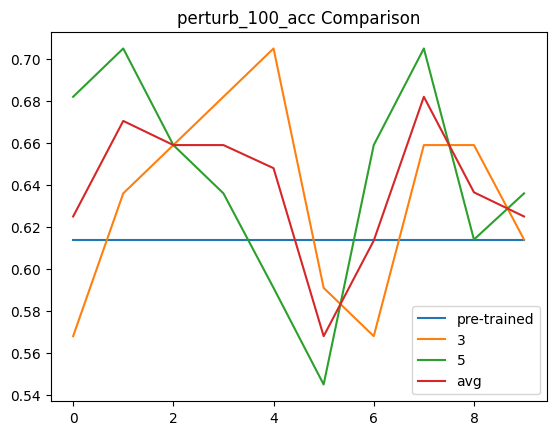

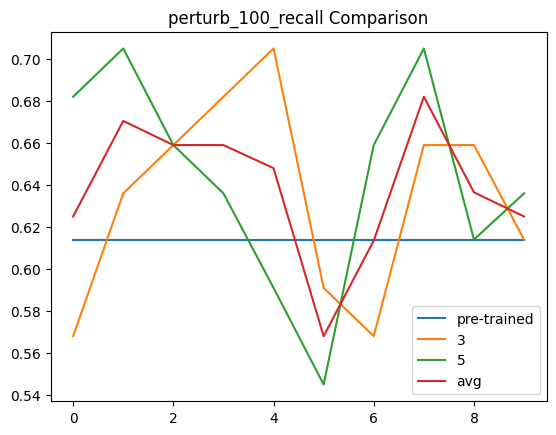

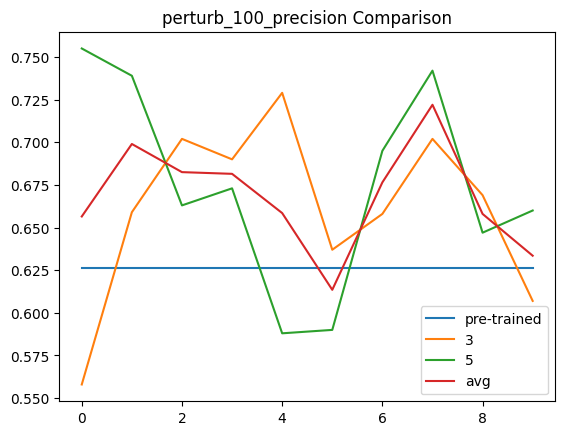

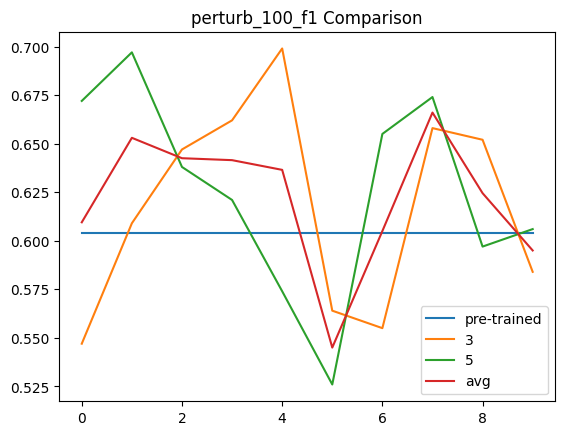

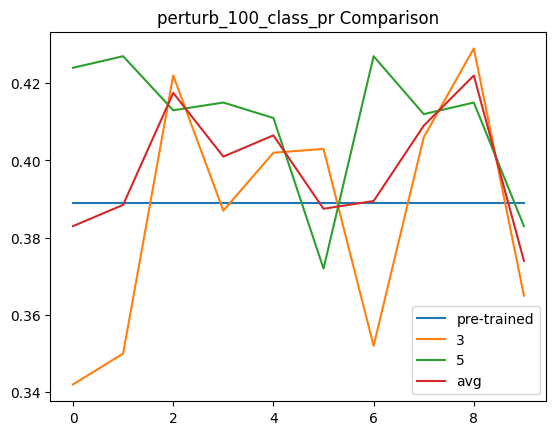

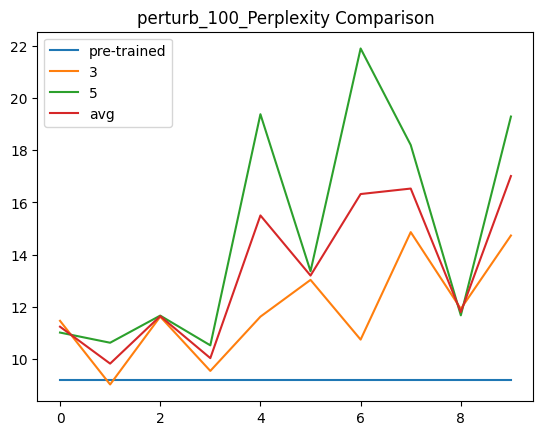

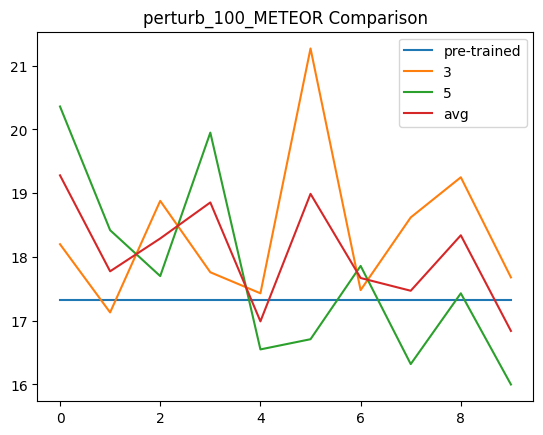

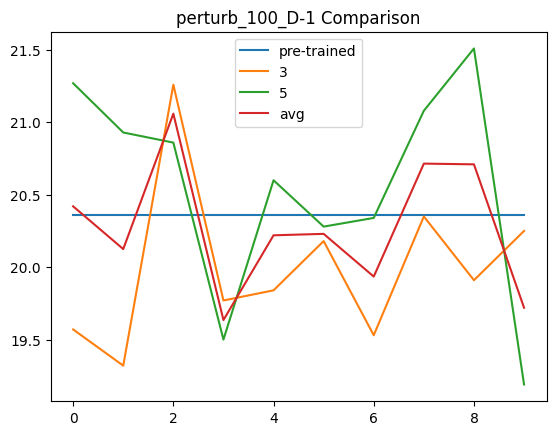

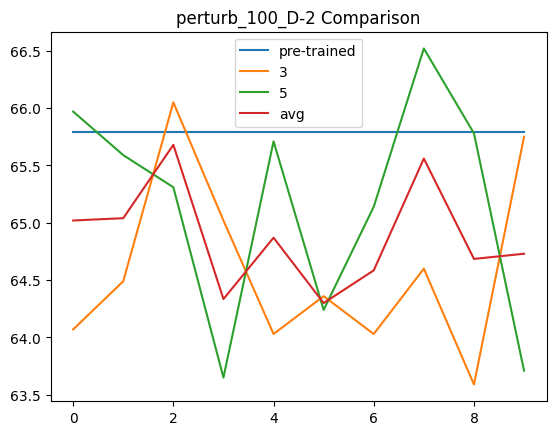

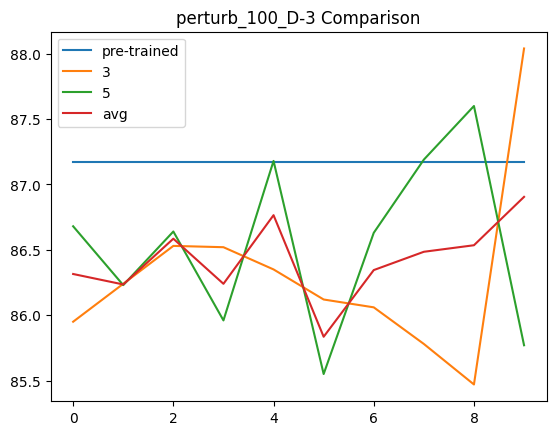

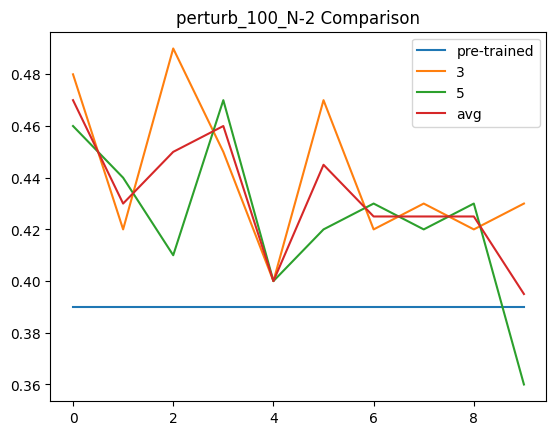

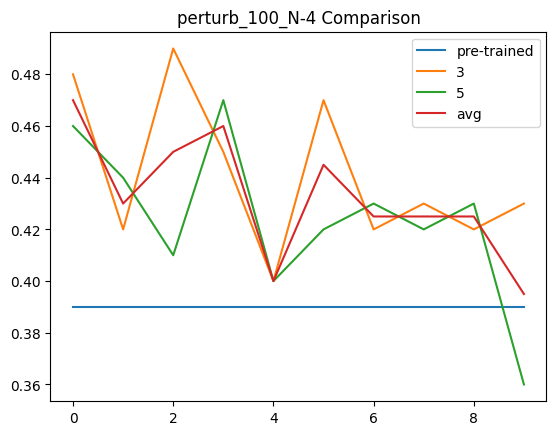

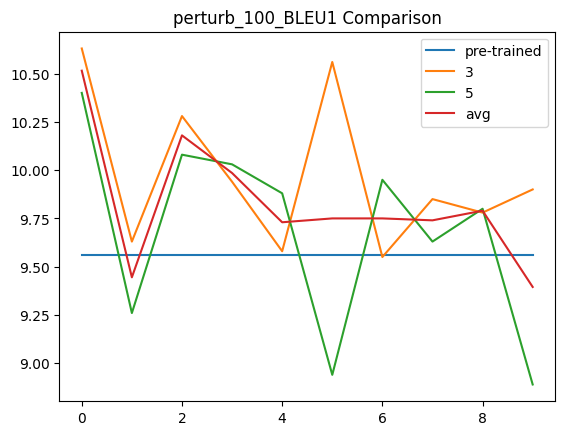

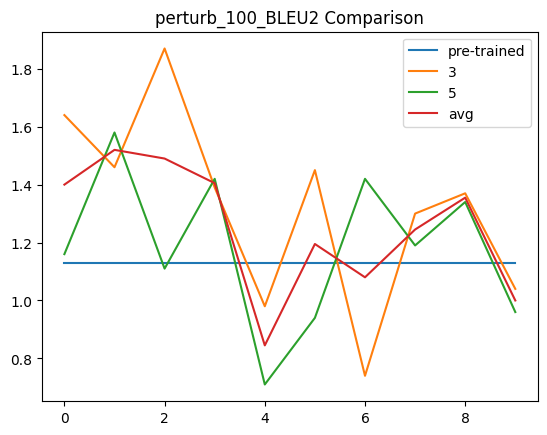

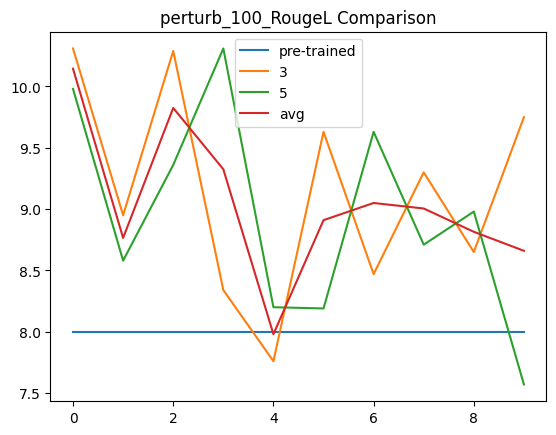

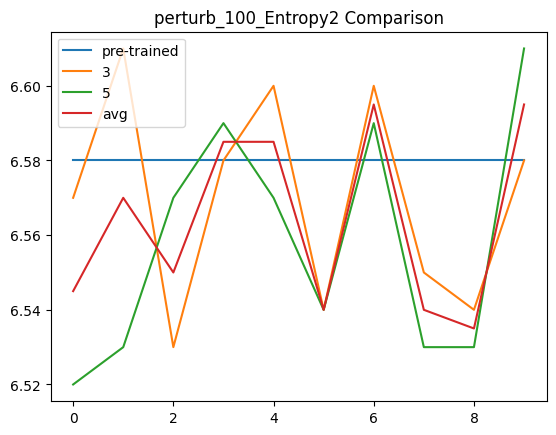

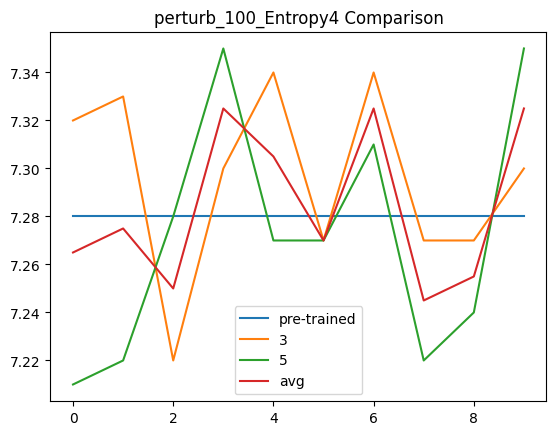

In [17]:
def plot_re(df,df_name,attribute):
    t1 = range(len(df[0]))
    plt.plot(t1,[not_perturb[attribute][0]]*len(df[0]),label ='pre-trained')
    for i,i_df in enumerate(df):
        plt.plot(t1,i_df[attribute],
                 label =df_name[i]
                )
    plt.legend()
    plt.title('perturb_100_{} Comparison'.format(attribute))
    plt.show()
for i in new_columns:
    plot_re([df_100_3,df_100_5,df_100_35],[3,5,'avg'],i)

# test_notebook

In [7]:
def slice_until_last_punctuation(text):
    punctuation_indices = [i for i, char in enumerate(text) if char in ('.', '?', '!')]
    last_punctuation_index = punctuation_indices[-1] if punctuation_indices else -1
    return text[:last_punctuation_index + 1]

sentence = """Oh, great! 🙌🏼 Sure thing! ⌛️

It'll take us around 4-5 hours to drive from Brighton to London, depending on traffic and the route we take. 🚗💨

Would you like to stop for a"""
sliced_sentence = slice_until_last_punctuation(sentence)
print(sliced_sentence)

Oh, great! 🙌🏼 Sure thing! ⌛️

It'll take us around 4-5 hours to drive from Brighton to London, depending on traffic and the route we take.


In [10]:
model_path ="meta-llama/Llama-2-7b-chat-hf"
tokenizer = LlamaTokenizer.from_pretrained(model_path)
tokenizer.pad_token = tokenizer.eos_token

In [97]:
from transformers import BertTokenizerFast, BertModel
from torch.utils.data import Dataset,DataLoader
import sklearn
from tqdm import tqdm
setting_name = '{}__{}__{}'.format(0.01,100,3)
class CustomDataset(Dataset):
    def __init__(self, df):
        self.data =df 
        self.data_list, self.label_list = self.load_data()
        
    def __len__(self):
        return len(self.label_list)
    def load_data(self):
        data_list = self.data['generated']
        label_list = self.data['act']
        
        return data_list, label_list 
    def __getitem__(self, index):
        data = self.data_list[index]
        label = torch.tensor(self.label_list[index], dtype = torch.long)
        return data, label

with open('results/'+setting_name+'.pickle', 'rb') as fr:
        data = pickle.load(fr)
data = data[data['act']!=2].reset_index(drop=True)

model = Model()
model = torch.load('/home/wooseok/orange/peft/dailydialogue/dialogpt/Bert_model/Bert_model_training/epoch10_bert_model.pt')
model.to(device)
model.eval()
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
max_len= 500

df_data = data[['generated','act']]
df_data = df_data.sample(len(df_data)).reset_index(drop=True)
test_set = CustomDataset(df_data)
test_dl = DataLoader(test_set,batch_size=20, shuffle = False)    

test_acc = 0.0
test_n_samples = 0
predictions = torch.tensor([]).to(device)
ground_truths = torch.tensor([]).to(device) 
class_pr =torch.tensor([])
model.eval()
with torch.no_grad():
    for batch_idx,batch in enumerate(tqdm(test_dl, ncols=80, desc='valid_step')):
        data, y_true = batch
        data = tokenizer(list(data), return_tensors='pt', padding=True, truncation=True)
        
        data = { k: v.to(device) for k, v in data.items() }
        y_true = y_true.to(device)
        y_pred = model(data)
        
        class_pr = torch.cat([class_pr,torch.tensor([row[true_value.item()] for row, true_value in zip(y_pred.softmax(1), y_true)])])
        pre_per = y_pred.argmax(1)
        for j in range(len(pre_per)):
            if pre_per[j] ==2:
                pre_per[j] = np.argsort(-y_pred[j].to('cpu'))[1]
        
        predictions = torch.cat([predictions,pre_per])
        ground_truths = torch.cat([ground_truths,y_true])
        
class_pr = round(torch.mean(class_pr).to('cpu').item(),3)
accuracy_score= round(sklearn.metrics.accuracy_score(y_true=ground_truths.to('cpu'), y_pred=predictions.to('cpu')),3)
recall= round(sklearn.metrics.recall_score(y_true=ground_truths.to('cpu'), y_pred=predictions.to('cpu'),average='weighted'),3)
precision = round(sklearn.metrics.precision_score(y_true=ground_truths.to('cpu'), y_pred=predictions.to('cpu'),average='weighted'),3)
f1_score = round(sklearn.metrics.f1_score(y_true=ground_truths.to('cpu'), y_pred=predictions.to('cpu'),average='weighted'),3)

print(accuracy_score,recall,precision,f1_score,class_pr)
from sklearn.metrics import confusion_matrix
confusion_matrix(ground_truths.to('cpu'), predictions.to('cpu'))


valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 21.04it/s]

0.556 0.556 0.55 0.534 0.338


array([[ 7,  3,  5],
       [ 5,  5,  5],
       [ 0,  2, 13]])

In [95]:
ground_truths

tensor([1., 1., 3., 1., 3., 3., 3., 1., 0., 3., 0., 0., 1., 0., 3., 3., 0., 3.,
        1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 3., 3., 3., 1., 1., 0.,
        0., 0., 3., 1., 3., 3., 1., 3., 0.], device='cuda:0')

In [96]:
predictions

tensor([1., 1., 3., 3., 3., 3., 3., 1., 1., 1., 3., 1., 3., 3., 3., 3., 0., 3.,
        1., 0., 1., 3., 1., 0., 3., 1., 0., 1., 1., 3., 3., 3., 3., 3., 1., 0.,
        0., 0., 3., 3., 3., 3., 1., 3., 0.], device='cuda:0')

In [92]:
y_pred

tensor([[ 0.7317, -2.7256,  0.4813,  1.0399],
        [-1.5774, -1.4053,  1.3130,  0.5814],
        [-0.4481,  1.7627, -1.2857, -0.1768],
        [ 0.2852, -1.6927, -0.9015,  1.6761],
        [ 0.2746, -0.3298, -0.4644,  0.0251]], device='cuda:0')

In [93]:
y_pred.softmax(1)

tensor([[0.3154, 0.0099, 0.2455, 0.4292],
        [0.0347, 0.0412, 0.6240, 0.3002],
        [0.0843, 0.7687, 0.0365, 0.1105],
        [0.1831, 0.0253, 0.0559, 0.7357],
        [0.3567, 0.1949, 0.1704, 0.2780]], device='cuda:0')

In [68]:
pre_per = y_pred.argmax(1)
pre_per

tensor([3, 2, 1, 1, 2, 3, 1, 1, 2, 2, 3, 0, 1, 0, 3, 3, 0, 0, 0, 3],
       device='cuda:0')

In [71]:
pre_per[1] = 3
pre_per

tensor([3, 3, 1, 1, 2, 3, 1, 1, 2, 2, 3, 0, 1, 0, 3, 3, 0, 0, 0, 3],
       device='cuda:0')

In [72]:
y_pred

tensor([[-0.7153, -0.8462,  0.2107,  0.7076],
        [-1.2018, -1.0213,  0.9928,  0.4032],
        [-1.2252,  0.9010,  0.1212, -0.1408],
        [-0.4481,  1.7627, -1.2857, -0.1768],
        [-1.5854, -0.7354,  1.4314,  0.0581],
        [ 0.2852, -1.6927, -0.9015,  1.6761],
        [-1.5733,  1.4170,  0.4467, -0.7066],
        [-0.3676,  0.5230, -0.8266,  0.4917],
        [-1.7734,  0.1107,  1.2698, -0.0896],
        [-1.0396, -1.5939,  0.8745,  0.7558],
        [-0.2976, -0.9134,  0.2868,  0.5813],
        [ 2.4123, -2.1623, -1.5726,  0.8576],
        [-0.6304,  0.9049,  0.0425, -0.2481],
        [ 1.0997, -0.8881, -1.1317,  0.7076],
        [ 0.7317, -2.7256,  0.4813,  1.0399],
        [-0.0215, -1.2402, -0.2280,  0.8853],
        [ 2.5243, -2.1539, -1.4676,  0.8529],
        [ 1.1656, -1.4185, -0.9953,  0.8651],
        [ 1.6974, -1.1524, -0.8651,  0.3224],
        [-0.8582, -1.2882,  0.4377,  0.9689]], device='cuda:0')

In [89]:
pre_per

tensor([3, 3, 1, 1, 3, 3, 1, 1, 2, 2, 3, 0, 1, 0, 3, 3, 0, 0, 0, 3],
       device='cuda:0')

In [87]:
np.argsort(-y_pred[3].to('cpu'))[1]

tensor(3)

In [88]:
pre_per[4] = np.argsort(-y_pred[4].to('cpu'))[1]

In [79]:
y_pred[4].argmax()

tensor(2, device='cuda:0')

In [73]:
y_pred.argmax(1)

tensor([3, 2, 1, 1, 2, 3, 1, 1, 2, 2, 3, 0, 1, 0, 3, 3, 0, 0, 0, 3],
       device='cuda:0')

In [66]:
np.argsort(-y_pred.to('cpu'), axis=1)[:, 1]

tensor([2, 3, 3, 2, 1])

In [63]:
predictions

tensor([3., 3., 3., 2., 2., 0., 3., 3., 0., 1., 1., 2., 3., 1., 0., 2., 0., 1.,
        3., 1., 2., 3., 3., 2., 0., 3., 1., 2., 1., 3., 3., 3., 2., 2., 1., 0.,
        0., 1., 3., 1., 1., 1., 0., 3., 2.], device='cuda:0')

In [64]:
ground_truths

tensor([3., 3., 3., 3., 1., 0., 0., 3., 0., 1., 0., 3., 3., 1., 0., 1., 1., 1.,
        3., 1., 0., 0., 0., 3., 0., 1., 1., 3., 1., 3., 3., 1., 3., 0., 3., 0.,
        0., 1., 0., 1., 1., 0., 0., 3., 1.], device='cuda:0')

In [47]:
22/36

0.6111111111111112

In [37]:
class_pr.item()

NameError: name 'class_pr' is not defined

In [116]:
import sklearn
accuracy_score= round(sklearn.metrics.accuracy_score(y_true=ground_truths.to('cpu'), y_pred=predictions.to('cpu')),3)
recall= round(sklearn.metrics.recall_score(y_true=ground_truths.to('cpu'), y_pred=predictions.to('cpu'),average='weighted'),3)
precision = round(sklearn.metrics.precision_score(y_true=ground_truths.to('cpu'), y_pred=predictions.to('cpu'),average='weighted'),3)
f1_score = round(sklearn.metrics.f1_score(y_true=ground_truths.to('cpu'), y_pred=predictions.to('cpu'),average='weighted'),3)


0.475

In [113]:
for i in  ['micro', 'macro', 'weighted']:
    
    print(precision)

0.475
0.477
0.475


In [114]:
for i in  ['micro', 'macro', 'weighted']:
    precision= round(sklearn.metrics.precision_score(y_true=ground_truths.to('cpu'), y_pred=predictions.to('cpu'),average=i),3)
    print(precision)

0.475
0.476
0.477


In [115]:
for i in  ['micro', 'macro', 'weighted']:
    precision= round(sklearn.metrics.f1_score(y_true=ground_truths.to('cpu'), y_pred=predictions.to('cpu'),average=i),3)
    print(precision)

0.475
0.471
0.47


In [ ]:
accuracy_score= round(sklearn.metrics.accuracy_score(y_true=np.array(val_targets), y_pred=val_preds, average =average),3)
precision= round(sklearn.metrics.precision_score(y_true=np.array(val_targets), y_pred=val_preds, average =average),3)
recall = round(sklearn.metrics.recall_score(y_true=np.array(val_targets), y_pred=val_preds, average =average),3)
f1 = round(sklearn.metrics.f1_score(y_true=np.array(val_targets), y_pred=val_preds, average =average),3)

In [72]:
import string
import random

In [89]:

letters_set = string.ascii_letters
random_list = random.sample(letters_set[26:],10)
print(random_list)

['K', 'X', 'C', 'Y', 'H', 'U', 'R', 'A', 'W', 'T']
